## Causal Tracing (ROME)

Causal tracing was a methodology for locating where facts are stored in transformer LMs, introduced in the paper ["Locating and Editing Factual Associations in GPT" (Meng et al., 2023)](https://arxiv.org/abs/2202.05262). In this notebook, we will implement their method using this library and replicate the first causal tracing example in the paper (full figure 1 on page 2).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/frankaging/pyvene/blob/main/tutorials/advance_tutorials/Causal_Tracing.ipynb)

In [1]:
__author__ = "Aryaman Arora"
__version__ = "11/08/2023"

### Set-up

In [2]:
try:
    # This library is our indicator that the required installs
    # need to be done.
    import pyvene

except ModuleNotFoundError:
    !pip install git+https://github.com/stanfordnlp/pyvene.git

  Cloning https://github.com/stanfordnlp/pyvene.git to /tmp/pip-req-build-u3tj3d4e
  Running command git clone --filter=blob:none --quiet https://github.com/stanfordnlp/pyvene.git /tmp/pip-req-build-u3tj3d4e
  Resolved https://github.com/stanfordnlp/pyvene.git to commit 0d3f1f85065f87f849fd2cba060c69ecf69b65be
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.0 MB/s eta 0:00:00
  Creat

In [3]:
import torch
import pandas as pd
import numpy as np
from pyvene import embed_to_distrib, top_vals, format_token
from pyvene import (
    IntervenableModel,
    VanillaIntervention, Intervention,
    RepresentationConfig,
    IntervenableConfig,
    ConstantSourceIntervention,
    LocalistRepresentationIntervention
)
from pyvene import create_gpt2

%config InlineBackend.figure_formats = ['svg']
from plotnine import (
    ggplot,
    geom_tile,
    aes,
    facet_wrap,
    theme,
    element_text,
    geom_bar,
    geom_hline,
    scale_y_log10,
    xlab, ylab, ylim,
    scale_y_discrete, scale_y_continuous, ggsave
)
from plotnine.scales import scale_y_reverse, scale_fill_cmap
from tqdm import tqdm

titles={
    "block_output": "single restored layer in GPT2-XL",
    "mlp_activation": "center of interval of 10 patched mlp layer",
    "attention_output": "center of interval of 10 patched attn layer"
}

colors={
    "block_output": "Purples",
    "mlp_activation": "Greens",
    "attention_output": "Reds"
}

nnsight is not detected. Please install via 'pip install nnsight' for nnsight backend.


### Factual recall

Let's set up the model (gpt2-xl) and test it on the fact we want to causal trace: "The Space Needle is in downtown **Seattle**".

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
config, tokenizer, gpt = create_gpt2(name="gpt2-xl")
gpt.to(device)

base = "The Space Needle is in downtown"
inputs = [
    tokenizer(base, return_tensors="pt").to(device),
]
print(base)
res = gpt(**inputs[0])
distrib = embed_to_distrib(gpt, res.last_hidden_state, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

loaded model
The Space Needle is in downtown
_Seattle             0.9763796925544739
_Bellev              0.002768274862319231
_Portland            0.0021577731240540743
,                    0.0015149362152442336
_Vancouver           0.0014351309509947896
_San                 0.0013575759949162602
_Minneapolis         0.0009382647695019841
.                    0.0007443451904691756
_Tacoma              0.0006097268196754158
_Los                 0.0005885560531169176


## Corrupted run

The first step in implementing causal tracing is to corrupt the input embeddings for the subject tokens by adding Gaussian noise to them. In Meng et al., the standard deviation of the Gaussian we sample from is computed as thrice the standard deviation of embeddings over a big dataset. We encode this as a constant, `self.noise_level`.

Note that the `source` argument is ignored unlike in causal interventions, since we are adding noise without reference to any other input.

Our intervention config intervenes on the `block_input` of the 0th layer, i.e. the embeddings.

In [ ]:
class NoiseIntervention(ConstantSourceIntervention, LocalistRepresentationIntervention):
    def __init__(self, embed_dim, **kwargs):
        super().__init__()
        self.interchange_dim = embed_dim
        rs = np.random.RandomState(1)
        prng = lambda *shape: rs.randn(*shape)
        self.noise = torch.from_numpy(
            prng(1, 4, embed_dim)).to(device)
        self.noise_level = 0.13462981581687927

    def forward(self, base, source=None, subspaces=None):
        base[..., : self.interchange_dim] += self.noise * self.noise_level
        return base

    def __str__(self):
        return f"NoiseIntervention(embed_dim={self.embed_dim})"


def corrupted_config(model_type):
    config = IntervenableConfig(
        model_type=model_type,
        representations=[
            RepresentationConfig(
                0,              # layer
                "block_input",  # intervention type
            ),
        ],
        intervention_types=NoiseIntervention,
    )
    return config

Let's check that this reduced the probability of the output "_Seattle".

In [ ]:
base = tokenizer("The Space Needle is in downtown", return_tensors="pt").to(device)
config = corrupted_config(type(gpt))
intervenable = IntervenableModel(config, gpt)
_, counterfactual_outputs = intervenable(
    base, unit_locations={"base": ([[[0, 1, 2, 3]]])}
)
distrib = embed_to_distrib(gpt, counterfactual_outputs.last_hidden_state, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

_Los                 0.032942529767751694
_San                 0.03194483369588852
_Seattle             0.02617643028497696
_Toronto             0.025859180837869644
_Chicago             0.024749109521508217
_Houston             0.024224253371357918
_Atlanta             0.018664484843611717
_Austin              0.017735300585627556
_St                  0.017606735229492188
_Denver              0.017408840358257294


### Restored run

We now make a config that performs the following:
1. Corrupt input embeddings for some positions.
2. Restore the hidden state at a particular layer for some (potentially different positions).

This is how Meng et al. check where in the model the fact moves through.

In [ ]:
def restore_corrupted_with_interval_config(
    layer, stream="mlp_activation", window=10, num_layers=48):
    start = max(0, layer - window // 2)
    end = min(num_layers, layer - (-window // 2))
    config = IntervenableConfig(
        representations=[
            RepresentationConfig(
                0,       # layer
                "block_input",  # intervention type
            ),
        ] + [
            RepresentationConfig(
                i,       # layer
                stream,  # intervention type
        ) for i in range(start, end)],
        intervention_types=\
            [NoiseIntervention]+[VanillaIntervention]*(end-start),
    )
    return config

Now let's run this over all layers and positions! We will corrupt positions 0, 1, 2, 3 ("The Space Needle", i.e. the subject of the fact) and restore at a single position at every layer.

In [ ]:
# should finish within 1 min with a standard 12G GPU
token = tokenizer.encode(" Seattle")[0]
print(token)

7312


In [ ]:
for stream in ["block_output", "mlp_activation", "attention_output"]:
    data = []
    for layer_i in tqdm(range(gpt.config.n_layer)):
        for pos_i in range(7): #wszystkie tokeny
            config = restore_corrupted_with_interval_config(
                layer_i, stream,
                window=1 if stream == "block_output" else 10
            )
            n_restores = len(config.representations) - 1
            intervenable = IntervenableModel(config, gpt)
            _, counterfactual_outputs = intervenable(
                base,
                [None] + [base]*n_restores,
                {
                    "sources->base": (
                        [None] + [[[pos_i]]]*n_restores,
                        [[[0, 1, 2, 3]]] + [[[pos_i]]]*n_restores,
                    )
                },
            )
            distrib = embed_to_distrib(
                gpt, counterfactual_outputs.last_hidden_state, logits=False
            )
            prob = distrib[0][-1][token].detach().cpu().item()
            data.append({"layer": layer_i, "pos": pos_i, "prob": prob})
    df = pd.DataFrame(data)
    df.to_csv(f"./tutorial_data/pyvene_rome_{stream}.csv")

100%|██████████| 48/48 [02:06<00:00,  2.63s/it]


The plot below should now replicate Meng et al.

In [ ]:
for stream in ["block_output", "mlp_activation", "attention_output"]:
    df = pd.read_csv(f"./tutorial_data/pyvene_rome_{stream}.csv")
    df["layer"] = df["layer"].astype(int)
    df["pos"] = df["pos"].astype(int)
    df["p(Seattle)"] = df["prob"].astype(float)

    custom_labels = ["The*", "Space*", "Need*", "le*", "is", "in", "downtown"]
    breaks = [0, 1, 2, 3, 4, 5, 6]

    plot = (
        ggplot(df, aes(x="layer", y="pos"))

        + geom_tile(aes(fill="p(Seattle)"))
        + scale_fill_cmap(colors[stream]) + xlab(titles[stream])
        + scale_y_reverse(
            limits = (-0.5, 6.5),
            breaks=breaks, labels=custom_labels)
        + theme(figure_size=(5, 4)) + ylab("")
        + theme(axis_text_y  = element_text(angle = 90, hjust = 1))
    )
    ggsave(
        plot, filename=f"./tutorial_data/pyvene_rome_{stream}.pdf", dpi=200
    )
    print(plot)

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/pyvene_rome_block_output.pdf


<ggplot: (500 x 400)>


/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/pyvene_rome_mlp_activation.pdf


<ggplot: (500 x 400)>


/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/pyvene_rome_attention_output.pdf


<ggplot: (500 x 400)>


/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/pyvene_rome_block_output.pdf


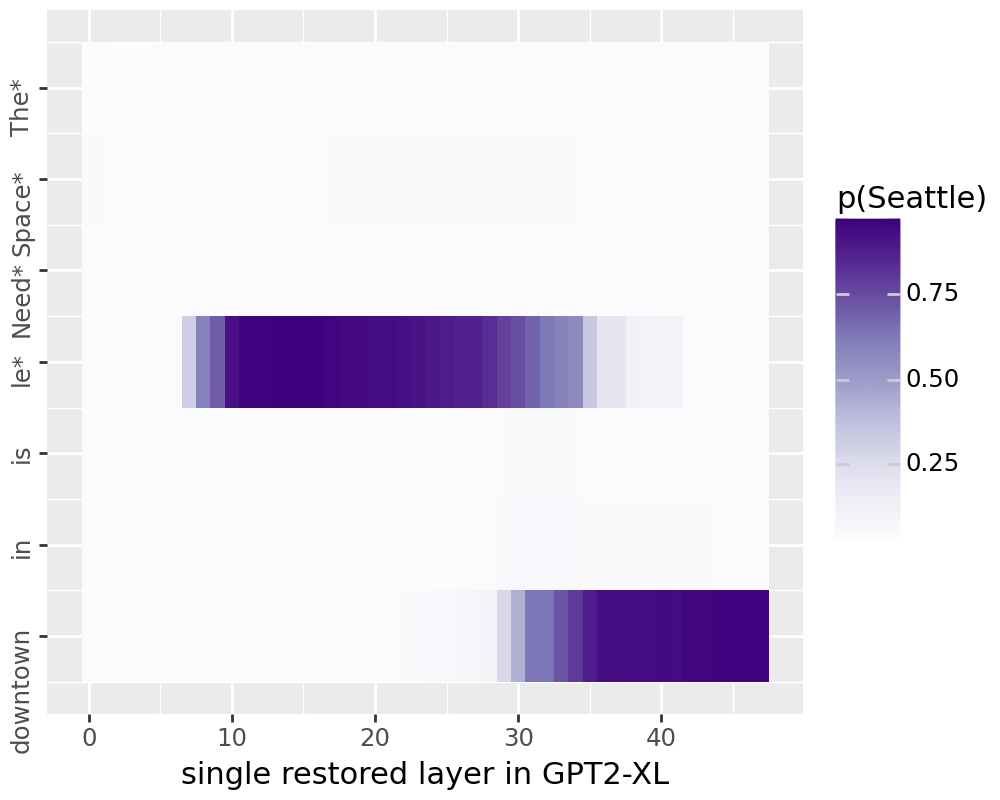

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/pyvene_rome_mlp_activation.pdf


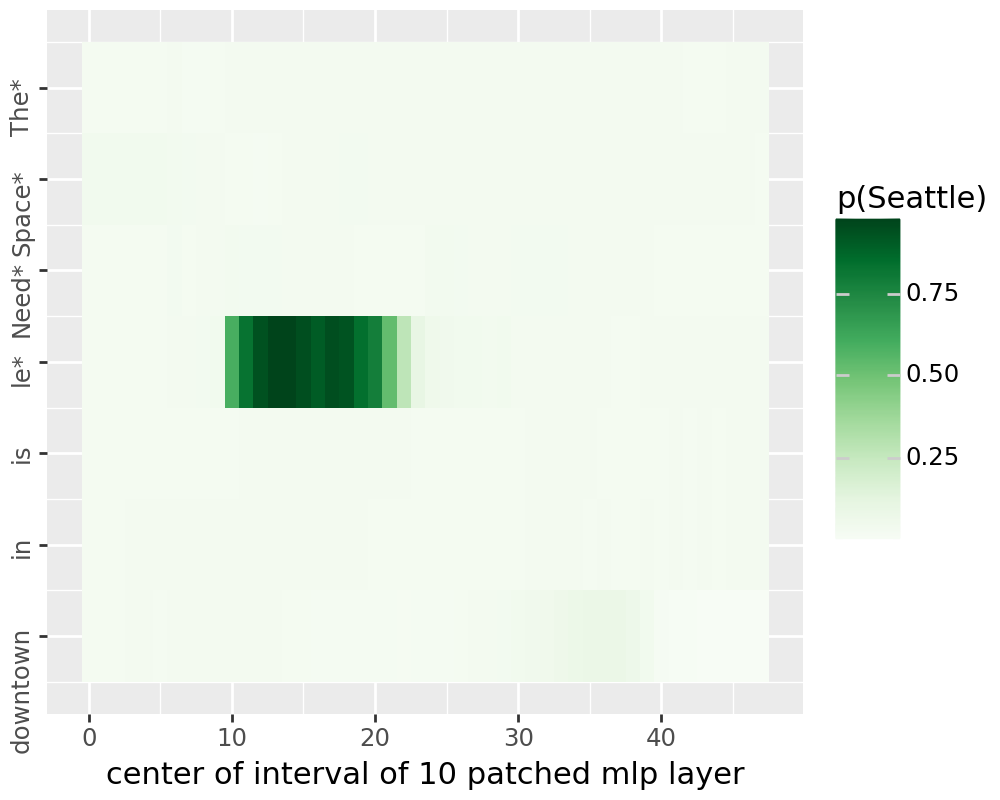

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/pyvene_rome_attention_output.pdf


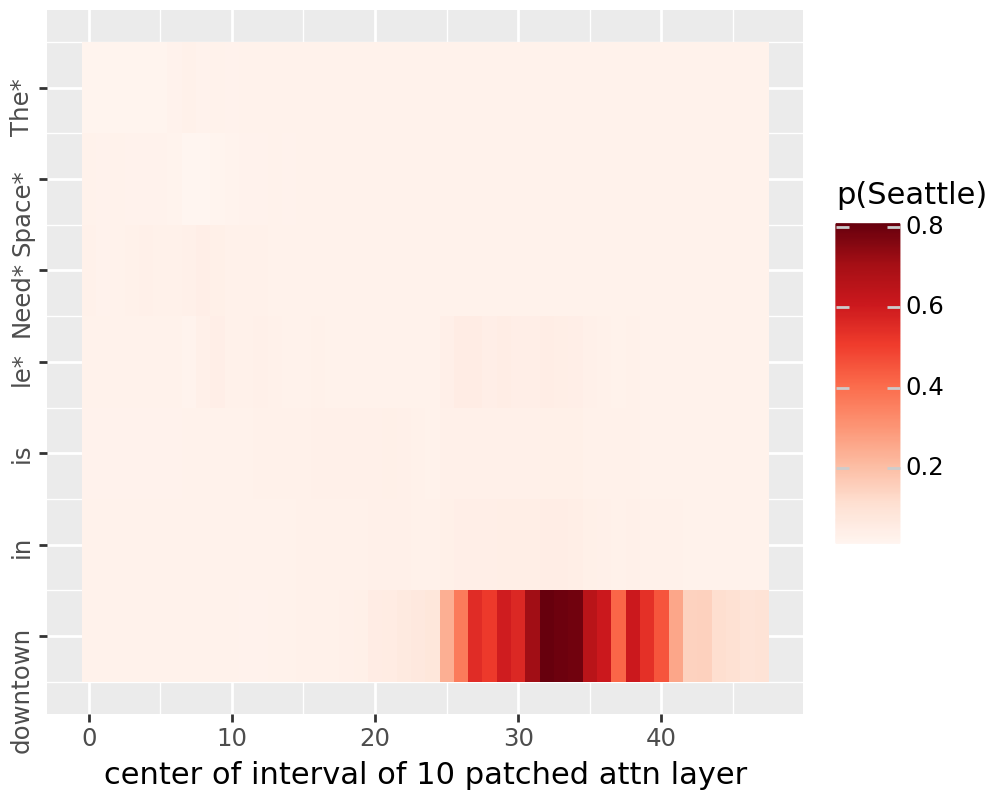

In [ ]:
from plotnine import *
import pandas as pd

for stream in ["block_output", "mlp_activation", "attention_output"]:
    df = pd.read_csv(f"./tutorial_data/pyvene_rome_{stream}.csv")
    df["layer"] = df["layer"].astype(int)
    df["pos"] = df["pos"].astype(int)
    df["p(Seattle)"] = df["prob"].astype(float)

    custom_labels = ["The*", "Space*", "Need*", "le*", "is", "in", "downtown"]
    breaks = [0, 1, 2, 3, 4, 5, 6]

    plot = (
        ggplot(df, aes(x="layer", y="pos"))
        + geom_tile(aes(fill="p(Seattle)"))
        + scale_fill_cmap(colors[stream])
        + xlab(titles[stream])
        + scale_y_reverse(
            limits=(-0.5, 6.5),
            breaks=breaks, labels=custom_labels
        )
        + theme(figure_size=(5, 4))
        + ylab("")
        + theme(axis_text_y=element_text(angle=90, hjust=1))
    )
    # Save the plot to a file
    ggsave(
        plot, filename=f"./tutorial_data/pyvene_rome_{stream}.pdf", dpi=200
    )
    # Display the plot in the notebook
    display(plot)

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
config, tokenizer, gpt = create_gpt2(name="gpt2-xl")
gpt.to(device)

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

loaded model


GPT2Model(
  (wte): Embedding(50257, 1600)
  (wpe): Embedding(1024, 1600)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-47): 48 x GPT2Block(
      (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2SdpaAttention(
        (c_attn): Conv1D(nf=4800, nx=1600)
        (c_proj): Conv1D(nf=1600, nx=1600)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=6400, nx=1600)
        (c_proj): Conv1D(nf=1600, nx=6400)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
)

In [ ]:
examples = [
    {"sentence": "Warsaw is the capital of", "subject": "Warsaw"},
    {"sentence": "Putin is the president of", "subject": "Putin"},
    #{"sentence": "Jesus founded a religion called", "subject": "Jesus"},
    {"sentence": "The Mona Lisa was painted by", "subject": "The Mona Lisa"},
    {"sentence": "Half-Life was created by a company called", "subject": "Half-Life"}
]

In [ ]:
for example in examples:

  base = example["sentence"]
  inputs = [
    tokenizer(base, return_tensors="pt").to(device),
  ]
  print(base)
  res = gpt(**inputs[0])
  distrib = embed_to_distrib(gpt, res.last_hidden_state, logits=False)
  top_1_token_id = torch.argmax(distrib[0][-1]).item()  # Get the token ID of the most probable word
  top_1_word = tokenizer.decode([top_1_token_id])  # Decode token ID to word
  print(top_1_word)
  example["answer"] = top_1_word

Warsaw is the capital of
 Poland
Putin is the president of
 Russia
The Mona Lisa was painted by
 Leonardo
Half-Life was created by a company called
 Valve


In [ ]:
def get_top_answer(sentence):
  base = sentence
  inputs = [
    tokenizer(base, return_tensors="pt").to(device),
  ]
  res = gpt(**inputs[0])
  distrib = embed_to_distrib(gpt, res.last_hidden_state, logits=False)
  top_1_token_id = torch.argmax(distrib[0][-1]).item()  # Get the token ID of the most probable word
  top_1_word = tokenizer.decode([top_1_token_id])  # Decode token ID to word
  return top_1_word

In [ ]:
examples

[{'sentence': 'Warsaw is the capital of', 'subject': 'Warsaw'},
 {'sentence': 'Putin is the president of', 'subject': 'Putin'},
 {'sentence': 'The Mona Lisa was painted by', 'subject': 'The Mona Lisa'},
 {'sentence': 'Half-Life was created by a company called',
  'subject': 'Half-Life'}]

In [5]:
class NoiseIntervention(ConstantSourceIntervention, LocalistRepresentationIntervention):
    def __init__(self, embed_dim, noise_dim, **kwargs):
        super().__init__()
        self.interchange_dim = embed_dim
        rs = np.random.RandomState(1)
        prng = lambda *shape: rs.randn(*shape)
        self.noise = torch.from_numpy(
            prng(1, noise_dim, embed_dim)).to(device)
        self.noise_level = 0.13462981581687927

    def forward(self, base, source=None, subspaces=None):
        base[..., : self.interchange_dim] += self.noise * self.noise_level
        return base

    def __str__(self):
        return f"NoiseIntervention(embed_dim={self.embed_dim})"


def corrupted_config(model_type, noise_dim):
    config = IntervenableConfig(
        model_type=model_type,
        representations=[
            RepresentationConfig(
                0,              # layer
                "block_input",  # intervention type
            ),
        ],
        intervention_types=lambda embed_dim, **kwargs: NoiseIntervention(embed_dim, noise_dim=noise_dim, **kwargs),
    )
    return config

In [6]:
def restore_corrupted_with_interval_config(
    layer, stream="mlp_activation", window=10, num_layers=48, noise_dim=2):
    start = max(0, layer - window // 2)
    end = min(num_layers, layer - (-window // 2))
    config = IntervenableConfig(
        representations=[
            RepresentationConfig(
                0,       # layer
                "block_input",  # intervention type
            ),
        ] + [
            RepresentationConfig(
                i,       # layer
                stream,  # intervention type
        ) for i in range(start, end)],
        intervention_types=\
            [lambda embed_dim, **kwargs: NoiseIntervention(embed_dim, noise_dim=noise_dim, **kwargs)]+[VanillaIntervention]*(end-start),
    )
    return config

In [ ]:
for example in examples:
  sentence = example["sentence"]
  subject = example["subject"]

  example["answer"] = get_top_answer(sentence)

  sentence_tokens = tokenizer.encode(sentence)

  subject_tokens = tokenizer.encode(subject)

  subject_tokens_positions = [i for i in range(len(subject_tokens))]

  answer_token = tokenizer.encode(example["answer"])[0]

  print(sentence)
  #corrupt
  base = tokenizer(sentence, return_tensors="pt").to(device)
  config = corrupted_config(type(gpt), len(subject_tokens))
  intervenable = IntervenableModel(config, gpt)
  _, counterfactual_outputs = intervenable(
      base, unit_locations={"base": ([[subject_tokens_positions]])}
  )
  distrib = embed_to_distrib(gpt, counterfactual_outputs.last_hidden_state, logits=False)
  top_vals(tokenizer, distrib[0][-1], n=10)

  for stream in ["block_output", "mlp_activation", "attention_output"]:
    data = []
    for layer_i in tqdm(range(gpt.config.n_layer)):
        for pos_i in range(len(sentence_tokens)):
            config = restore_corrupted_with_interval_config(
                layer_i, stream,
                window=1 if stream == "block_output" else 10, noise_dim=len(subject_tokens)
            )
            n_restores = len(config.representations) - 1
            intervenable = IntervenableModel(config, gpt)
            _, counterfactual_outputs = intervenable(
                base,
                [None] + [base]*n_restores,
                {
                    "sources->base": (
                        [None] + [[[pos_i]]]*n_restores,
                        [[subject_tokens_positions]] + [[[pos_i]]]*n_restores,
                    )
                },
            )
            distrib = embed_to_distrib(
                gpt, counterfactual_outputs.last_hidden_state, logits=False
            )

            prob = distrib[0][-1][answer_token].detach().cpu().item()
            data.append({"layer": layer_i, "pos": pos_i, "prob": prob})
    df = pd.DataFrame(data)
    df.to_csv(f"./tutorial_data/{subject}_pyvene_rome_{stream}.csv")


Warsaw is the capital of
_the                 0.4333674907684326
_North               0.01791013777256012
_South               0.011500866152346134
_West                0.011185603216290474
_a                   0.010587134398519993
_Ghana               0.006190699990838766
_N                   0.0056714159436523914
_K                   0.005460169166326523
_Nigeria             0.005394035018980503
_Georgia             0.004891006276011467


100%|██████████| 48/48 [01:45<00:00,  2.20s/it]


Putin is the president of
_the                 0.5224699378013611
_Russia              0.06464104354381561
_a                   0.0466613695025444
_Ukraine             0.012148785404860973
_The                 0.0068623097613453865
_an                  0.006812518462538719
_RT                  0.004647014196962118
_his                 0.004588256124407053
_this                0.003954562358558178
_Syria               0.0036428652238100767


100%|██████████| 48/48 [01:25<00:00,  1.79s/it]


The Mona Lisa was painted by
_the                 0.14901375770568848
_a                   0.05299697071313858
_an                  0.014662344008684158
_John                0.009851212613284588
_his                 0.009260494261980057
_J                   0.0070603578351438046
_artist              0.006911109201610088
_Jean                0.006724927574396133
_one                 0.006236115004867315
_Paul                0.005782408639788628


100%|██████████| 48/48 [02:04<00:00,  2.60s/it]


Half-Life was created by a company called
_a                   0.11447379738092422
_the                 0.07588911056518555
_"                   0.05597665533423424
_in                  0.03331339359283447
_an                  0.02534489519894123
,                    0.020056728273630142
_to                  0.019955171272158623
_as                  0.01852378249168396
_on                  0.01666427031159401
_by                  0.01083370205014944


100%|██████████| 48/48 [02:58<00:00,  3.72s/it]


In [ ]:
!zip -r /content/data.zip /content/tutorial_data

  adding: content/tutorial_data/ (stored 0%)
  adding: content/tutorial_data/The Mona Lisa_pyvene_rome_mlp_activation.csv (deflated 55%)
  adding: content/tutorial_data/The Mona Lisa_pyvene_rome_block_output.csv (deflated 55%)
  adding: content/tutorial_data/Warsaw_pyvene_rome_block_output.csv (deflated 55%)
  adding: content/tutorial_data/The Mona Lisa_pyvene_rome_attention_output.csv (deflated 55%)
  adding: content/tutorial_data/Warsaw_pyvene_rome_attention_output.csv (deflated 56%)
  adding: content/tutorial_data/Putin_pyvene_rome_mlp_activation.csv (deflated 53%)
  adding: content/tutorial_data/Putin_pyvene_rome_attention_output.csv (deflated 53%)
  adding: content/tutorial_data/Half-Life_pyvene_rome_mlp_activation.csv (deflated 54%)
  adding: content/tutorial_data/Half-Life_pyvene_rome_attention_output.csv (deflated 54%)
  adding: content/tutorial_data/Half-Life_pyvene_rome_block_output.csv (deflated 54%)
  adding: content/tutorial_data/Putin_pyvene_rome_block_output.csv (deflate

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/Warsaw_pyvene_rome_block_output.pdf


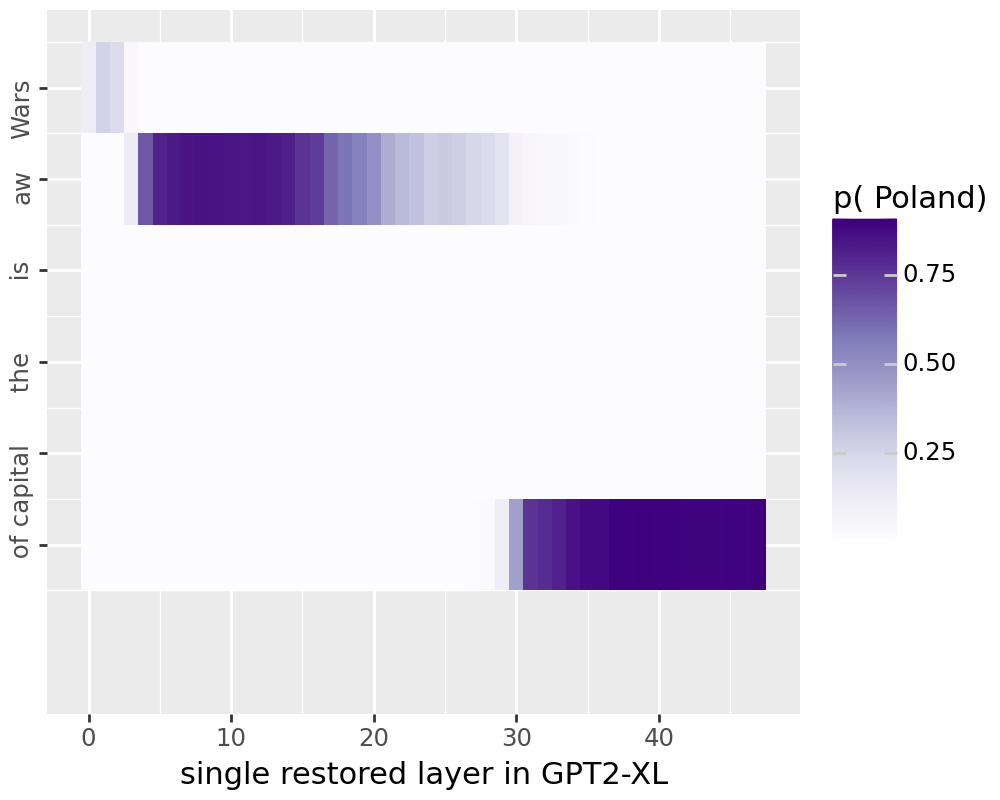

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/Warsaw_pyvene_rome_mlp_activation.pdf


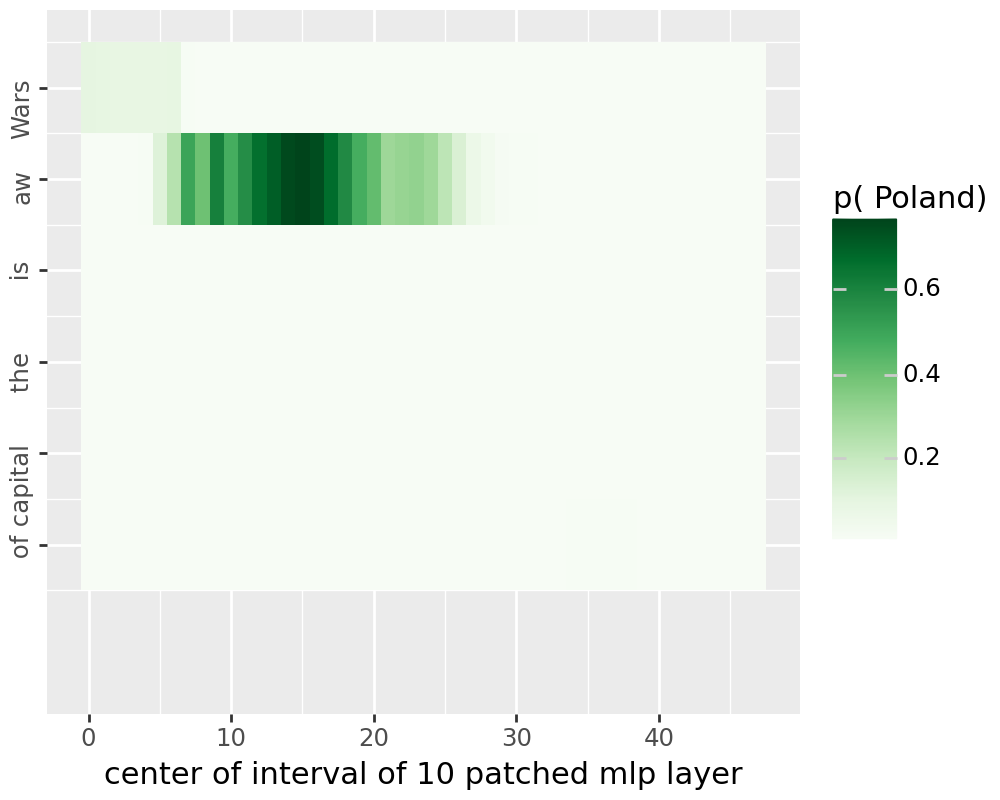

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/Warsaw_pyvene_rome_attention_output.pdf


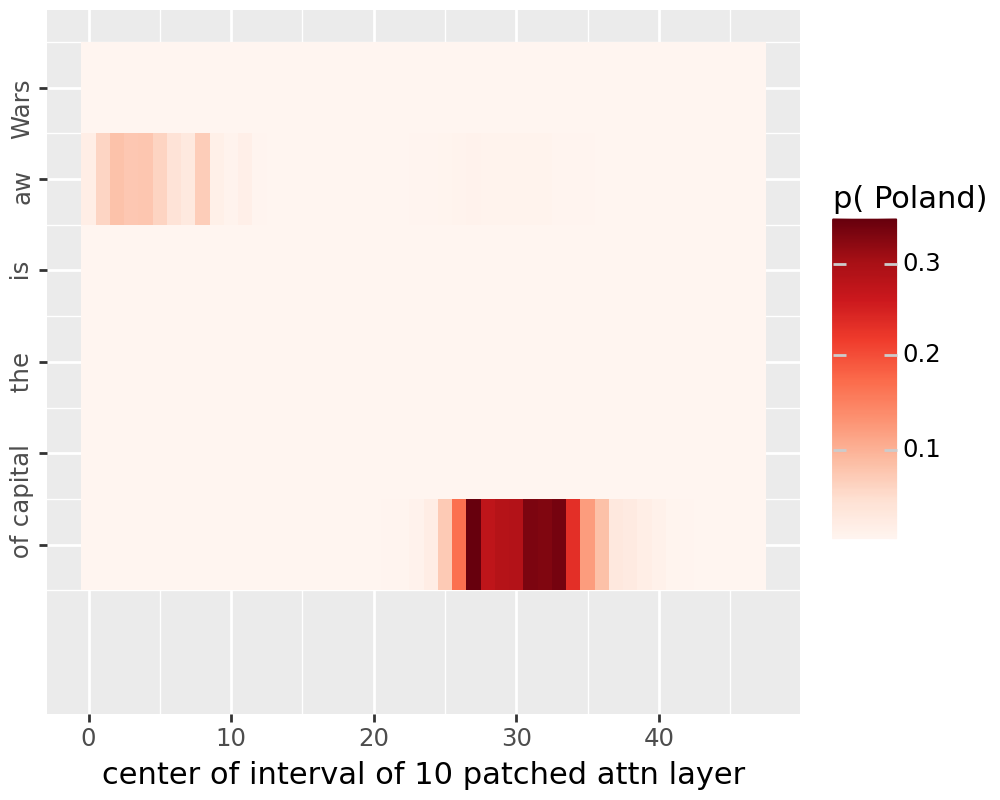

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/Putin_pyvene_rome_block_output.pdf


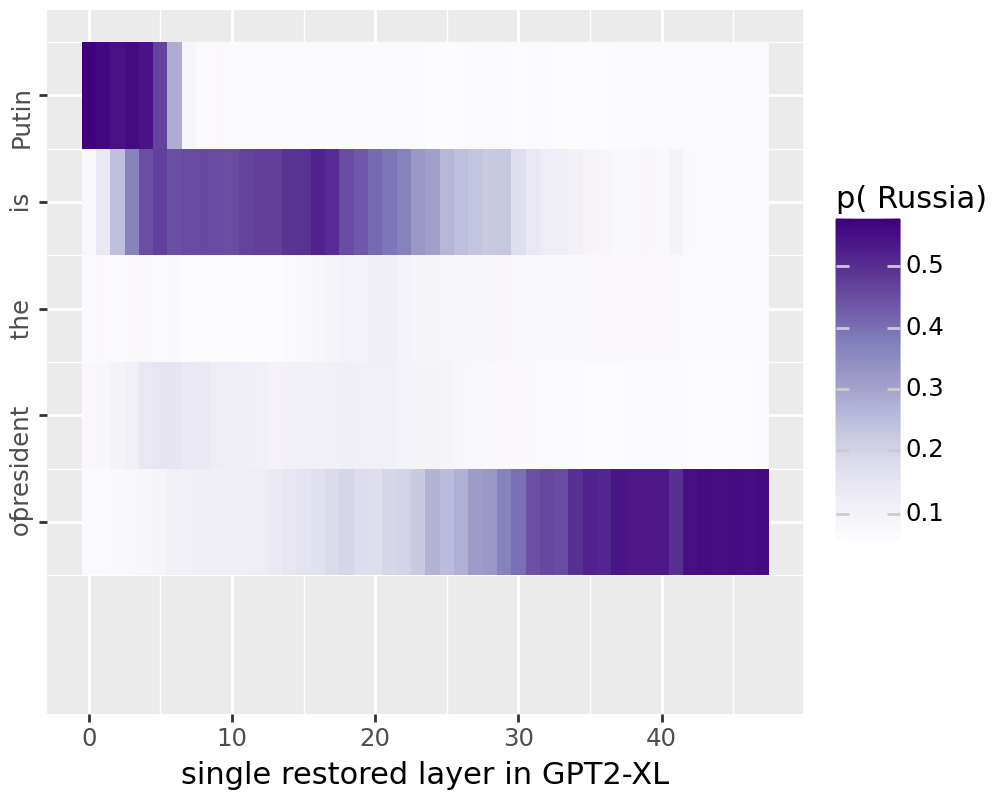

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/Putin_pyvene_rome_mlp_activation.pdf


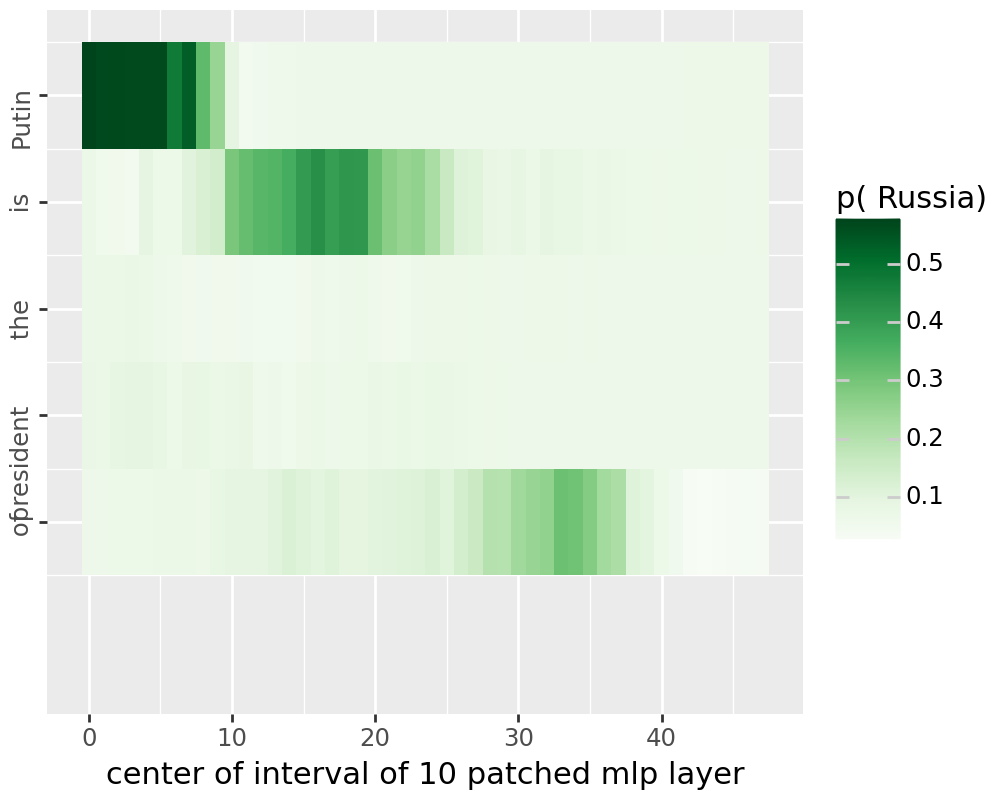

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/Putin_pyvene_rome_attention_output.pdf


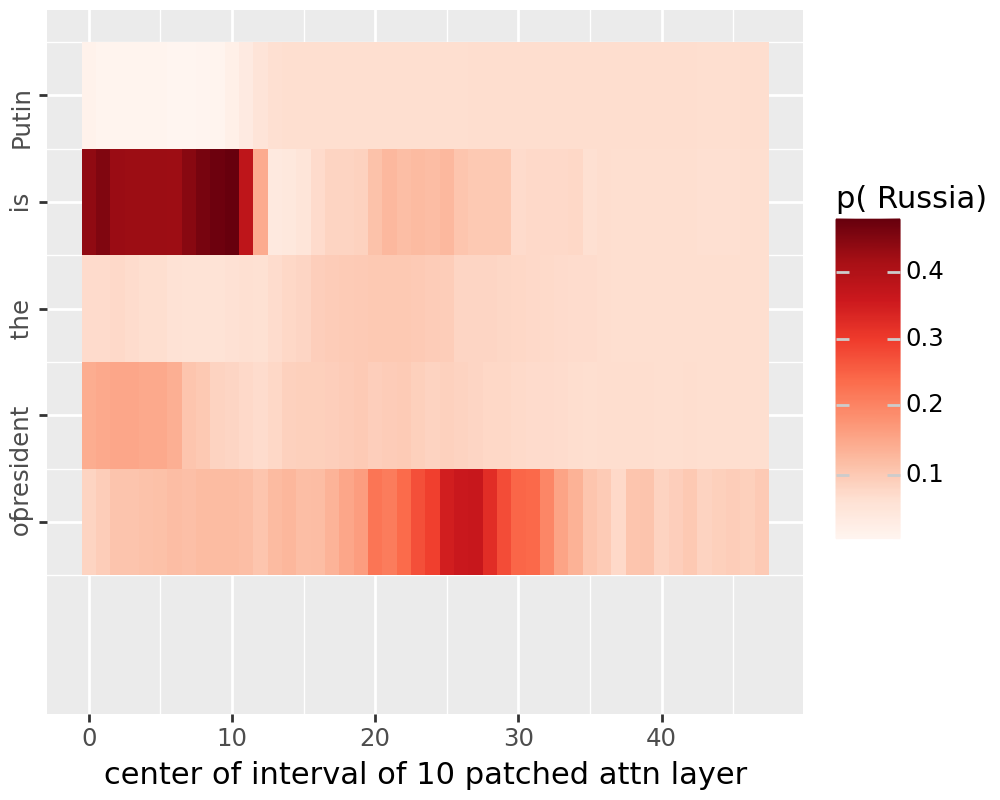

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/The Mona Lisa_pyvene_rome_block_output.pdf


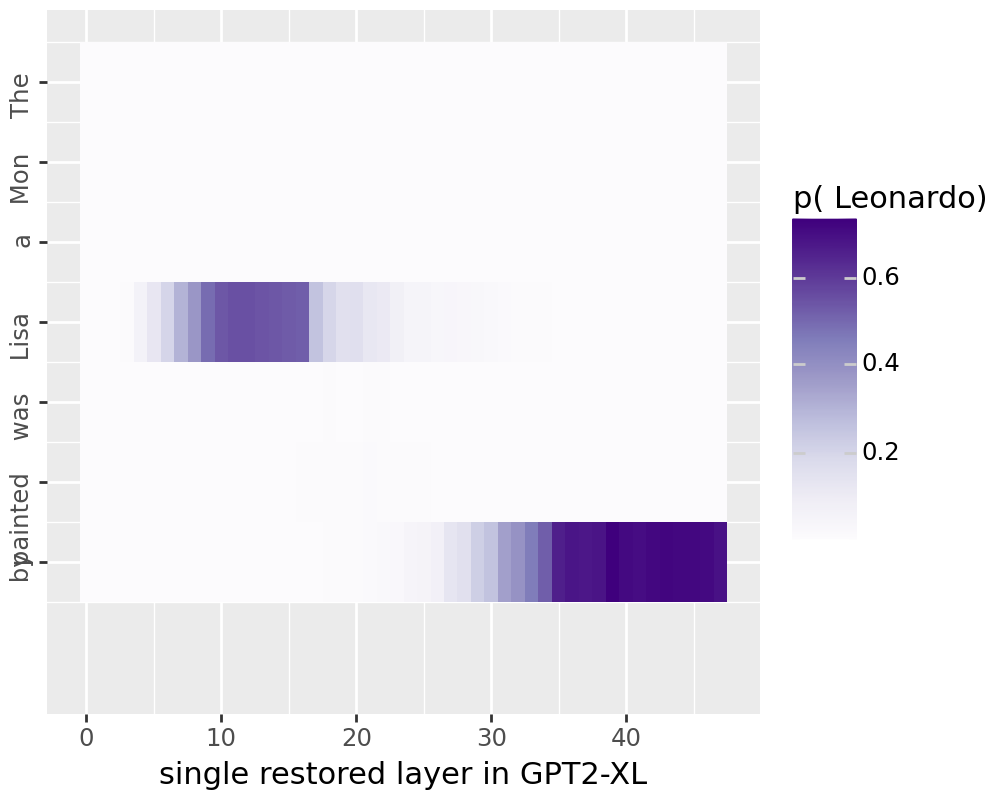

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/The Mona Lisa_pyvene_rome_mlp_activation.pdf


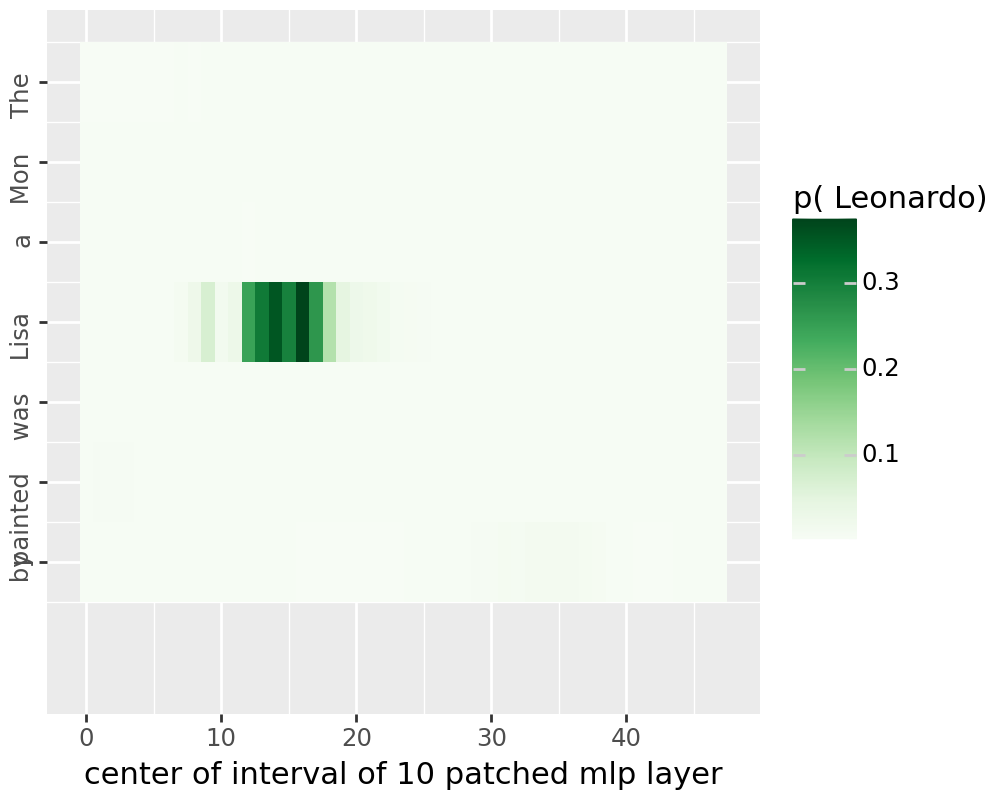

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/The Mona Lisa_pyvene_rome_attention_output.pdf


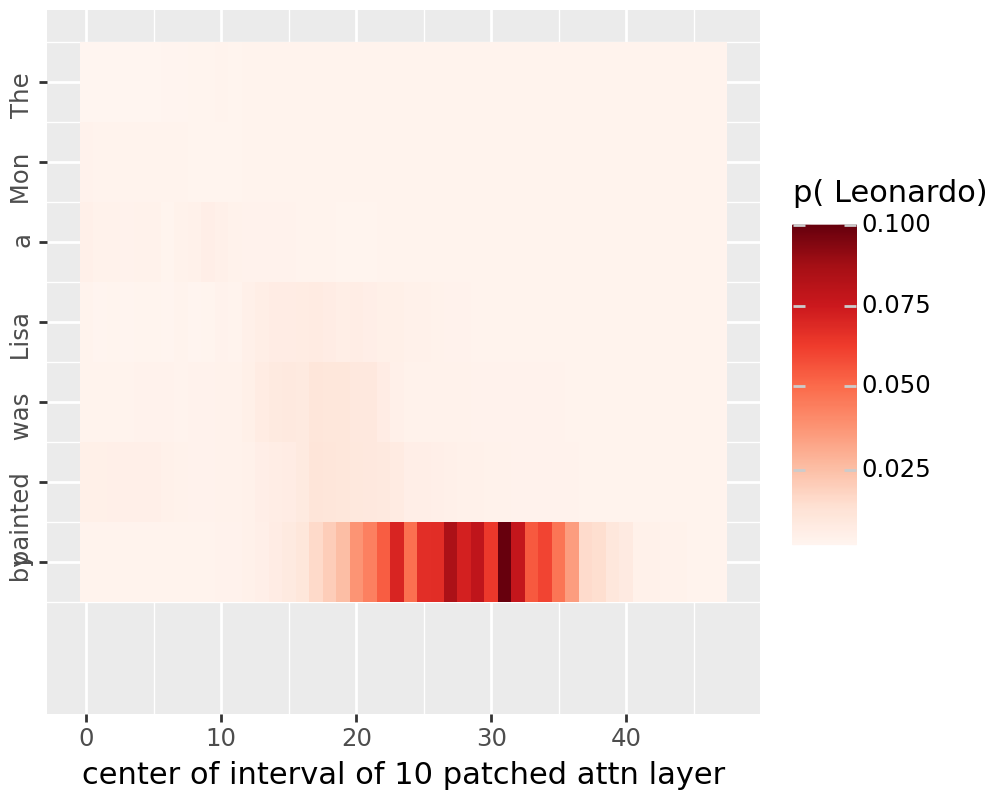

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/Half-Life_pyvene_rome_block_output.pdf


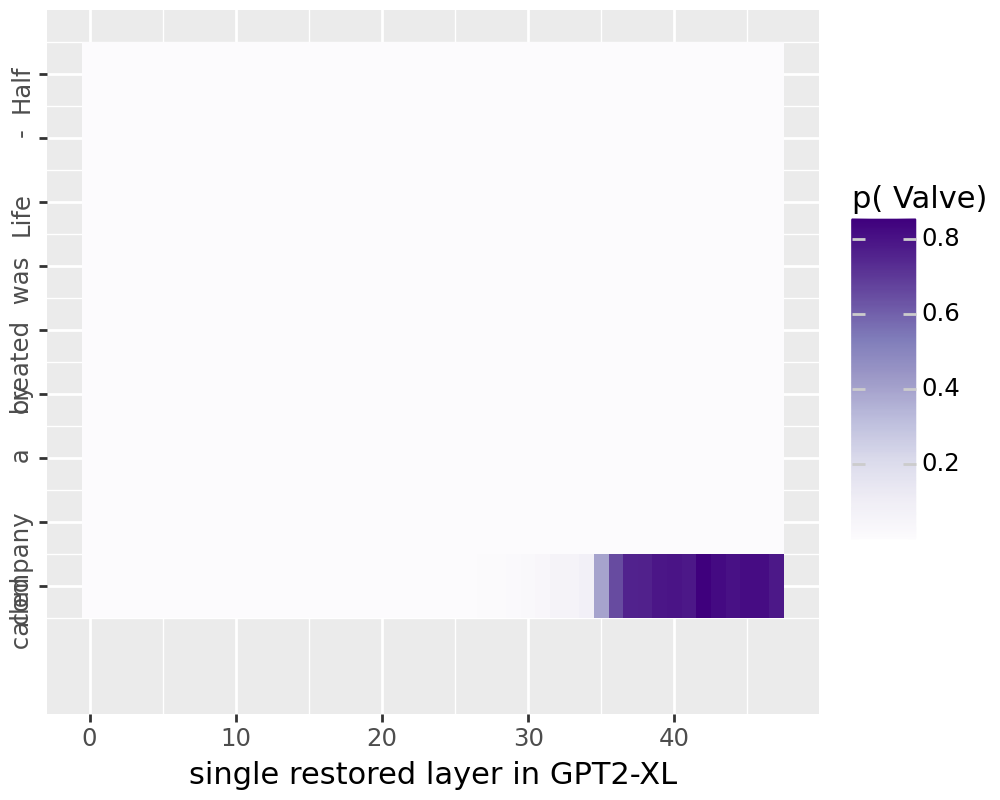

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/Half-Life_pyvene_rome_mlp_activation.pdf


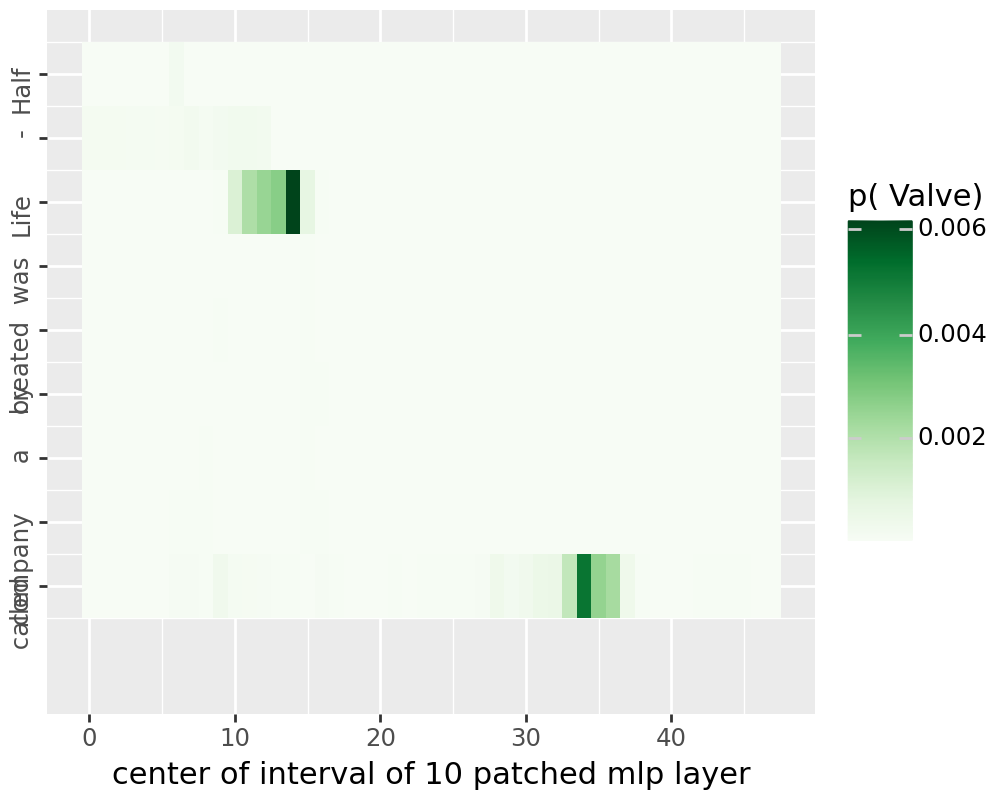

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/Half-Life_pyvene_rome_attention_output.pdf


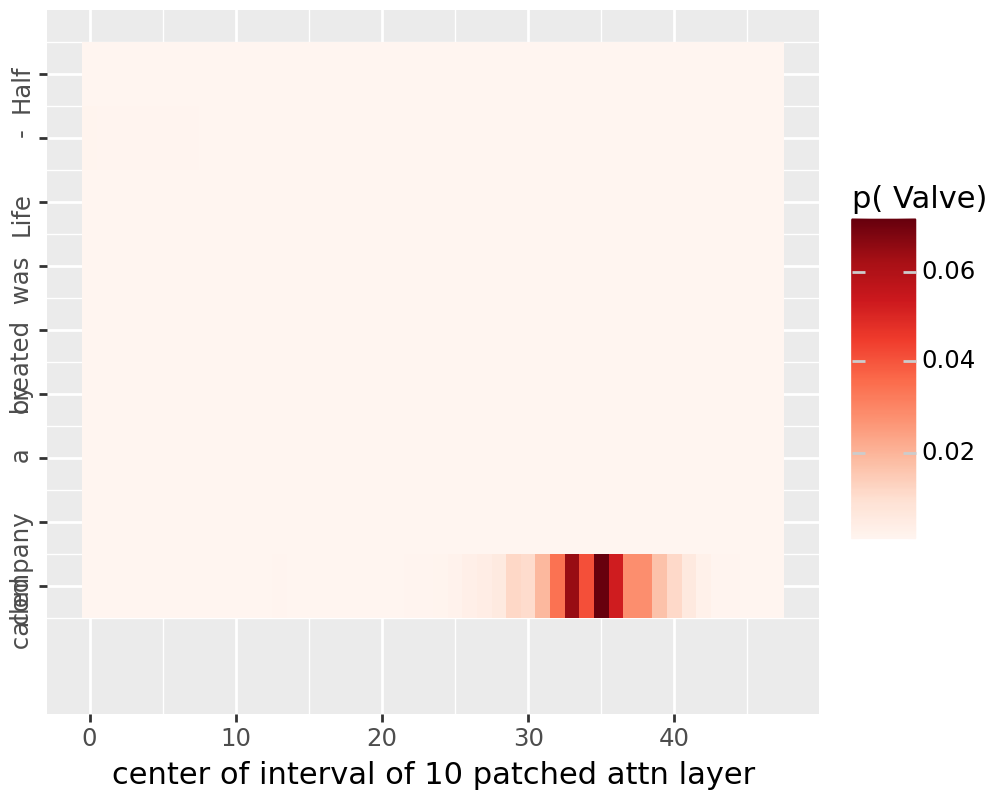

In [ ]:
from plotnine import *
import pandas as pd
for example in examples:
  subject = example['subject']
  sentence = example['sentence']
  answer = example['answer']
  for stream in ["block_output", "mlp_activation", "attention_output"]:
    df = pd.read_csv(f"./tutorial_data/{subject}_pyvene_rome_{stream}.csv")
    df["layer"] = df["layer"].astype(int)
    df["pos"] = df["pos"].astype(int)
    df[f"p({answer})"] = df["prob"].astype(float)

    tokenize_sentence = tokenizer.encode(sentence)
    decoded_sentence = [tokenizer.decode(tok) for tok in tokenize_sentence]
    custom_labels = decoded_sentence
    breaks = [i for i in range(len(custom_labels))]

    plot = (
        ggplot(df, aes(x="layer", y="pos"))
        + geom_tile(aes(fill=f"p({answer})"))
        + scale_fill_cmap(colors[stream])
        + xlab(titles[stream])
        + scale_y_reverse(
            limits=(-0.5, len(tokenize_sentence) + 0.5), #rozszerzyc zakres
            breaks=breaks, labels=custom_labels
        )
        + theme(figure_size=(5, 4))
        + ylab("")
        + theme(axis_text_y=element_text(angle=90, hjust=1))
    )
    # Save the plot to a file
    ggsave(
        plot, filename=f"./tutorial_data/{subject}_pyvene_rome_{stream}.pdf", dpi=200
    )
    # Display the plot in the notebook
    display(plot)

In [ ]:
!pip install datasets

In [7]:
from datasets import load_dataset

dataset = load_dataset("google/boolq")
print(dataset)

README.md:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.69M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9427 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3270 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'passage'],
        num_rows: 9427
    })
    validation: Dataset({
        features: ['question', 'answer', 'passage'],
        num_rows: 3270
    })
})


In [ ]:
def replace_answers(example):
    if example['answer'] is True:
        example['answer'] = "Yes"
    elif example['answer'] is False:
        example['answer'] = "No"
    return example

dataset = dataset.map(replace_answers)

Map:   0%|          | 0/9427 [00:00<?, ? examples/s]

Map:   0%|          | 0/3270 [00:00<?, ? examples/s]

In [ ]:
for i in range(10):
  print(dataset['train'][i]['question'])
  print(dataset['train'][i]['answer'])

do iran and afghanistan speak the same language
Yes
do good samaritan laws protect those who help at an accident
Yes
is windows movie maker part of windows essentials
Yes
is confectionary sugar the same as powdered sugar
Yes
is elder scrolls online the same as skyrim
No
can you use oyster card at epsom station
No
will there be a season 4 of da vinci's demons
No
is the federal court the same as the supreme court
No
did abraham lincoln write the letter in saving private ryan
Yes
is batman and robin a sequel to batman forever
Yes


In [8]:
examples2 = [
    {"question": "did abraham lincoln write the letter in saving private ryan", "sub_tokens": [1, 2, 3, 4], "id": 1},
    {"question": "do good samaritan laws protect those who help at an accident", "sub_tokens": [1, 2, 3, 4, 5], "id": 2},
    {"question": "is confectionary sugar the same as powdered sugar", "sub_tokens": [1, 2, 3, 4], "id": 3},
    {"question": "is batman and robin a sequel to batman forever", "sub_tokens": [1, 2, 3, 4, 5], "id": 4}
]

In [ ]:
examples3 = [
    {"question": "did abraham lincoln paint the mona lisa", "sub_tokens": [1, 2, 3, 4], "id": 1},
    {"question": "do good samaritan laws protect those who shoplift", "sub_tokens": [1, 2, 3, 4, 5], "id": 2},
    {"question": "is confectionary sugar the same as pepper spray", "sub_tokens": [1, 2, 3, 4], "id": 3},
    {"question": "is batman and robin a sequel to shrek", "sub_tokens": [1, 2, 3, 4, 5], "id": 4}
]

In [9]:
for example in examples2:
  sentence = example["question"]
  subject_tokens_positions = example["sub_tokens"]
  id = example["id"]
  sentence_tokens = tokenizer.encode(sentence)

  answer_token = tokenizer.encode(" yes")[0]

  print(sentence)
  #corrupt
  base = tokenizer(sentence, return_tensors="pt").to(device)
  config = corrupted_config(type(gpt), len(subject_tokens_positions))
  intervenable = IntervenableModel(config, gpt)
  _, counterfactual_outputs = intervenable(
      base, unit_locations={"base": ([[subject_tokens_positions]])}
  )
  distrib = embed_to_distrib(gpt, counterfactual_outputs.last_hidden_state, logits=False)

  for stream in ["block_output", "mlp_activation", "attention_output"]:
    data = []
    for layer_i in tqdm(range(gpt.config.n_layer)):
        for pos_i in range(len(sentence_tokens)):
            config = restore_corrupted_with_interval_config(
                layer_i, stream,
                window=1 if stream == "block_output" else 10, noise_dim=len(subject_tokens_positions)
            )
            n_restores = len(config.representations) - 1
            intervenable = IntervenableModel(config, gpt)
            _, counterfactual_outputs = intervenable(
                base,
                [None] + [base]*n_restores,
                {
                    "sources->base": (
                        [None] + [[[pos_i]]]*n_restores,
                        [[subject_tokens_positions]] + [[[pos_i]]]*n_restores,
                    )
                },
            )
            distrib = embed_to_distrib(
                gpt, counterfactual_outputs.last_hidden_state, logits=False
            )

            prob = distrib[0][-1][answer_token].detach().cpu().item()
            data.append({"layer": layer_i, "pos": pos_i, "prob": prob})
    df = pd.DataFrame(data)
    df.to_csv(f"./tutorial_data/yes_{id}_pyvene_rome_{stream}.csv")

did abraham lincoln write the letter in saving private ryan


100%|██████████| 48/48 [04:22<00:00,  5.46s/it]


do good samaritan laws protect those who help at an accident


100%|██████████| 48/48 [04:22<00:00,  5.47s/it]


is confectionary sugar the same as powdered sugar


100%|██████████| 48/48 [03:19<00:00,  4.16s/it]


is batman and robin a sequel to batman forever


100%|██████████| 48/48 [04:01<00:00,  5.02s/it]


In [ ]:
!zip -r /content/data.zip /content/tutorial_data

updating: content/tutorial_data/ (stored 0%)
updating: content/tutorial_data/The Mona Lisa_pyvene_rome_mlp_activation.csv (deflated 55%)
updating: content/tutorial_data/The Mona Lisa_pyvene_rome_block_output.csv (deflated 55%)
updating: content/tutorial_data/Warsaw_pyvene_rome_block_output.csv (deflated 55%)
updating: content/tutorial_data/The Mona Lisa_pyvene_rome_attention_output.csv (deflated 55%)
updating: content/tutorial_data/Warsaw_pyvene_rome_attention_output.csv (deflated 56%)
updating: content/tutorial_data/Putin_pyvene_rome_mlp_activation.csv (deflated 53%)
updating: content/tutorial_data/Putin_pyvene_rome_attention_output.csv (deflated 53%)
updating: content/tutorial_data/Half-Life_pyvene_rome_mlp_activation.csv (deflated 54%)
updating: content/tutorial_data/Half-Life_pyvene_rome_attention_output.csv (deflated 54%)
updating: content/tutorial_data/Half-Life_pyvene_rome_block_output.csv (deflated 54%)
updating: content/tutorial_data/Putin_pyvene_rome_block_output.csv (deflate

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_1_pyvene_rome_block_output.pdf


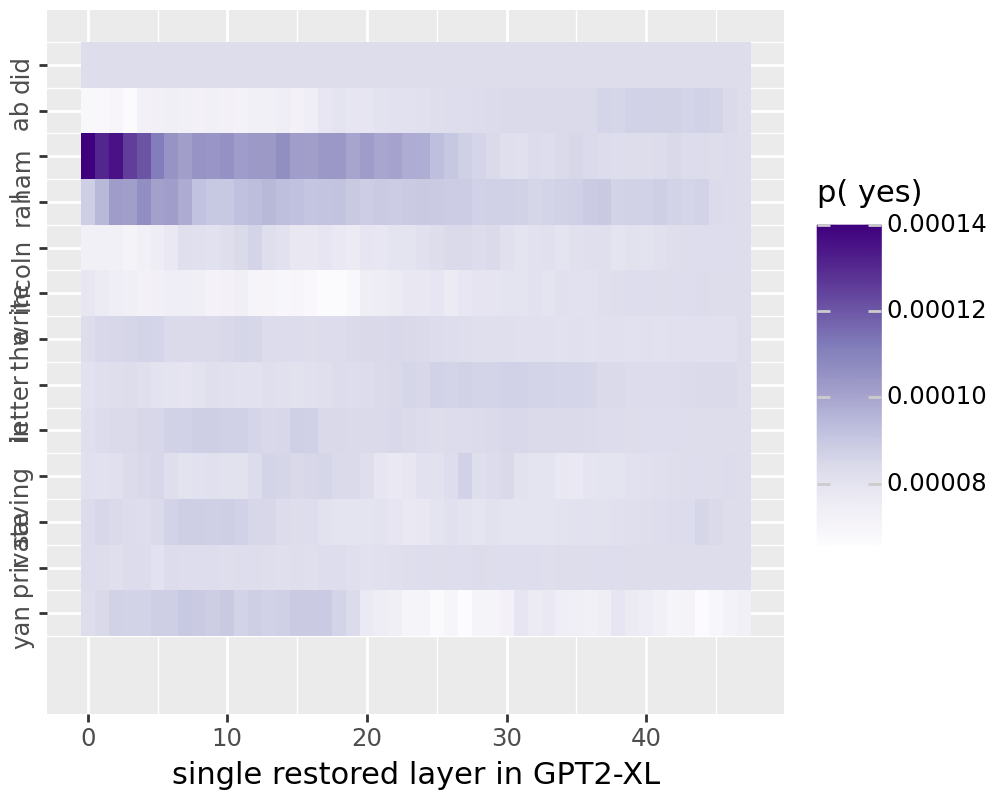

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_1_pyvene_rome_mlp_activation.pdf


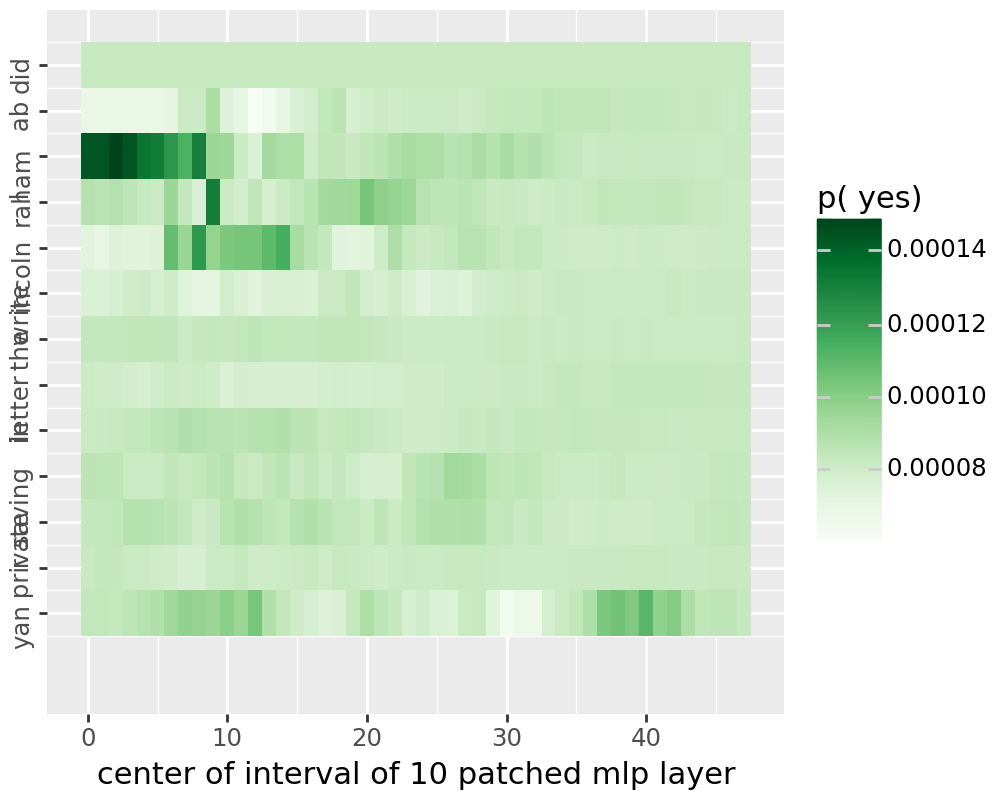

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_1_pyvene_rome_attention_output.pdf


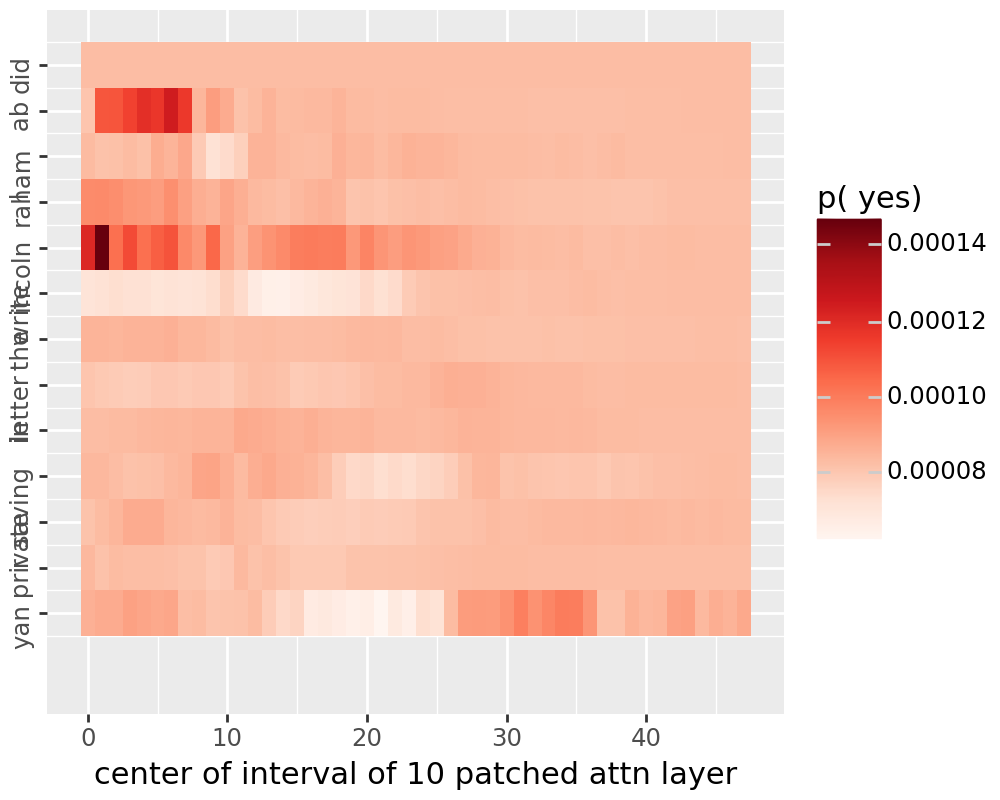

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_2_pyvene_rome_block_output.pdf


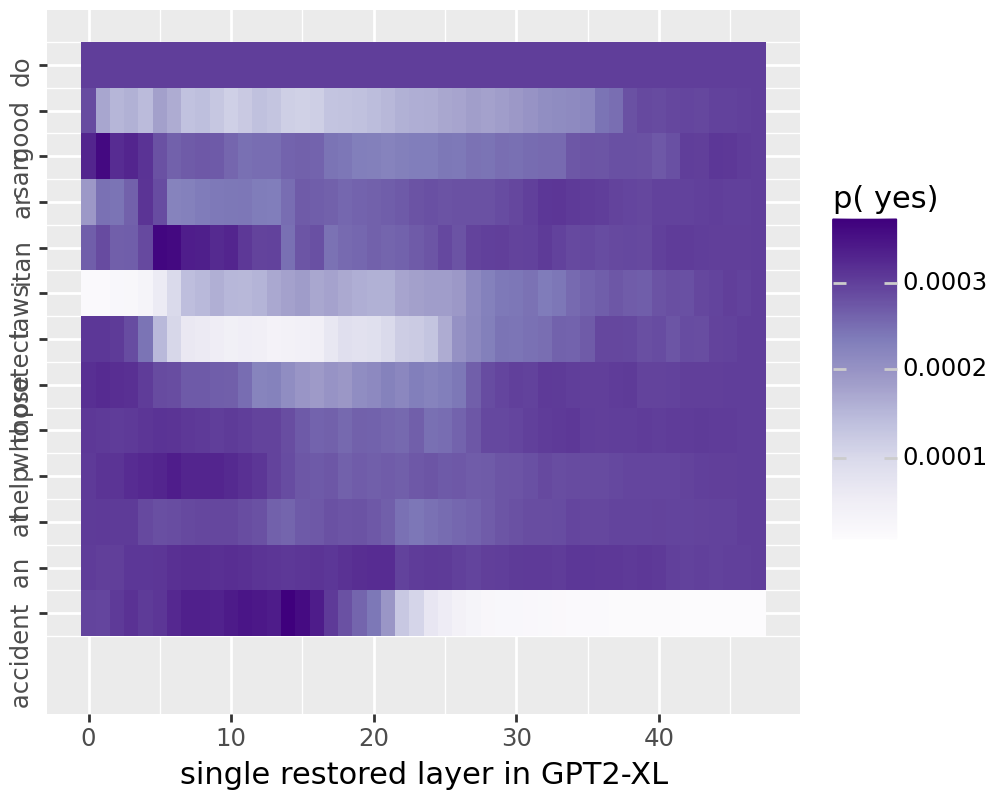

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_2_pyvene_rome_mlp_activation.pdf


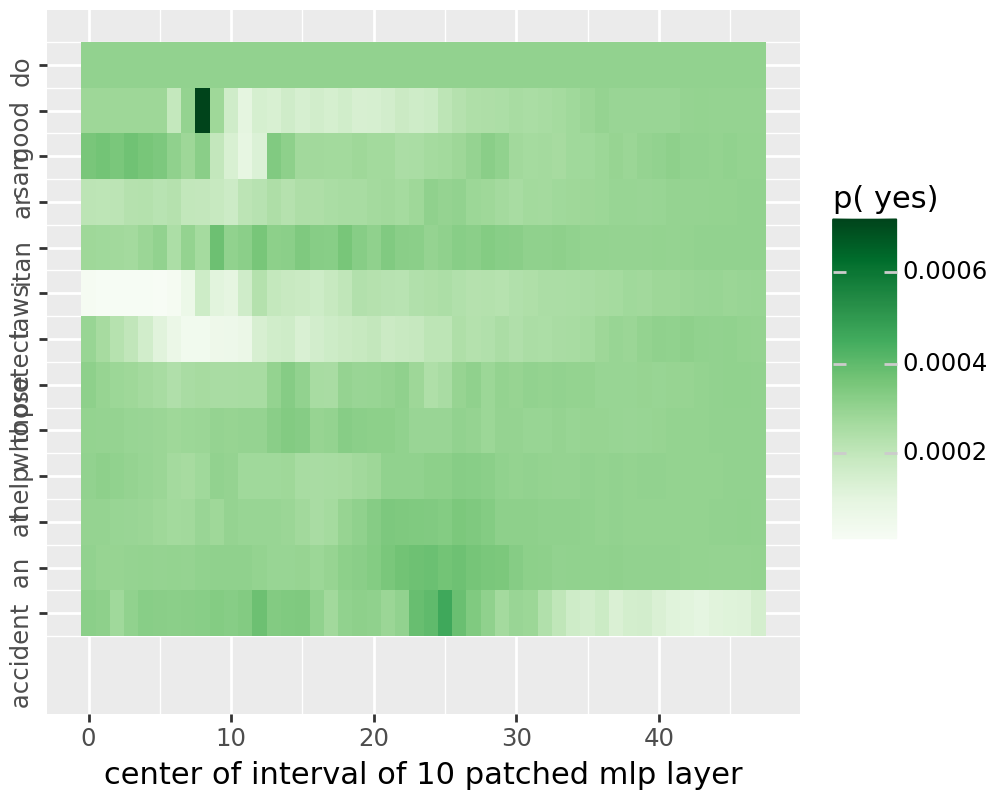

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_2_pyvene_rome_attention_output.pdf


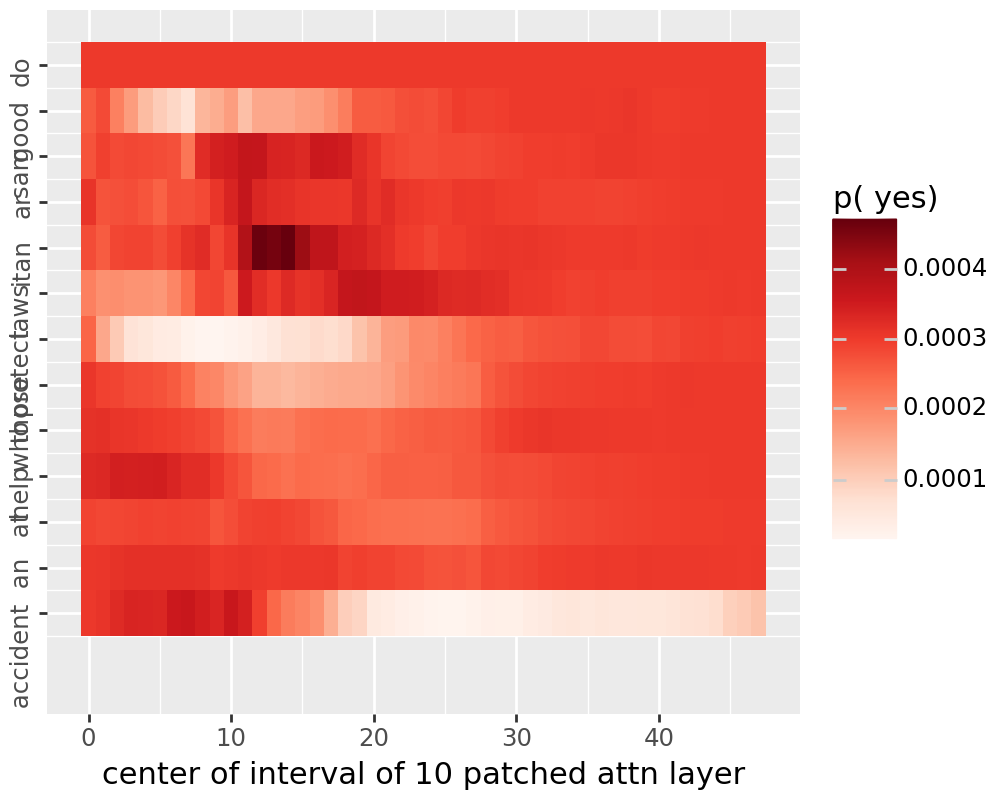

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_3_pyvene_rome_block_output.pdf


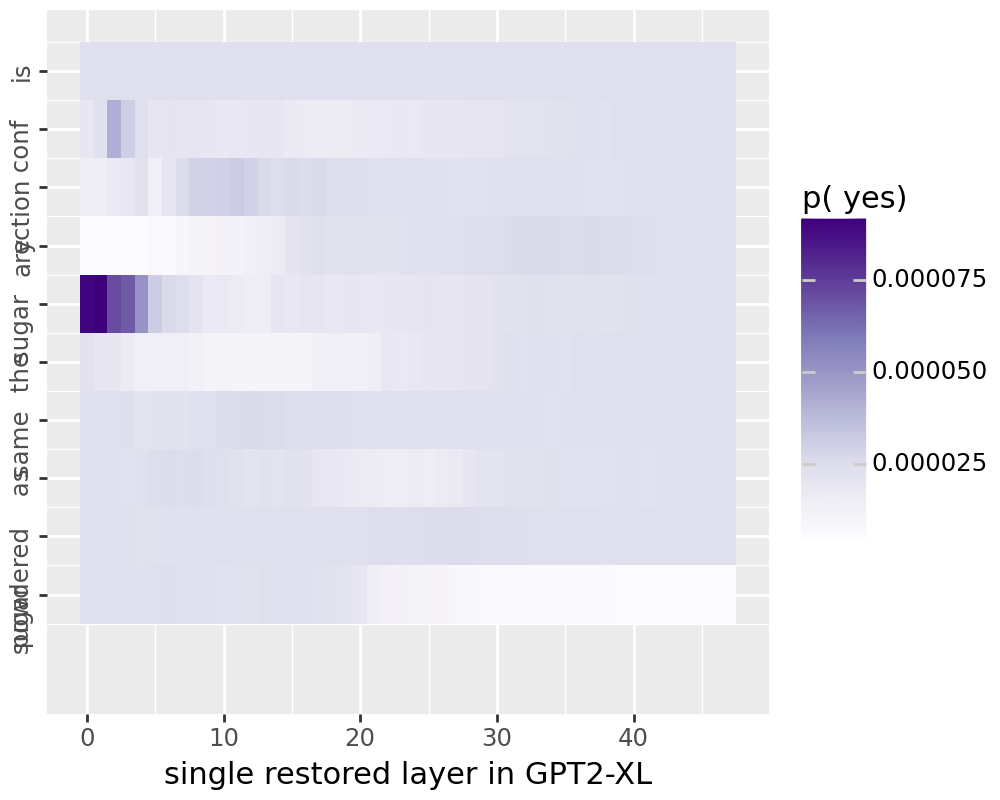

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_3_pyvene_rome_mlp_activation.pdf


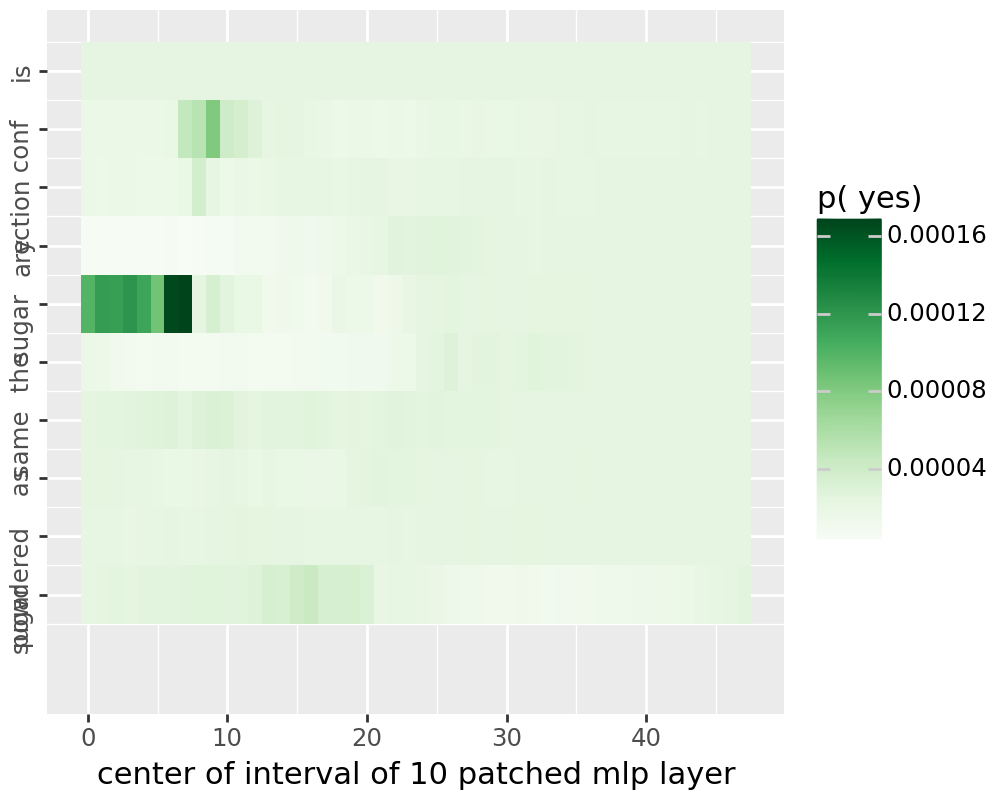

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_3_pyvene_rome_attention_output.pdf


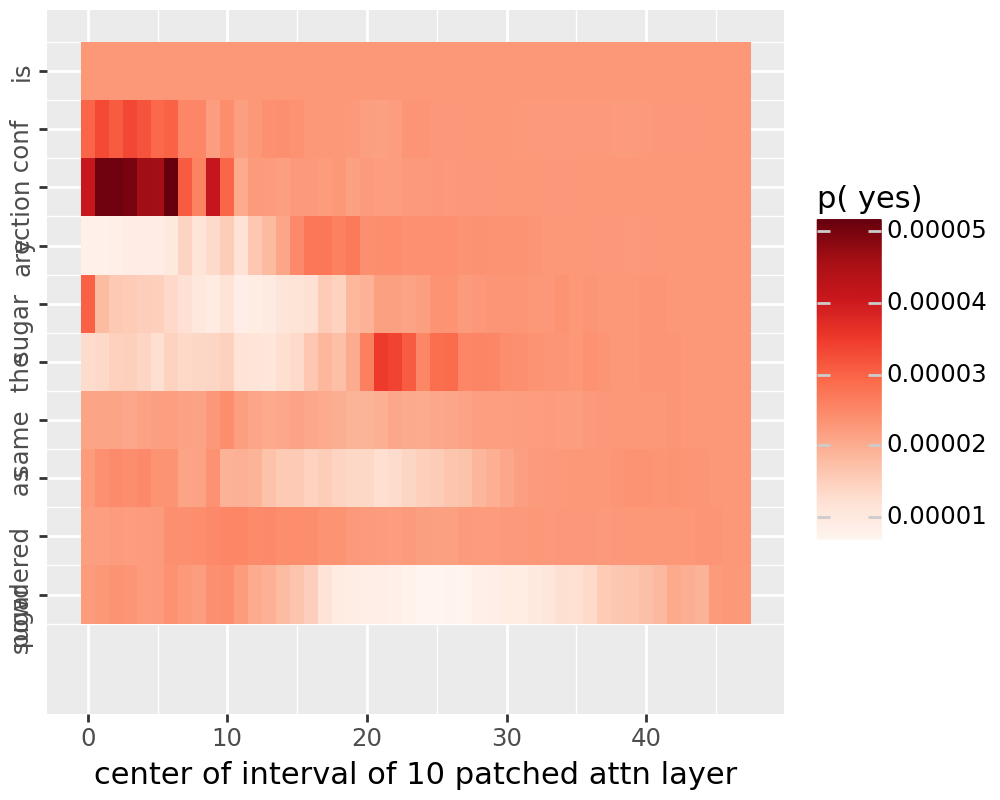

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_4_pyvene_rome_block_output.pdf


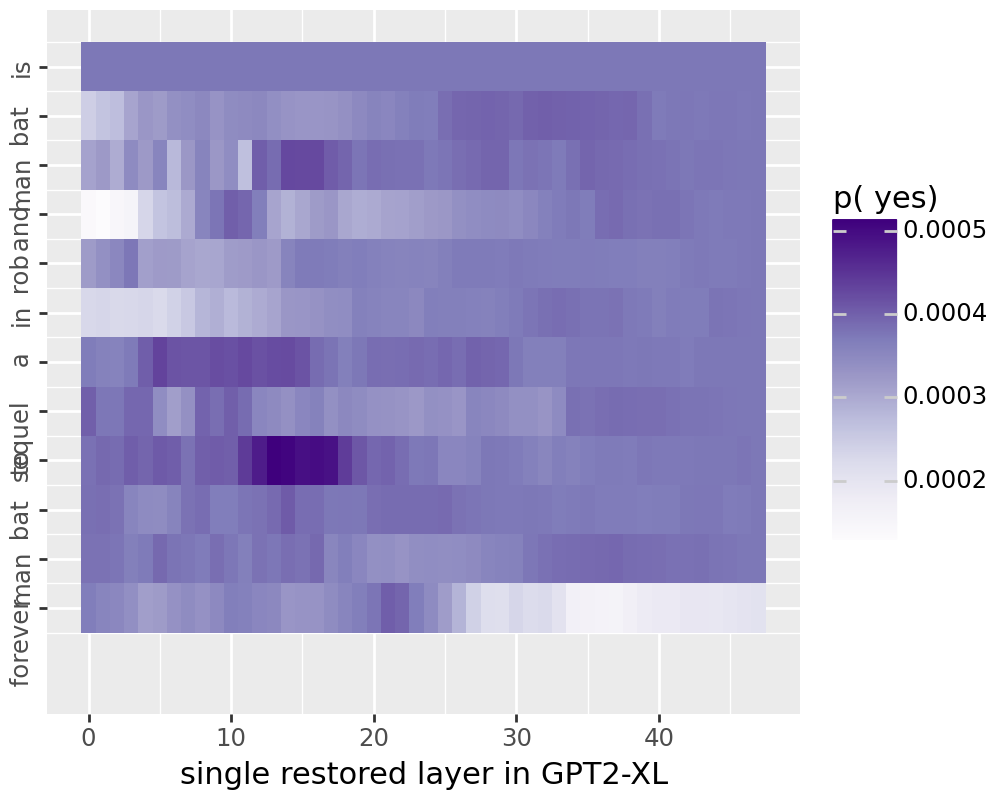

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_4_pyvene_rome_mlp_activation.pdf


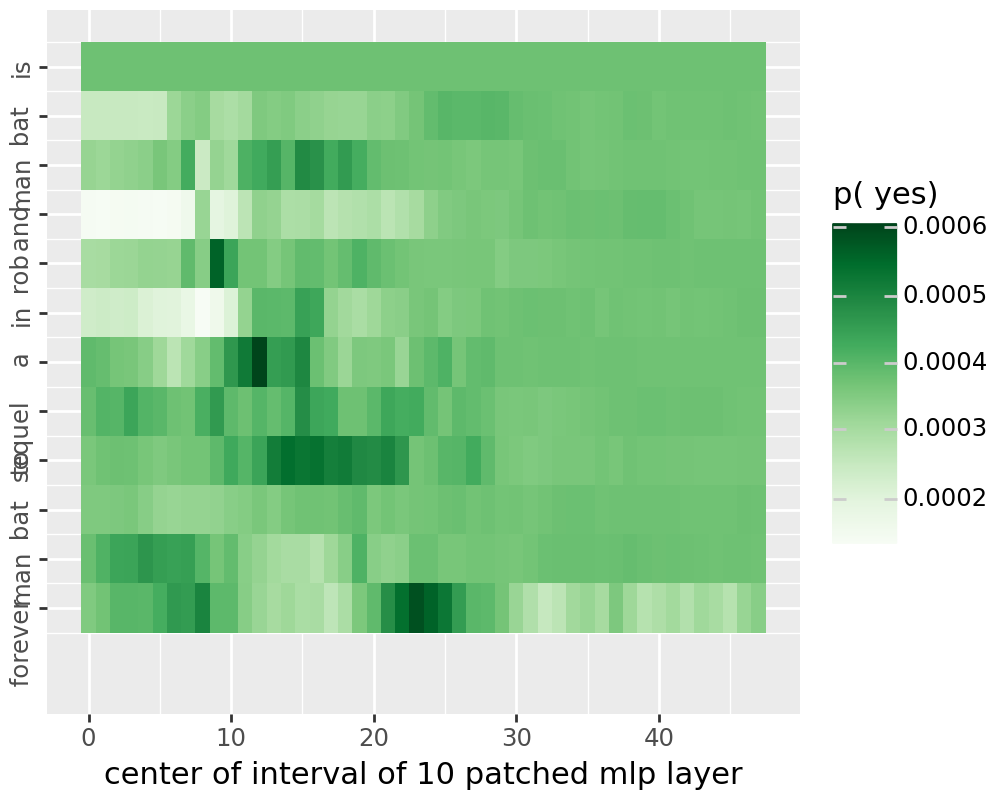

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_4_pyvene_rome_attention_output.pdf


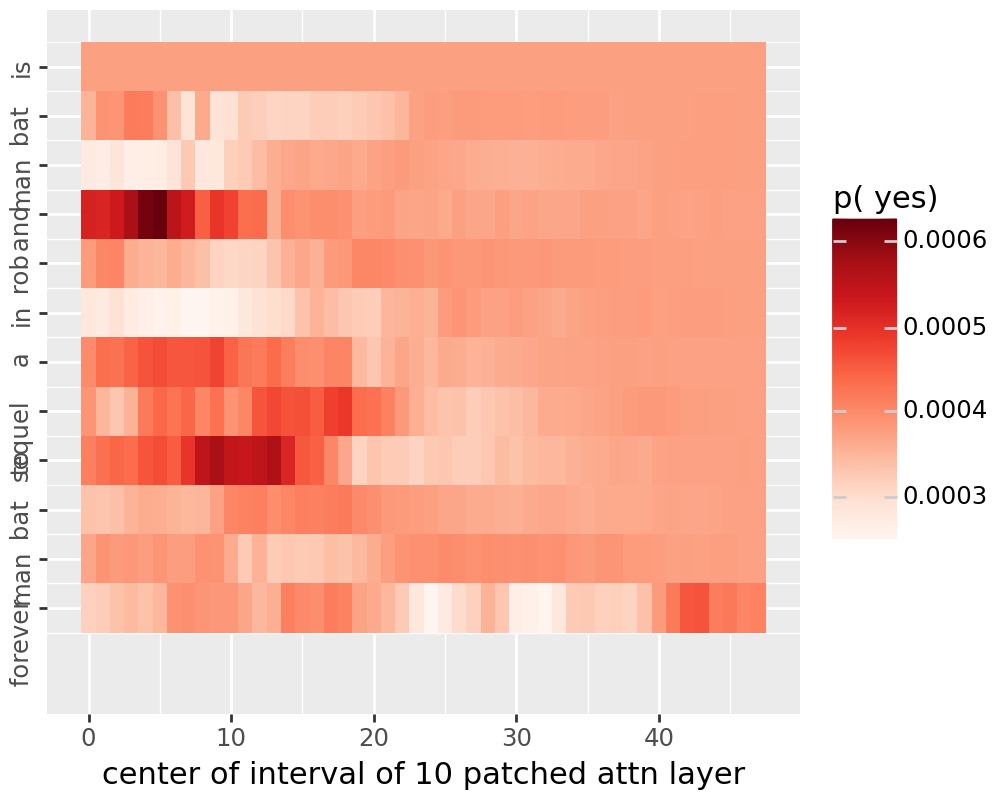

In [10]:
from plotnine import *
import pandas as pd
for example in examples2:
  id = example["id"]
  sentence = example['question']
  answer = " yes"
  for stream in ["block_output", "mlp_activation", "attention_output"]:
    df = pd.read_csv(f"./tutorial_data/yes_{id}_pyvene_rome_{stream}.csv")
    df["layer"] = df["layer"].astype(int)
    df["pos"] = df["pos"].astype(int)
    df[f"p({answer})"] = df["prob"].astype(float)

    tokenize_sentence = tokenizer.encode(sentence)
    decoded_sentence = [tokenizer.decode(tok) for tok in tokenize_sentence]
    custom_labels = decoded_sentence
    breaks = [i for i in range(len(custom_labels))]

    plot = (
        ggplot(df, aes(x="layer", y="pos"))
        + geom_tile(aes(fill=f"p({answer})"))
        + scale_fill_cmap(colors[stream])
        + xlab(titles[stream])
        + scale_y_reverse(
            limits=(-0.5, len(tokenize_sentence) + 0.5), #rozszerzyc zakres
            breaks=breaks, labels=custom_labels
        )
        + theme(figure_size=(5, 4))
        + ylab("")
        + theme(axis_text_y=element_text(angle=90, hjust=1))
    )
    # Save the plot to a file
    ggsave(
        plot, filename=f"./tutorial_data/yes_{id}_pyvene_rome_{stream}.pdf", dpi=200
    )
    # Display the plot in the notebook
    display(plot)

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_1_pyvene_rome_block_output.pdf


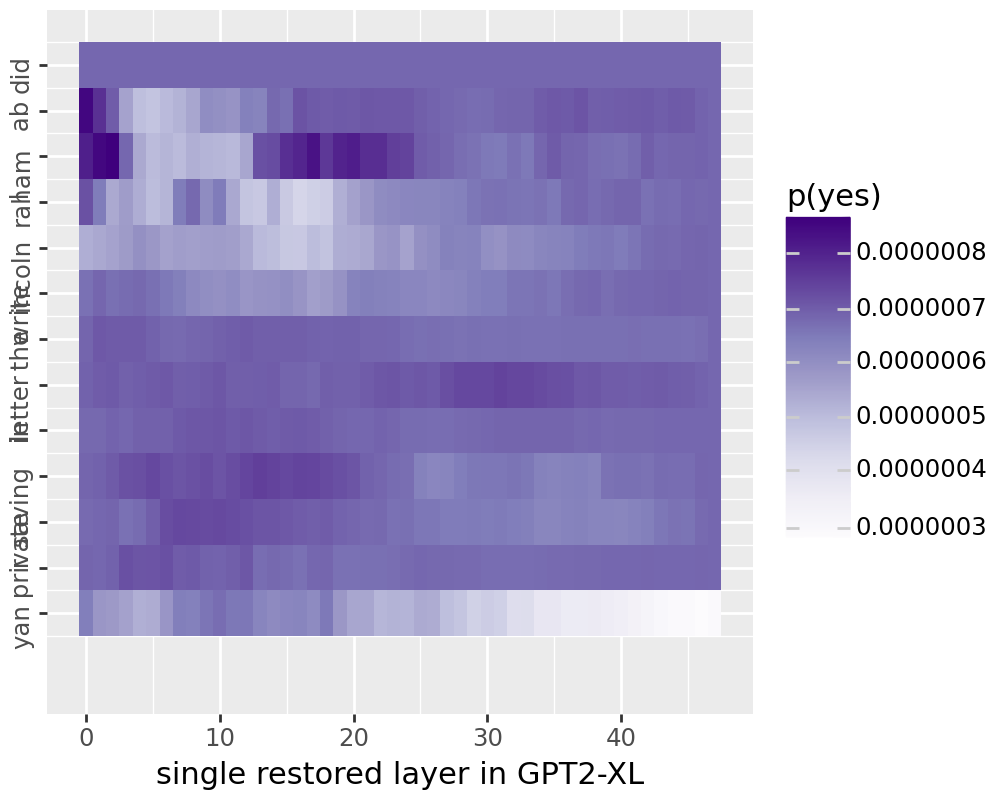

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_1_pyvene_rome_mlp_activation.pdf


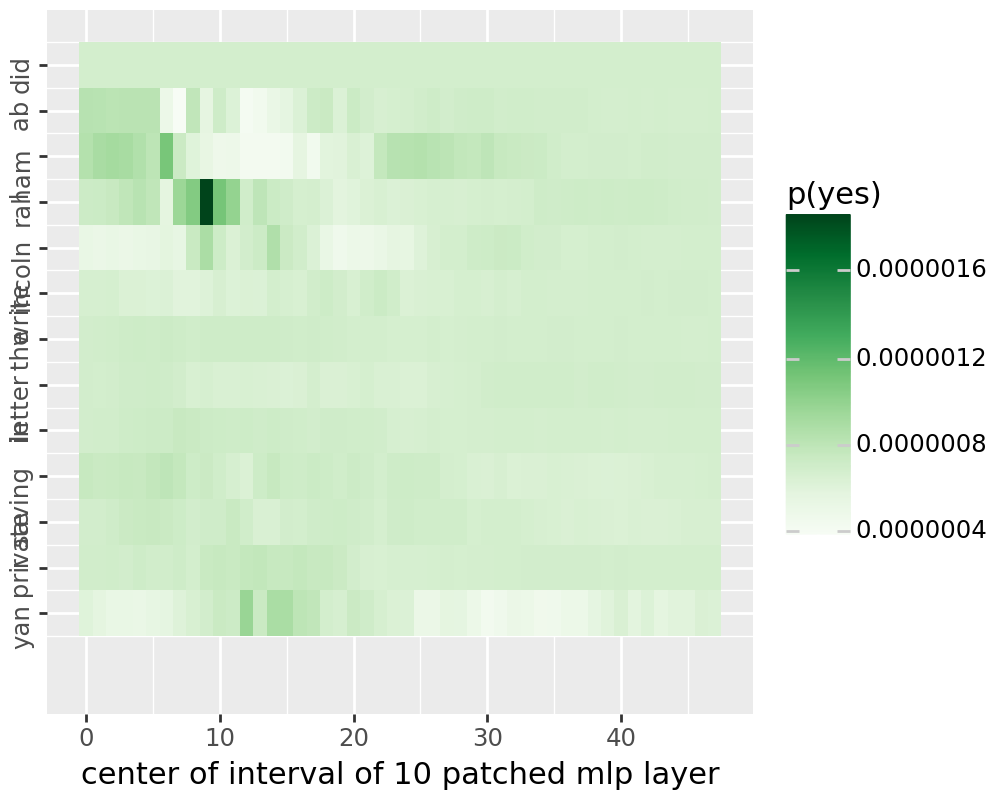

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_1_pyvene_rome_attention_output.pdf


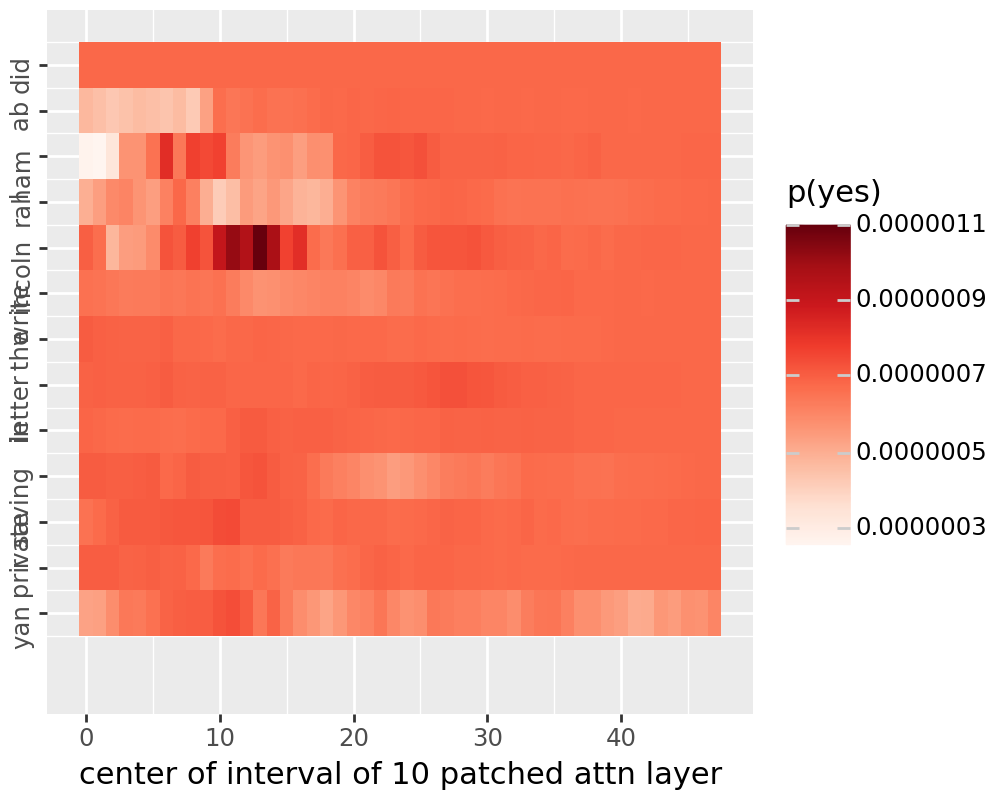

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_2_pyvene_rome_block_output.pdf


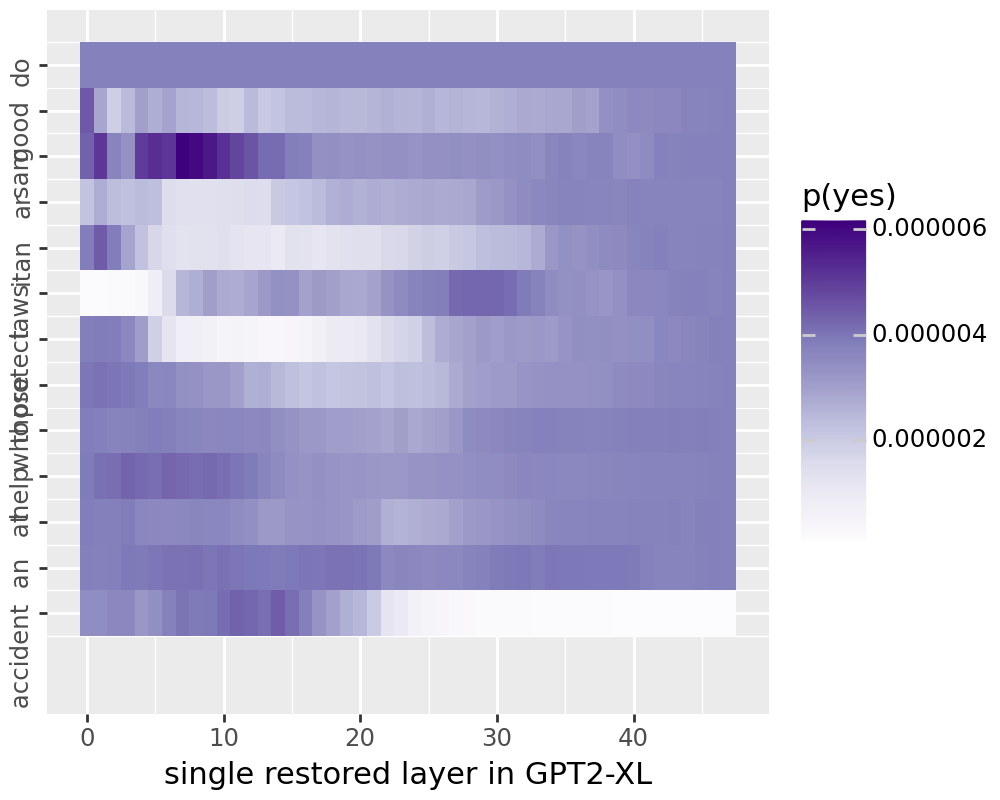

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_2_pyvene_rome_mlp_activation.pdf


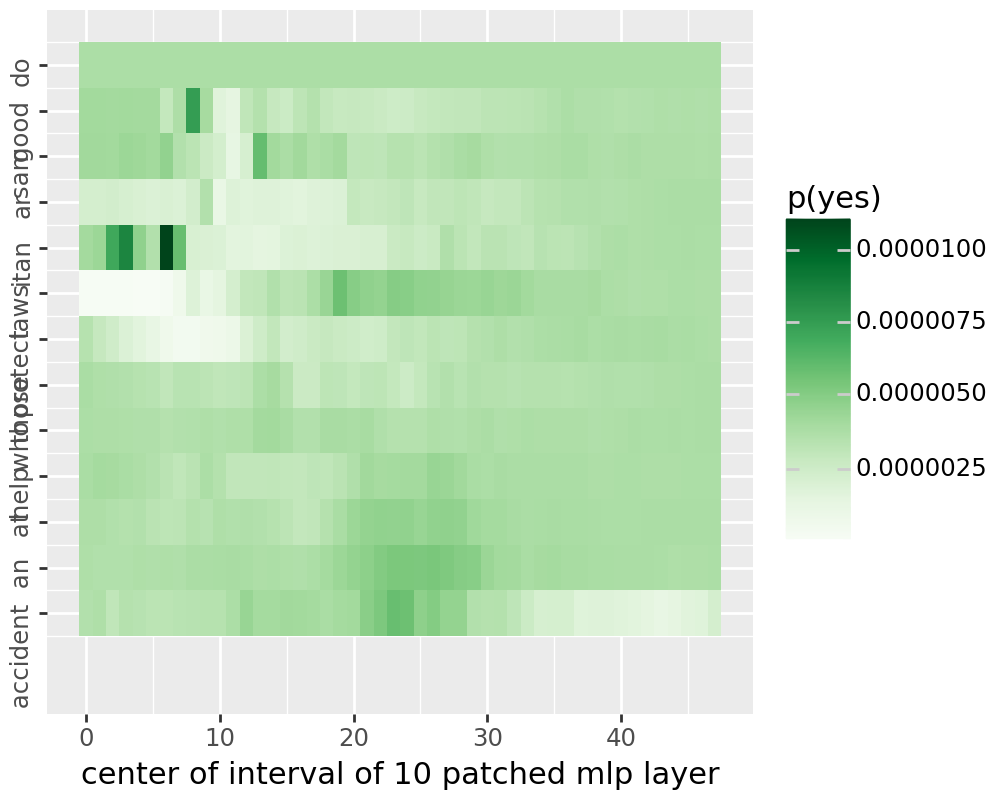

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_2_pyvene_rome_attention_output.pdf


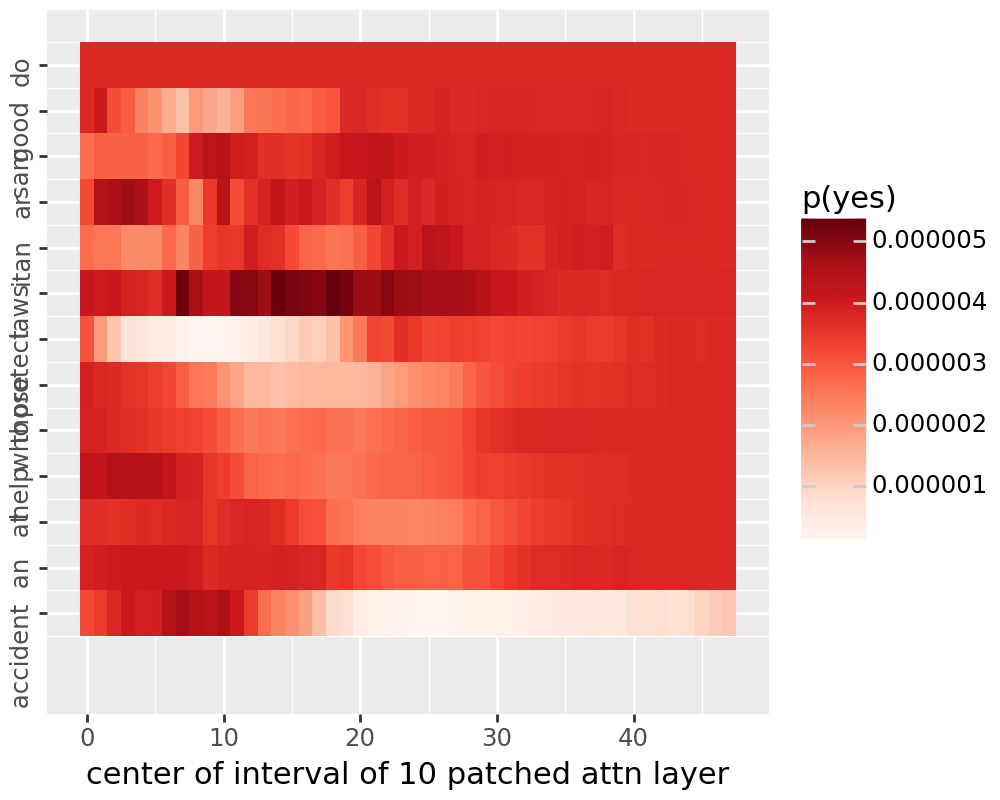

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_3_pyvene_rome_block_output.pdf


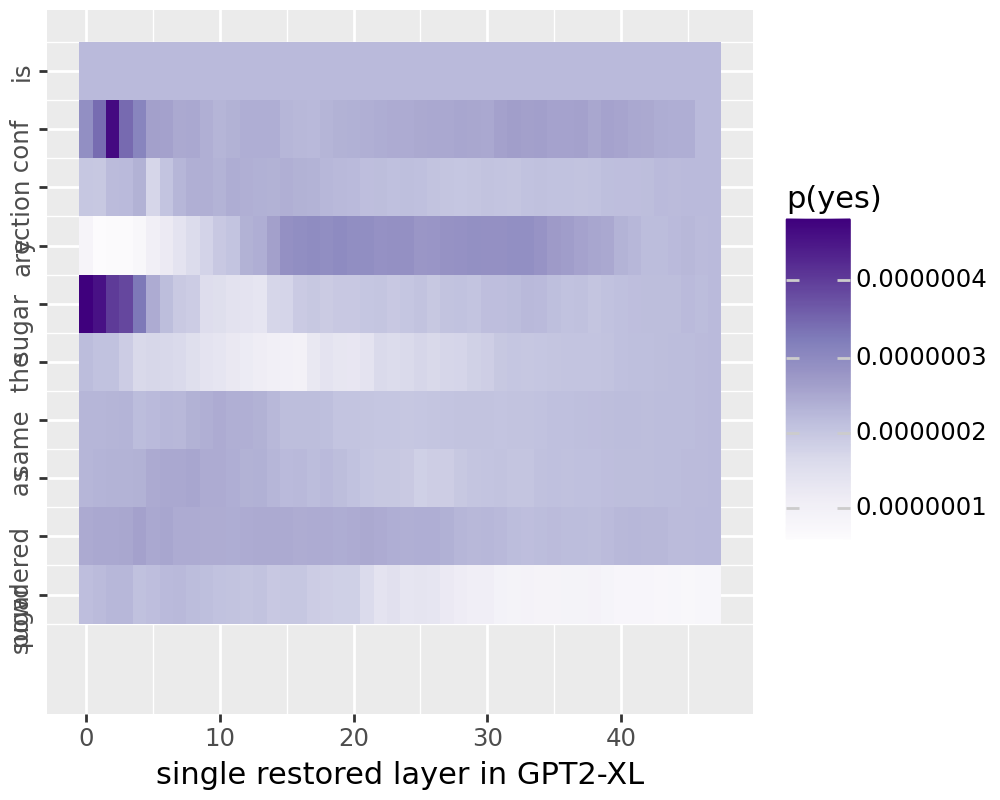

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_3_pyvene_rome_mlp_activation.pdf


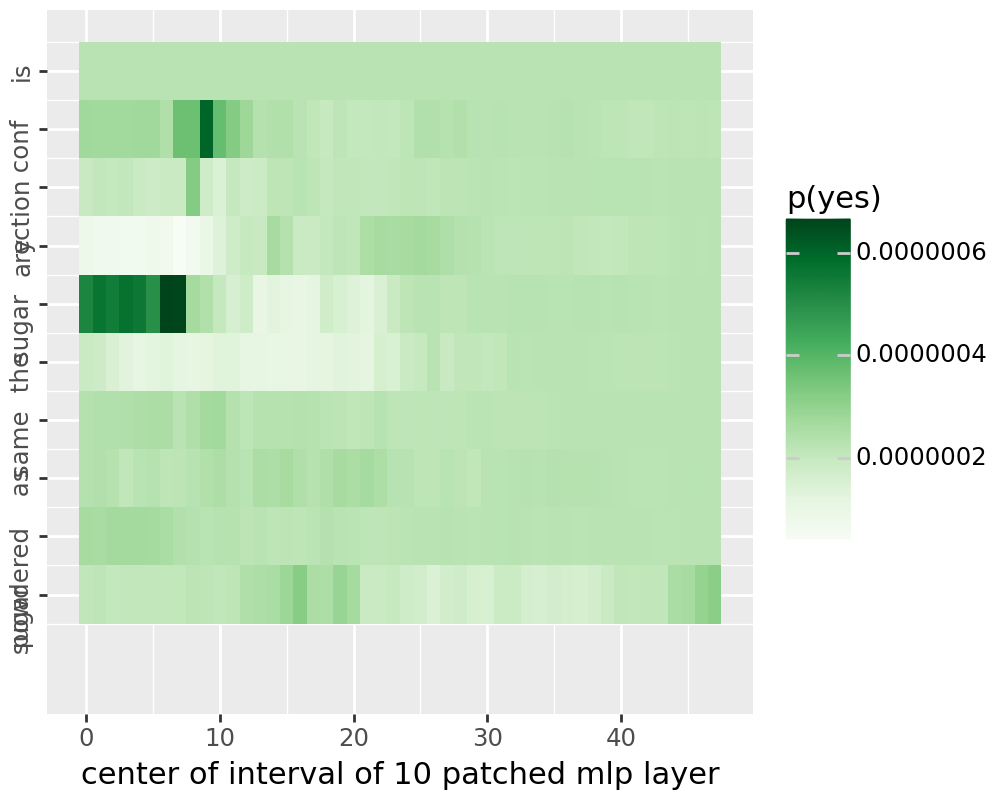

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_3_pyvene_rome_attention_output.pdf


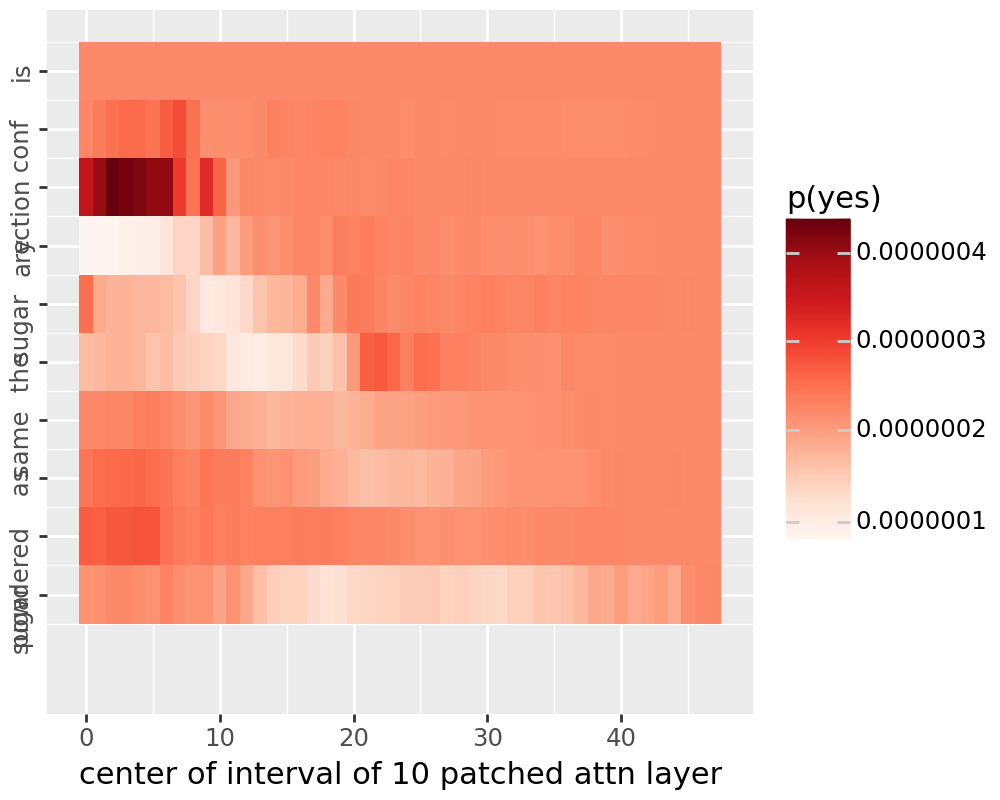

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_4_pyvene_rome_block_output.pdf


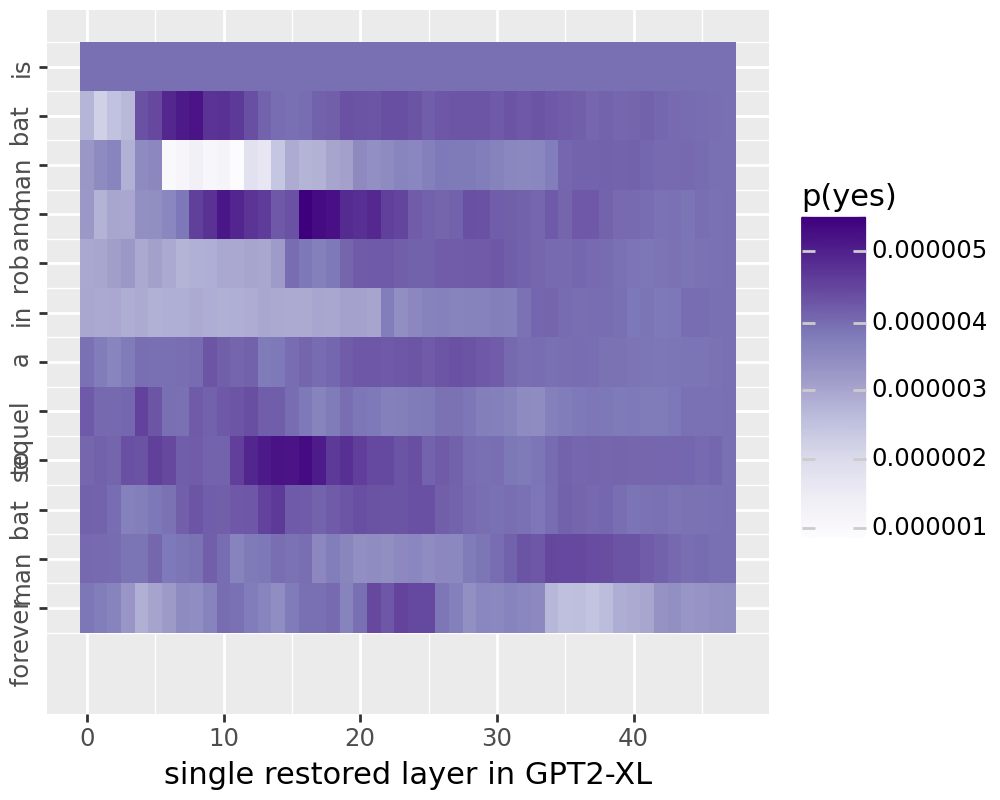

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_4_pyvene_rome_mlp_activation.pdf


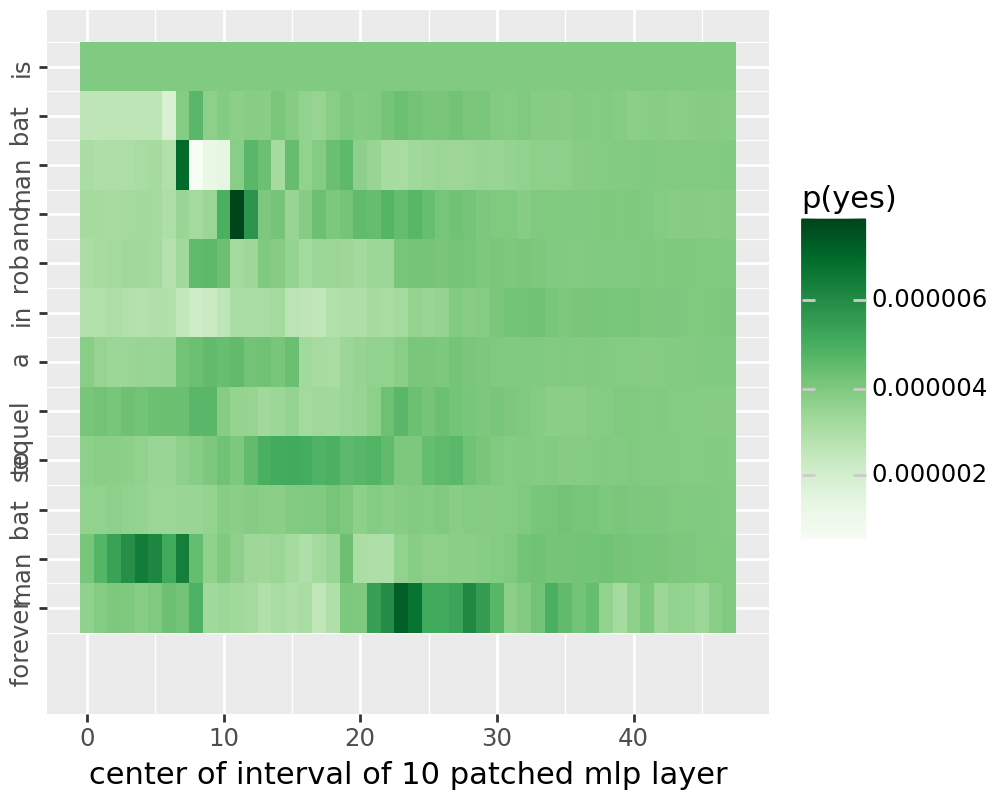

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_4_pyvene_rome_attention_output.pdf


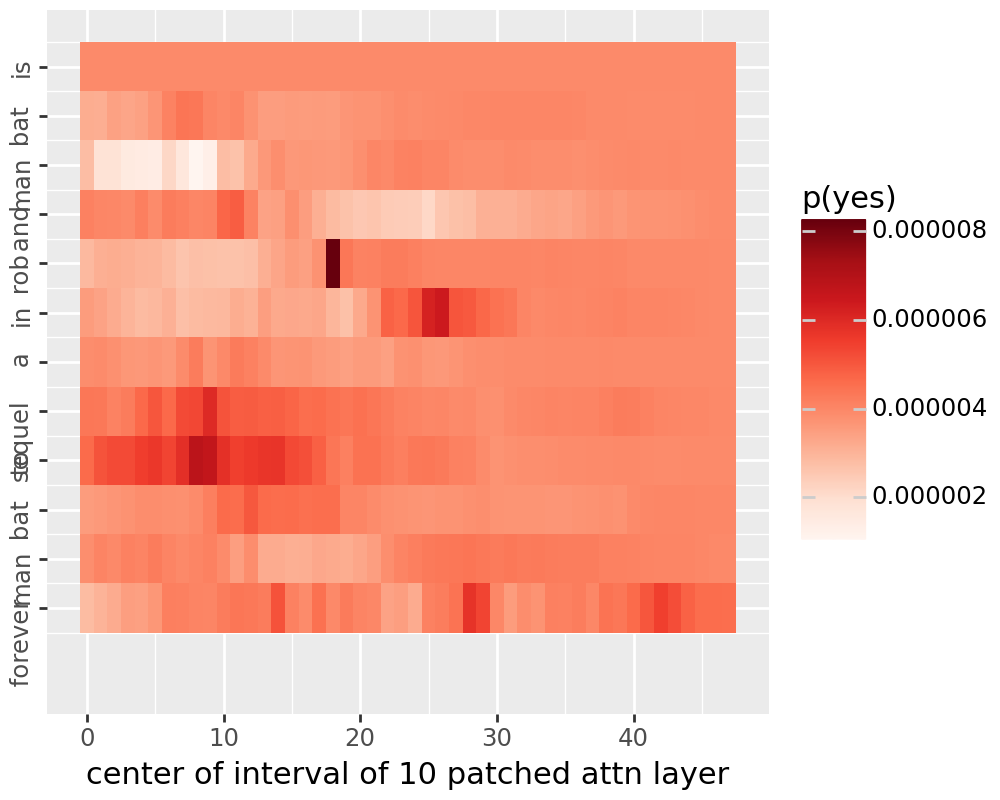

In [ ]:
from plotnine import *
import pandas as pd
for example in examples2:
  id = example["id"]
  sentence = example['question']
  answer = "yes"
  for stream in ["block_output", "mlp_activation", "attention_output"]:
    df = pd.read_csv(f"./tutorial_data/yes_{id}_pyvene_rome_{stream}.csv")
    df["layer"] = df["layer"].astype(int)
    df["pos"] = df["pos"].astype(int)
    df[f"p({answer})"] = df["prob"].astype(float)

    tokenize_sentence = tokenizer.encode(sentence)
    decoded_sentence = [tokenizer.decode(tok) for tok in tokenize_sentence]
    custom_labels = decoded_sentence
    breaks = [i for i in range(len(custom_labels))]

    plot = (
        ggplot(df, aes(x="layer", y="pos"))
        + geom_tile(aes(fill=f"p({answer})"))
        + scale_fill_cmap(colors[stream])
        + xlab(titles[stream])
        + scale_y_reverse(
            limits=(-0.5, len(tokenize_sentence) + 0.5), #rozszerzyc zakres
            breaks=breaks, labels=custom_labels
        )
        + theme(figure_size=(5, 4))
        + ylab("")
        + theme(axis_text_y=element_text(angle=90, hjust=1))
    )
    # Save the plot to a file
    ggsave(
        plot, filename=f"./tutorial_data/yes_{id}_pyvene_rome_{stream}.pdf", dpi=200
    )
    # Display the plot in the notebook
    display(plot)

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_1_pyvene_rome_block_output.pdf


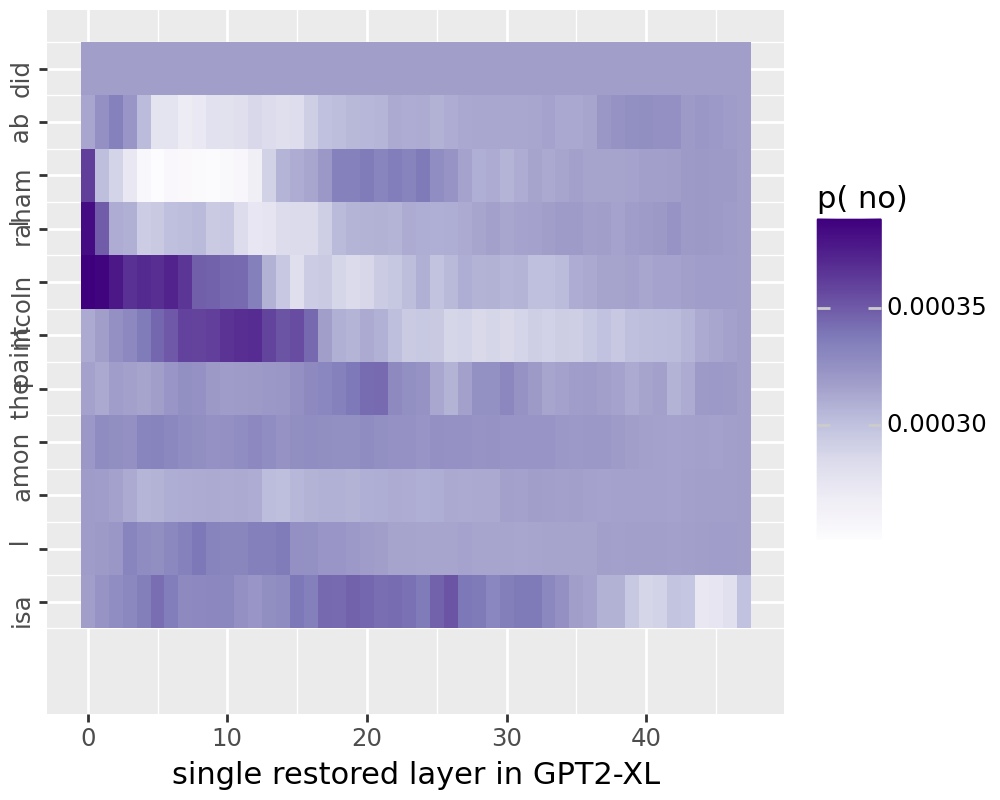

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_1_pyvene_rome_mlp_activation.pdf


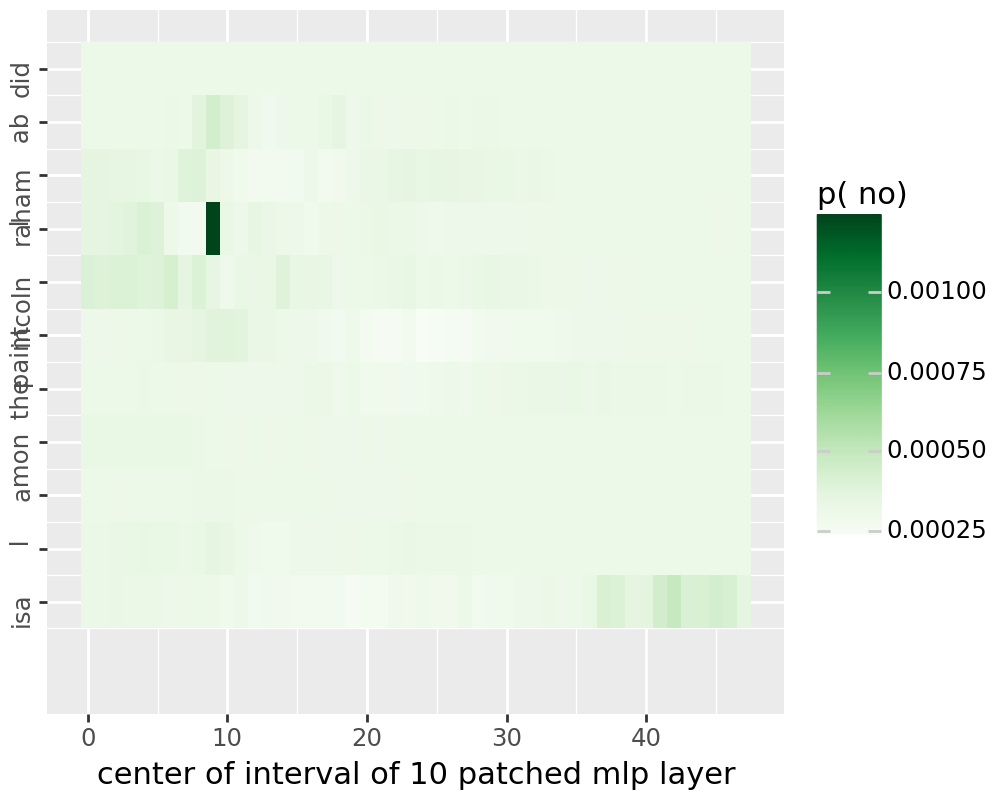

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_1_pyvene_rome_attention_output.pdf


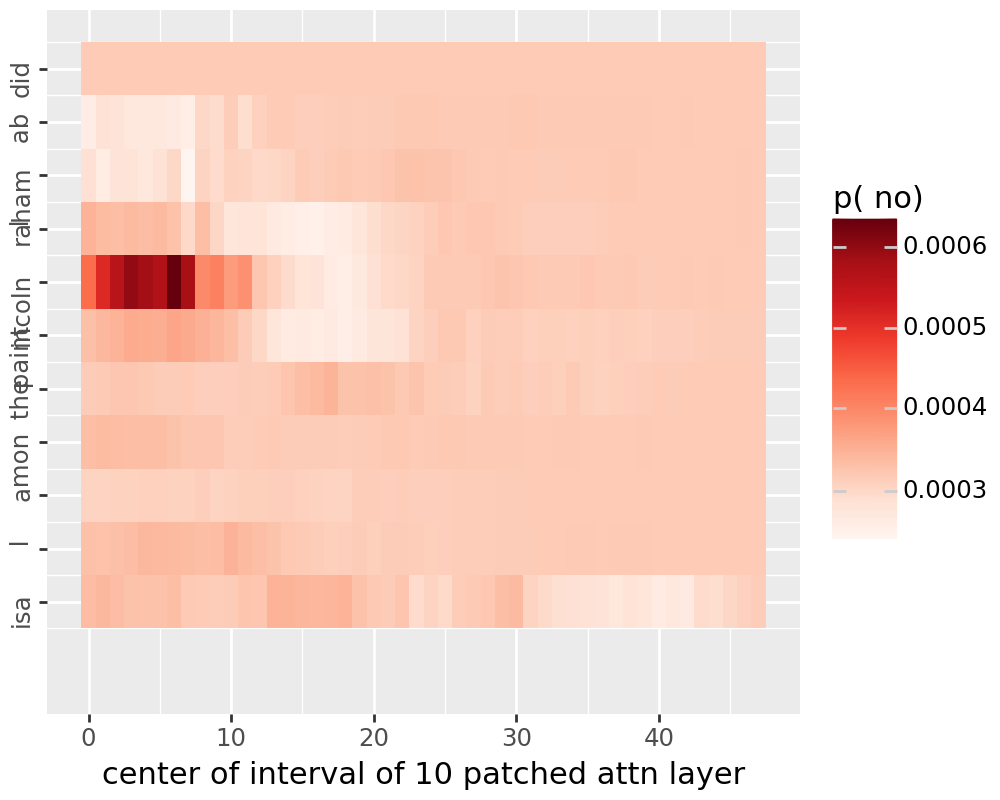

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_2_pyvene_rome_block_output.pdf


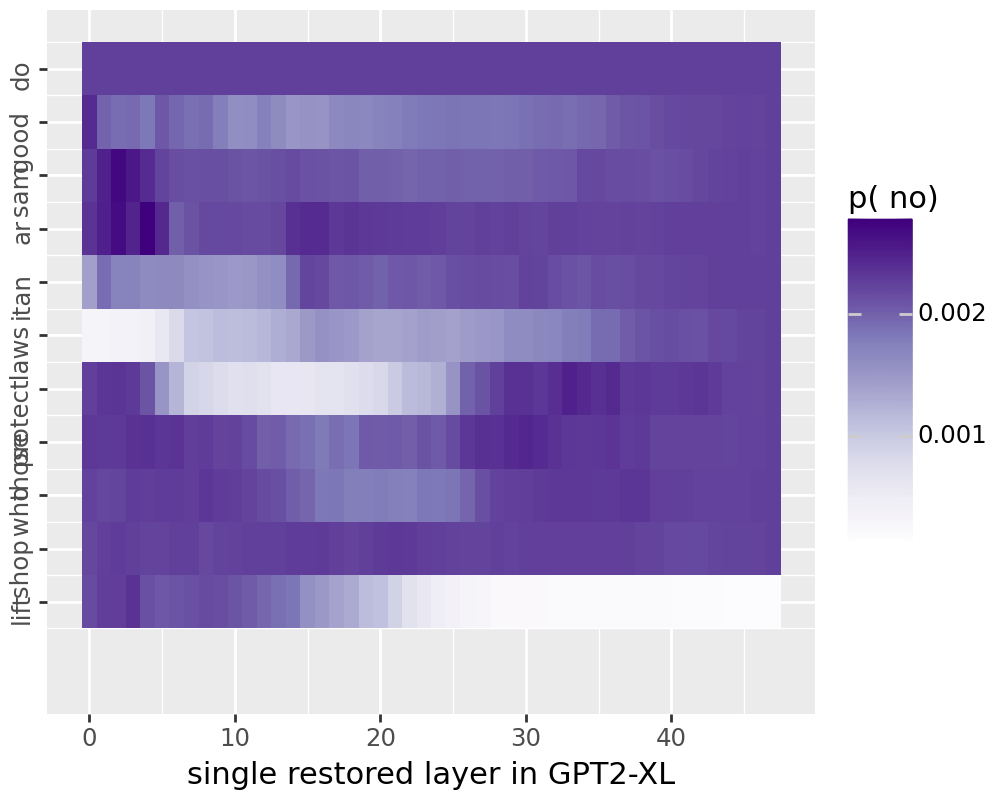

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_2_pyvene_rome_mlp_activation.pdf


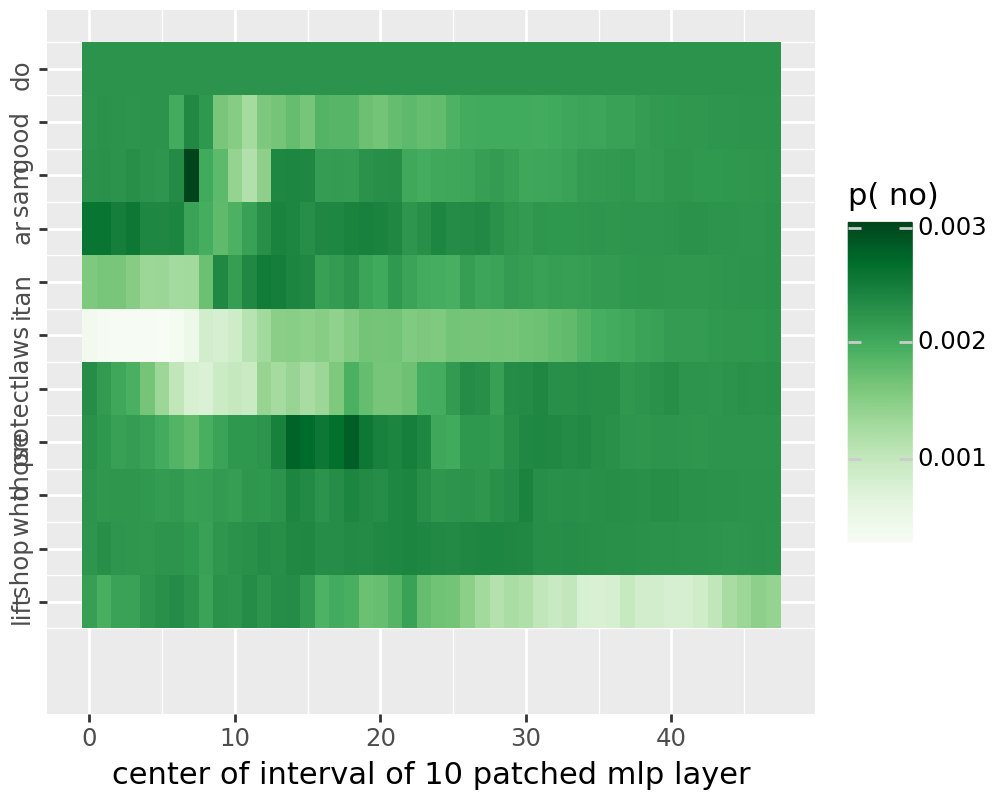

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_2_pyvene_rome_attention_output.pdf


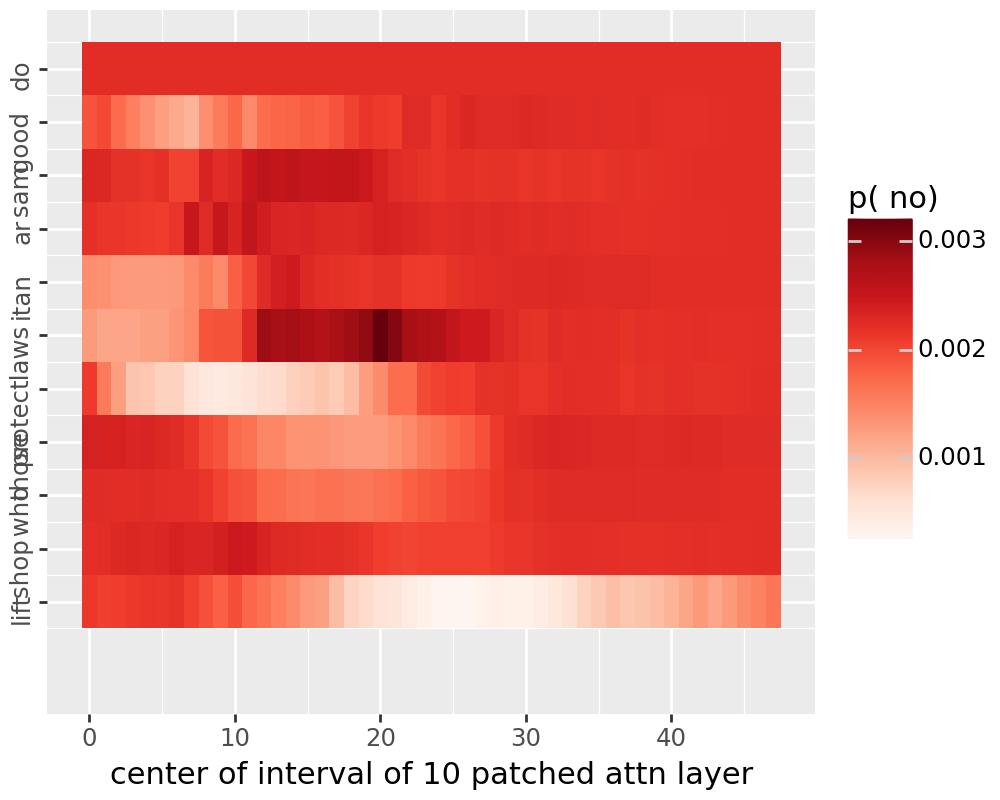

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_3_pyvene_rome_block_output.pdf


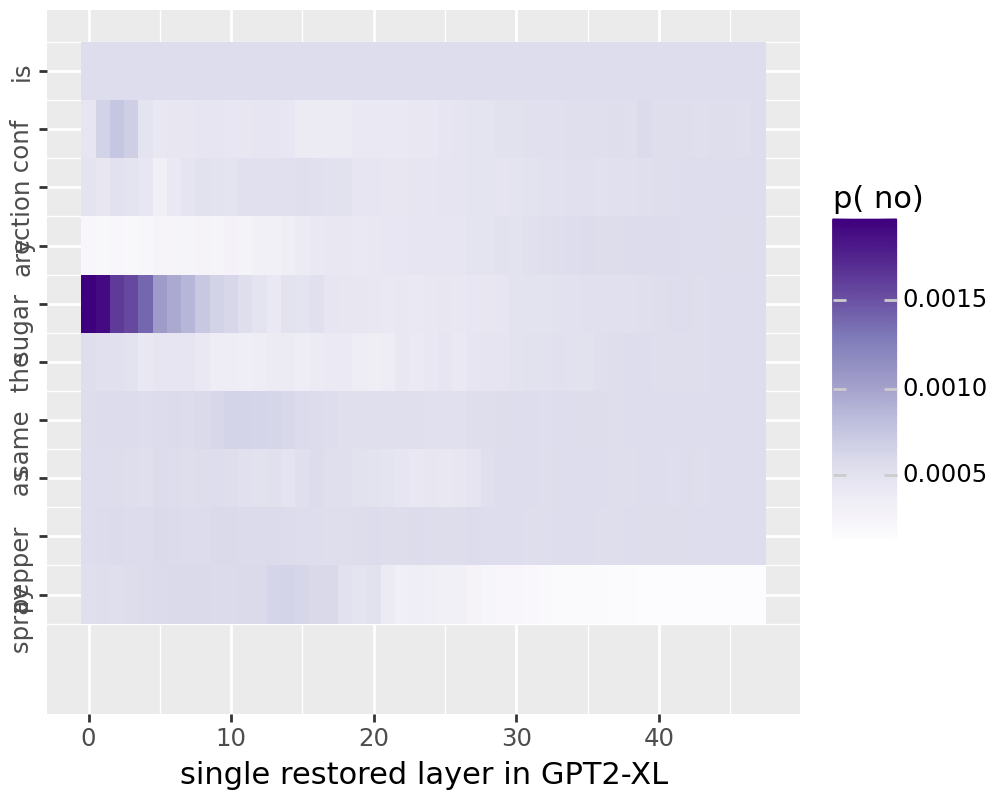

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_3_pyvene_rome_mlp_activation.pdf


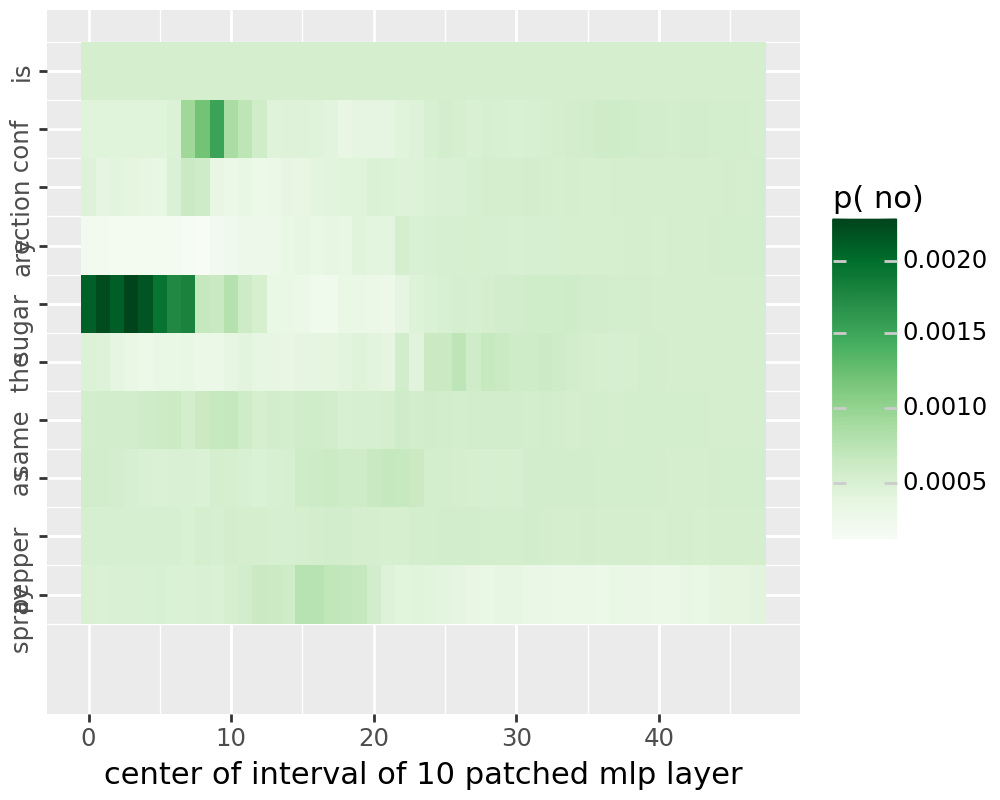

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_3_pyvene_rome_attention_output.pdf


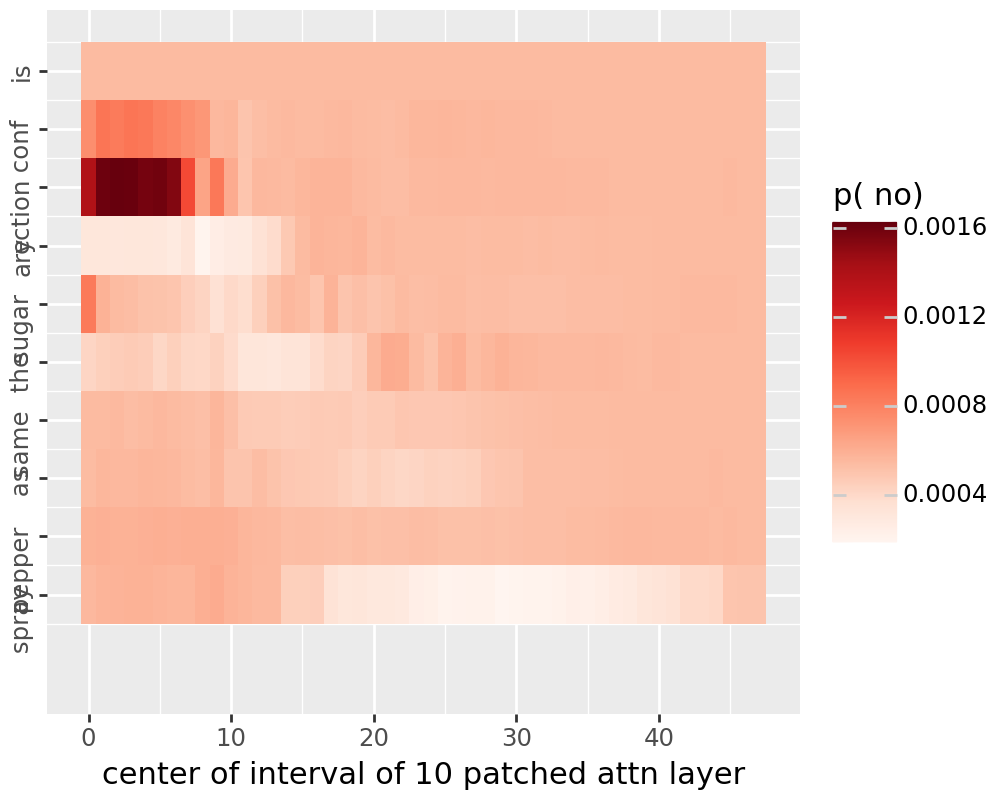

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_4_pyvene_rome_block_output.pdf


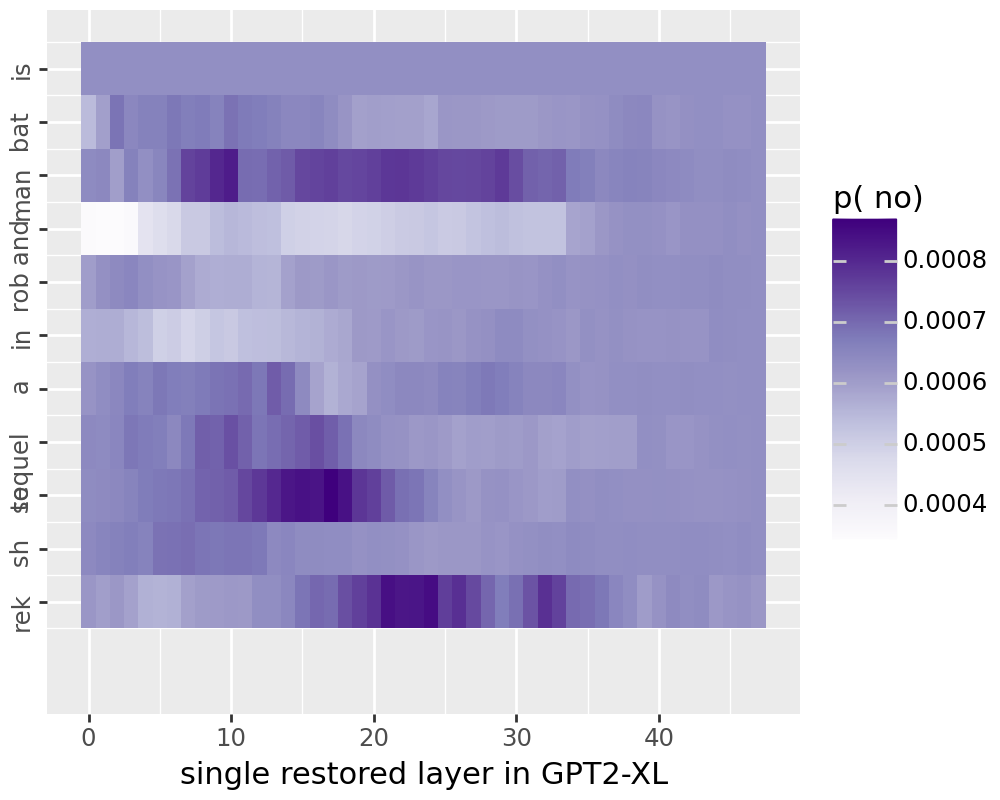

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_4_pyvene_rome_mlp_activation.pdf


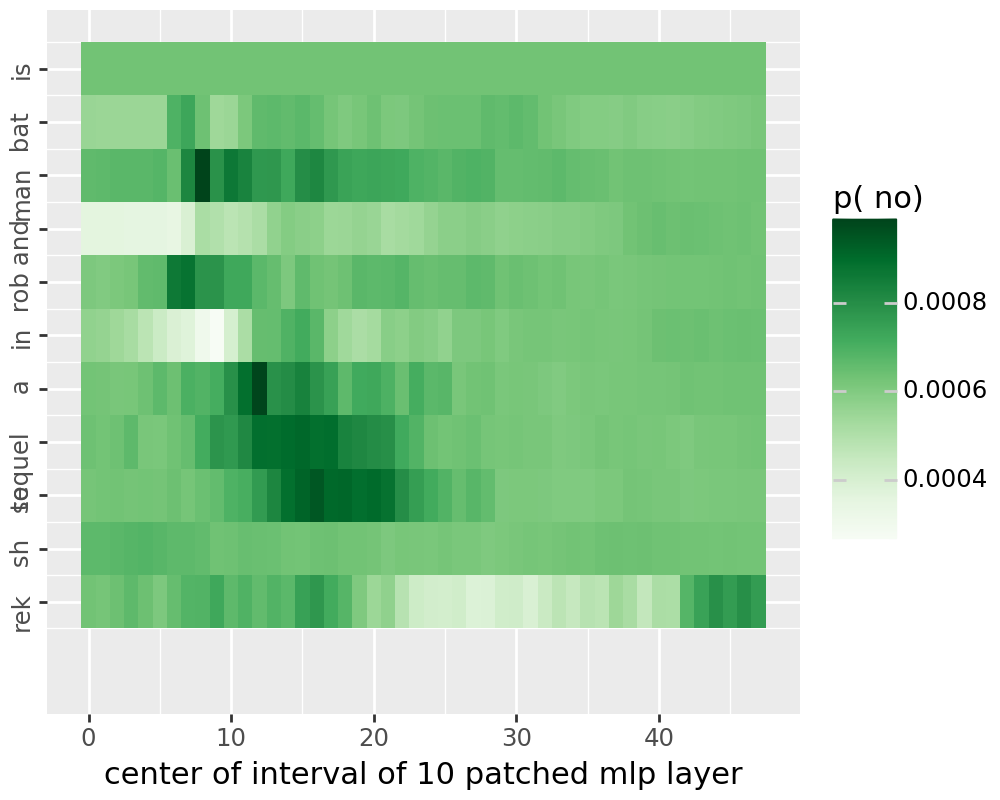

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_4_pyvene_rome_attention_output.pdf


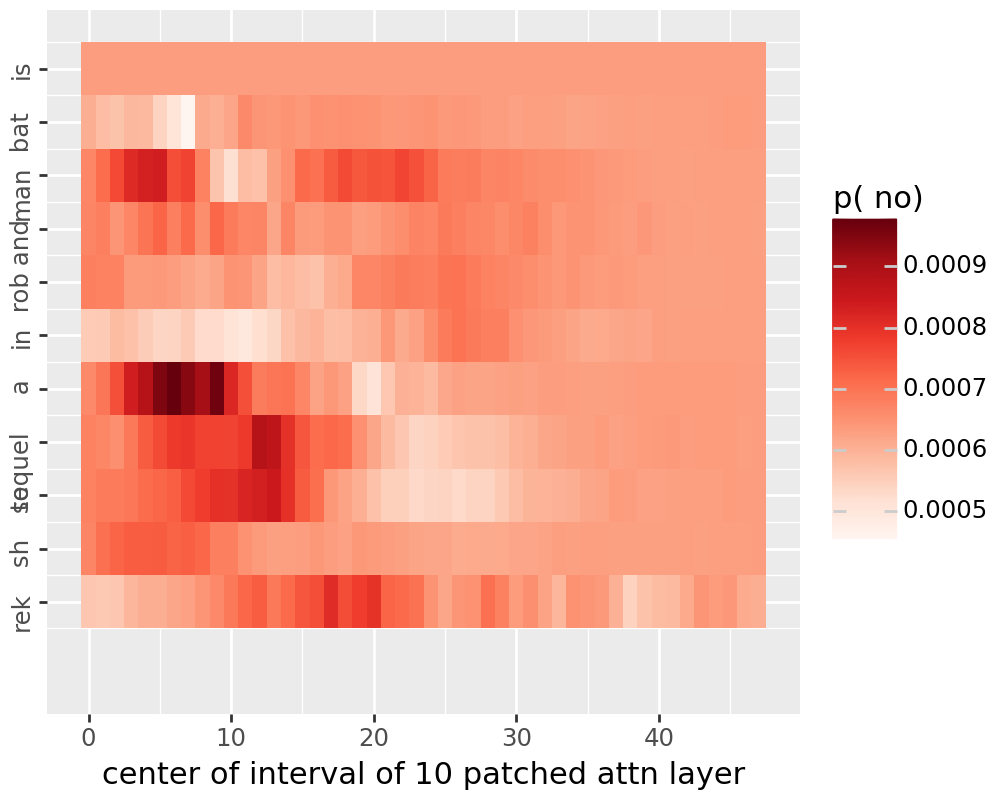

In [ ]:
from plotnine import *
import pandas as pd
for example in examples3:
  id = example["id"]
  sentence = example['question']
  answer = " no"
  for stream in ["block_output", "mlp_activation", "attention_output"]:
    df = pd.read_csv(f"./tutorial_data/yes_{id}_pyvene_rome_{stream}.csv")
    df["layer"] = df["layer"].astype(int)
    df["pos"] = df["pos"].astype(int)
    df[f"p({answer})"] = df["prob"].astype(float)

    tokenize_sentence = tokenizer.encode(sentence)
    decoded_sentence = [tokenizer.decode(tok) for tok in tokenize_sentence]
    custom_labels = decoded_sentence
    breaks = [i for i in range(len(custom_labels))]

    plot = (
        ggplot(df, aes(x="layer", y="pos"))
        + geom_tile(aes(fill=f"p({answer})"))
        + scale_fill_cmap(colors[stream])
        + xlab(titles[stream])
        + scale_y_reverse(
            limits=(-0.5, len(tokenize_sentence) + 0.5), #rozszerzyc zakres
            breaks=breaks, labels=custom_labels
        )
        + theme(figure_size=(5, 4))
        + ylab("")
        + theme(axis_text_y=element_text(angle=90, hjust=1))
    )
    # Save the plot to a file
    ggsave(
        plot, filename=f"./tutorial_data/yes_{id}_pyvene_rome_{stream}.pdf", dpi=200
    )
    # Display the plot in the notebook
    display(plot)

In [ ]:
def create_gpt2(name="gpt2", cache_dir=None):
    """Creates a GPT2 model, config, and tokenizer from the given name and revision"""
    from transformers import GPT2Model, GPT2Tokenizer, GPT2Config

    config = GPT2Config.from_pretrained(name)
    tokenizer = GPT2Tokenizer.from_pretrained(name)
    gpt = GPT2Model.from_pretrained(name, config=config, cache_dir=cache_dir)
    print("loaded model")
    return config, tokenizer, gpt

In [ ]:
config, tokenizer, gpt = create_gpt2(name="utahnlp/boolq_gpt2-xl_seed-1")

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/668 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/43.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

loaded model


In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
gpt.to(device)

GPT2Model(
  (wte): Embedding(50257, 1600)
  (wpe): Embedding(1024, 1600)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-47): 48 x GPT2Block(
      (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2SdpaAttention(
        (c_attn): Conv1D(nf=4800, nx=1600)
        (c_proj): Conv1D(nf=1600, nx=1600)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=6400, nx=1600)
        (c_proj): Conv1D(nf=1600, nx=6400)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
)

In [ ]:
examples2 = [
    {"question": "Question: did abraham lincoln write the letter in saving private ryan? Answer:", "sub_tokens": [3, 4, 5, 6], "id": 1},
    {"question": "Question: do good samaritan laws protect those who help at an accident? Answer:", "sub_tokens": [3, 4, 5, 6, 7], "id": 2},
    {"question": "Question: is confectionary sugar the same as powdered sugar? Answer:", "sub_tokens": [3, 4, 5, 6], "id": 3},
    {"question": "Question: is batman and robin a sequel to batman forever? Answer:", "sub_tokens": [3, 4, 5, 6, 7], "id": 4}
]

In [ ]:
base = "did abraham lincoln write the letter in saving private ryan"
inputs = [
    tokenizer(base, return_tensors="pt").to(device),
]
print(base)
res = gpt(**inputs[0], output_hidden_states=True)
hidden_states = res.hidden_states[-1]
distrib = embed_to_distrib(gpt, hidden_states, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

did abraham lincoln write the letter in saving private ryan
's                   0.30197441577911377
?                    0.28525760769844055
_from                0.060457635670900345
.                    0.032293614000082016
\n                   0.022639863193035126
_and                 0.018275752663612366
,                    0.016509175300598145
_j                   0.012657595798373222
?                    0.011768553406000137
_letter              0.01158741395920515


In [ ]:
for q in examples2:
  question = q['question']
  tokq = tokenizer.encode(question)
  decoded = [tokenizer.decode(tok) for tok in tokq]
  print(decoded)

['Question', ':', ' did', ' ab', 'raham', ' l', 'incoln', ' write', ' the', ' letter', ' in', ' saving', ' private', ' r', 'yan', '?', ' Answer', ':']
['Question', ':', ' do', ' good', ' sam', 'ar', 'itan', ' laws', ' protect', ' those', ' who', ' help', ' at', ' an', ' accident', '?', ' Answer', ':']
['Question', ':', ' is', ' conf', 'ection', 'ary', ' sugar', ' the', ' same', ' as', ' powdered', ' sugar', '?', ' Answer', ':']
['Question', ':', ' is', ' bat', 'man', ' and', ' rob', 'in', ' a', ' sequel', ' to', ' bat', 'man', ' forever', '?', ' Answer', ':']


In [ ]:
for example in examples2:
  sentence = example["question"]
  subject_tokens_positions = example["sub_tokens"]
  id = example["id"]
  sentence_tokens = tokenizer.encode(sentence)

  answer_token = tokenizer.encode(" yes")[0]

  print(sentence)
  #corrupt
  base = tokenizer(sentence, return_tensors="pt").to(device)
  config = corrupted_config(type(gpt), len(subject_tokens_positions))
  intervenable = IntervenableModel(config, gpt)
  _, counterfactual_outputs = intervenable(
      base, unit_locations={"base": ([[subject_tokens_positions]])}
  )
  distrib = embed_to_distrib(gpt, counterfactual_outputs.last_hidden_state, logits=False)

  for stream in ["block_output", "mlp_activation", "attention_output"]:
    data = []
    for layer_i in tqdm(range(gpt.config.n_layer)):
        for pos_i in range(len(sentence_tokens)):
            config = restore_corrupted_with_interval_config(
                layer_i, stream,
                window=1 if stream == "block_output" else 10, noise_dim=len(subject_tokens_positions)
            )
            n_restores = len(config.representations) - 1
            intervenable = IntervenableModel(config, gpt)
            _, counterfactual_outputs = intervenable(
                base,
                [None] + [base]*n_restores,
                {
                    "sources->base": (
                        [None] + [[[pos_i]]]*n_restores,
                        [[subject_tokens_positions]] + [[[pos_i]]]*n_restores,
                    )
                },
            )
            distrib = embed_to_distrib(
                gpt, counterfactual_outputs.last_hidden_state, logits=False
            )

            prob = distrib[0][-1][answer_token].detach().cpu().item()
            data.append({"layer": layer_i, "pos": pos_i, "prob": prob})
    df = pd.DataFrame(data)
    df.to_csv(f"./tutorial_data/yes_{id}_pyvene_rome_{stream}.csv")

Question: did abraham lincoln write the letter in saving private ryan? Answer:


100%|██████████| 48/48 [06:03<00:00,  7.57s/it]


Question: do good samaritan laws protect those who help at an accident? Answer:


100%|██████████| 48/48 [06:02<00:00,  7.54s/it]


Question: is confectionary sugar the same as powdered sugar? Answer:


100%|██████████| 48/48 [05:09<00:00,  6.45s/it]


Question: is batman and robin a sequel to batman forever? Answer:


100%|██████████| 48/48 [05:38<00:00,  7.05s/it]


/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_1_pyvene_rome_block_output.pdf


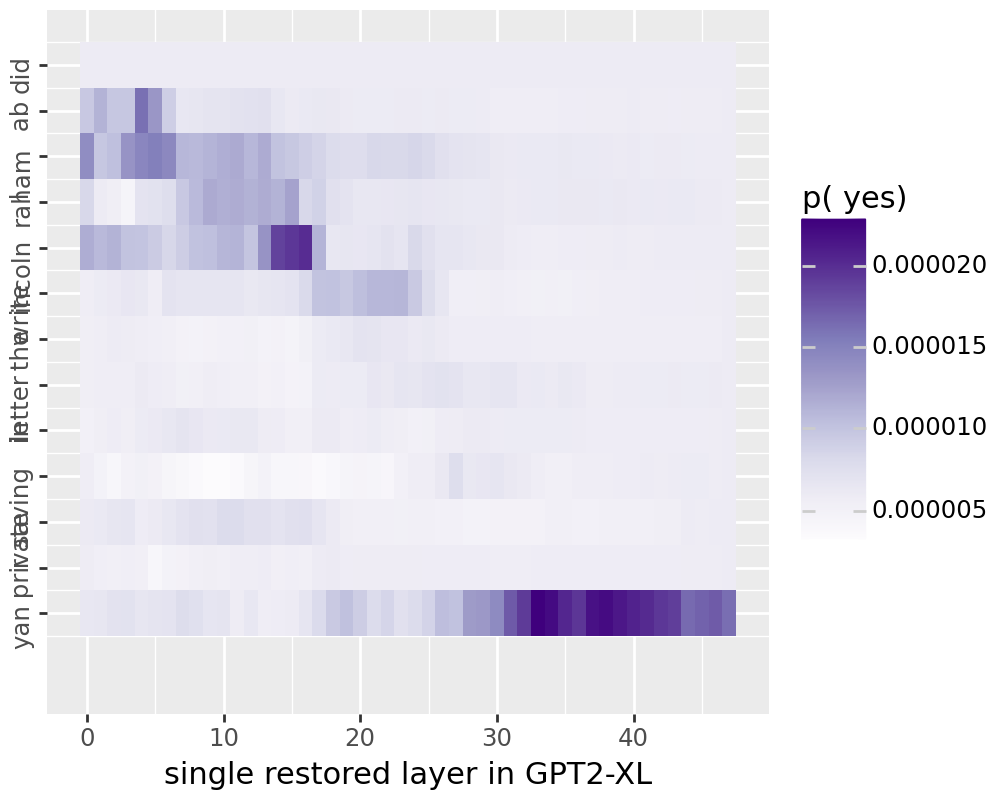

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_1_pyvene_rome_mlp_activation.pdf


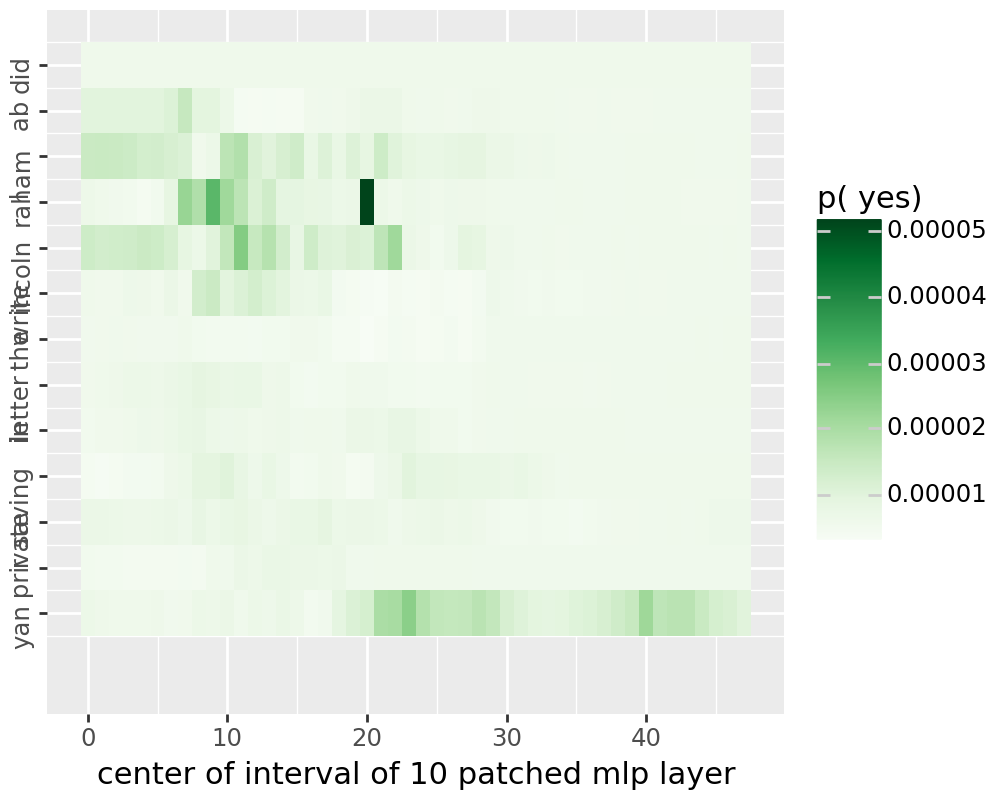

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_1_pyvene_rome_attention_output.pdf


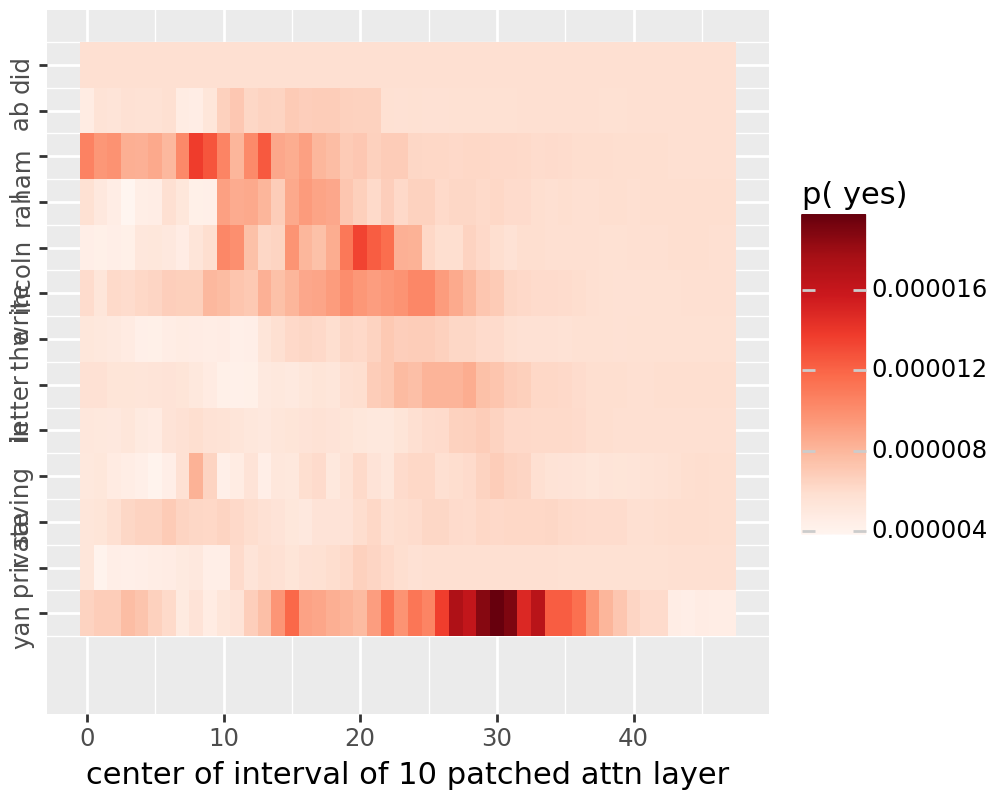

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_2_pyvene_rome_block_output.pdf


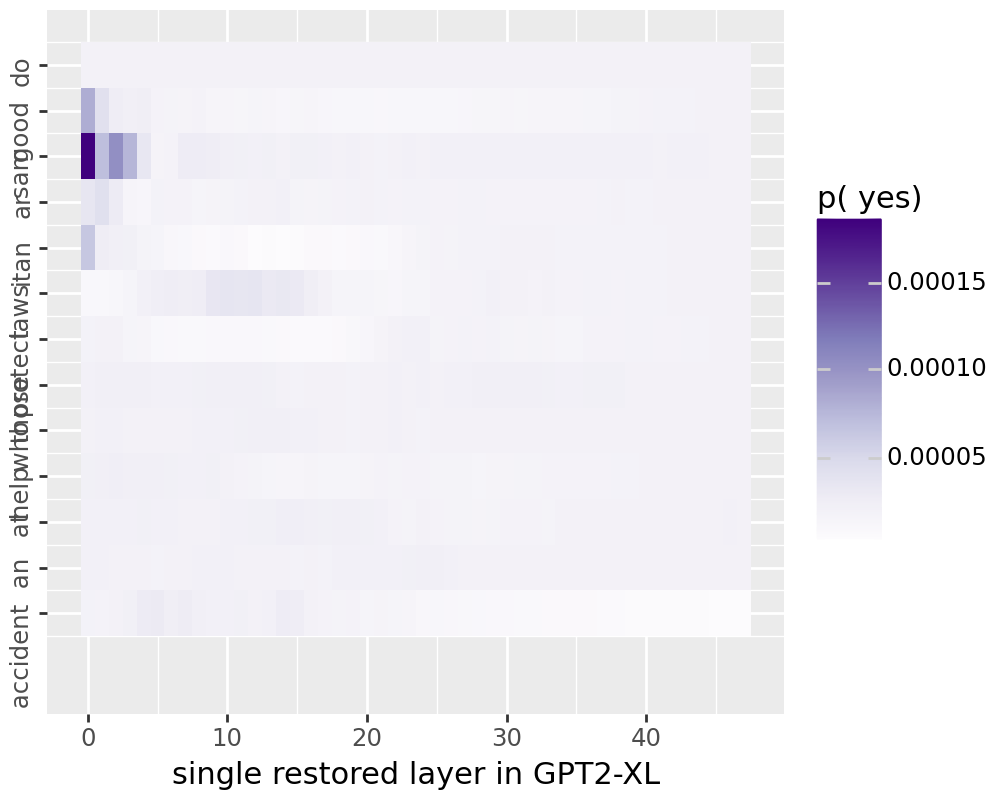

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_2_pyvene_rome_mlp_activation.pdf


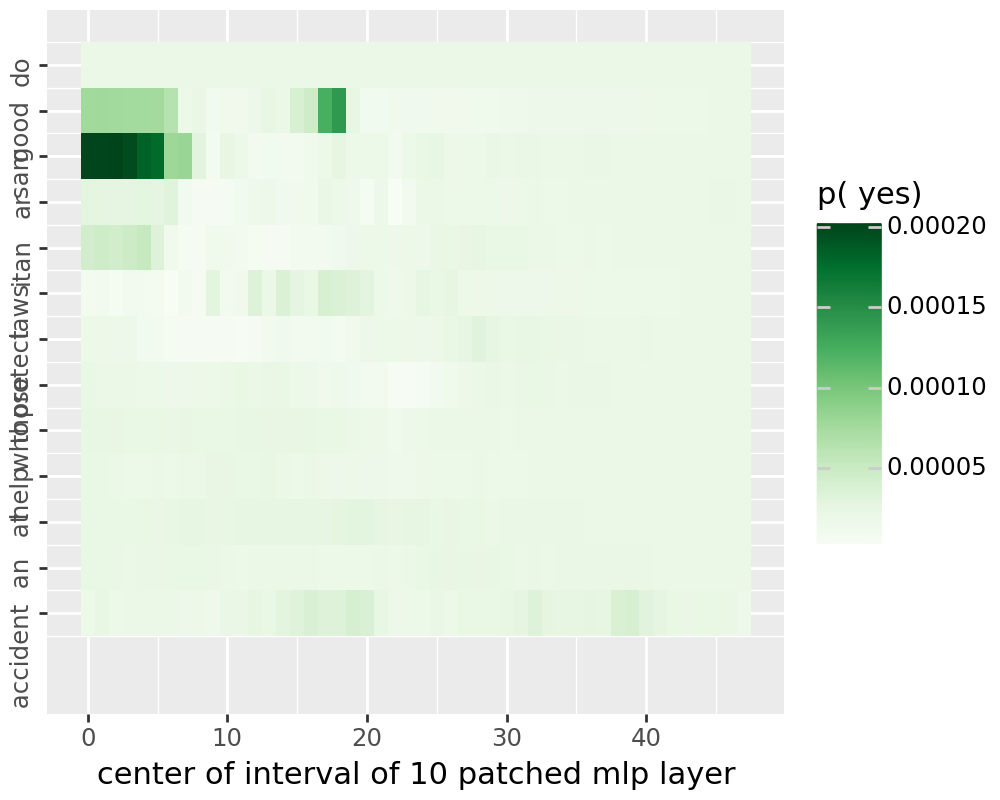

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_2_pyvene_rome_attention_output.pdf


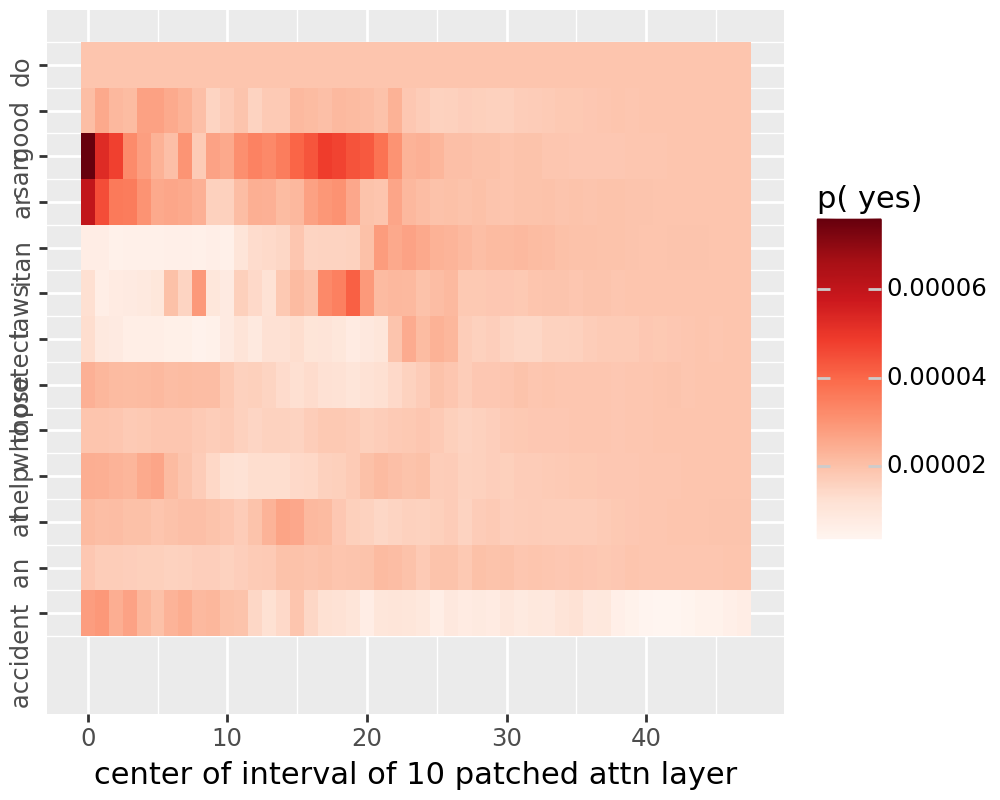

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_3_pyvene_rome_block_output.pdf


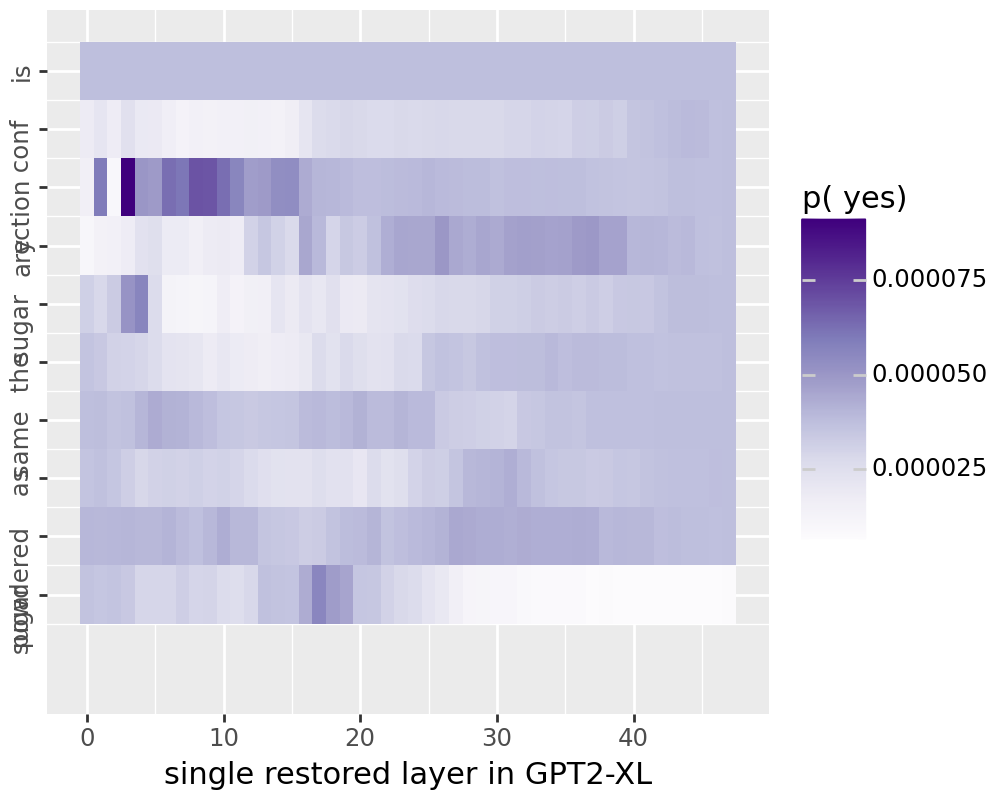

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_3_pyvene_rome_mlp_activation.pdf


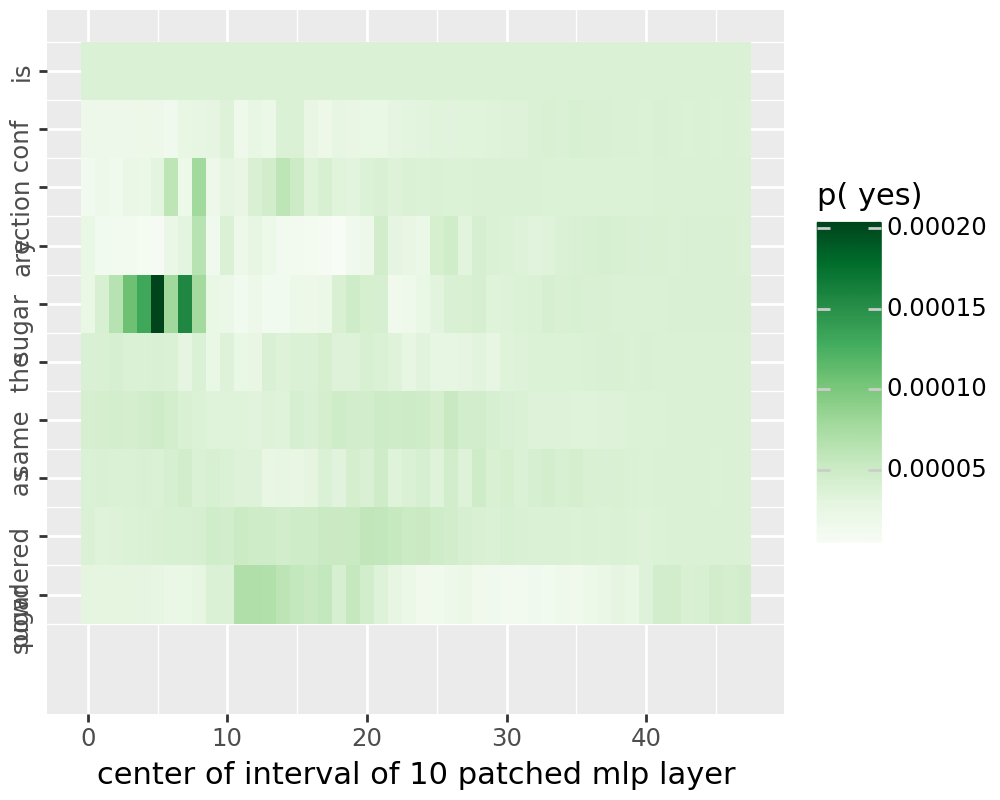

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_3_pyvene_rome_attention_output.pdf


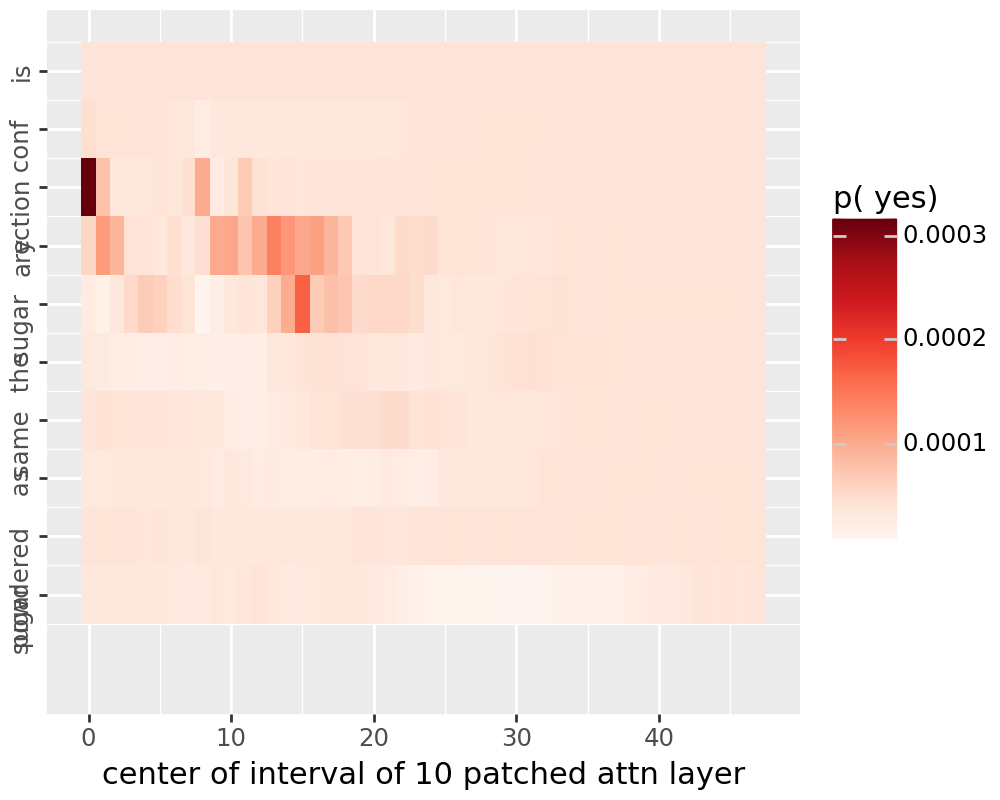

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_4_pyvene_rome_block_output.pdf


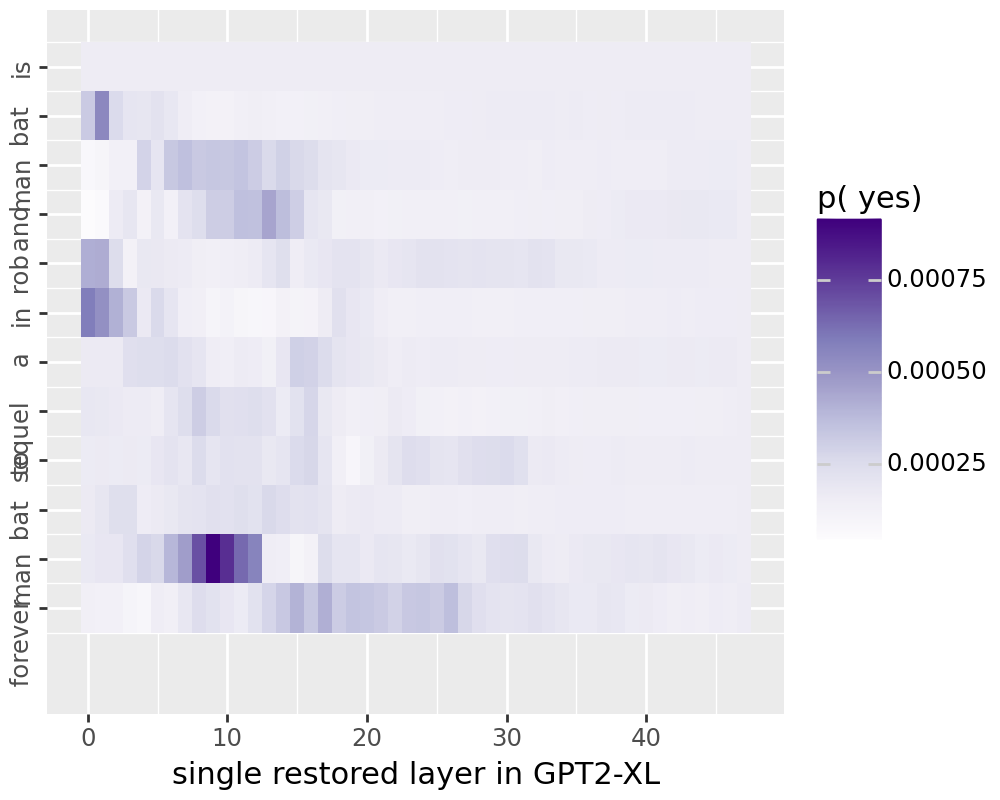

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_4_pyvene_rome_mlp_activation.pdf


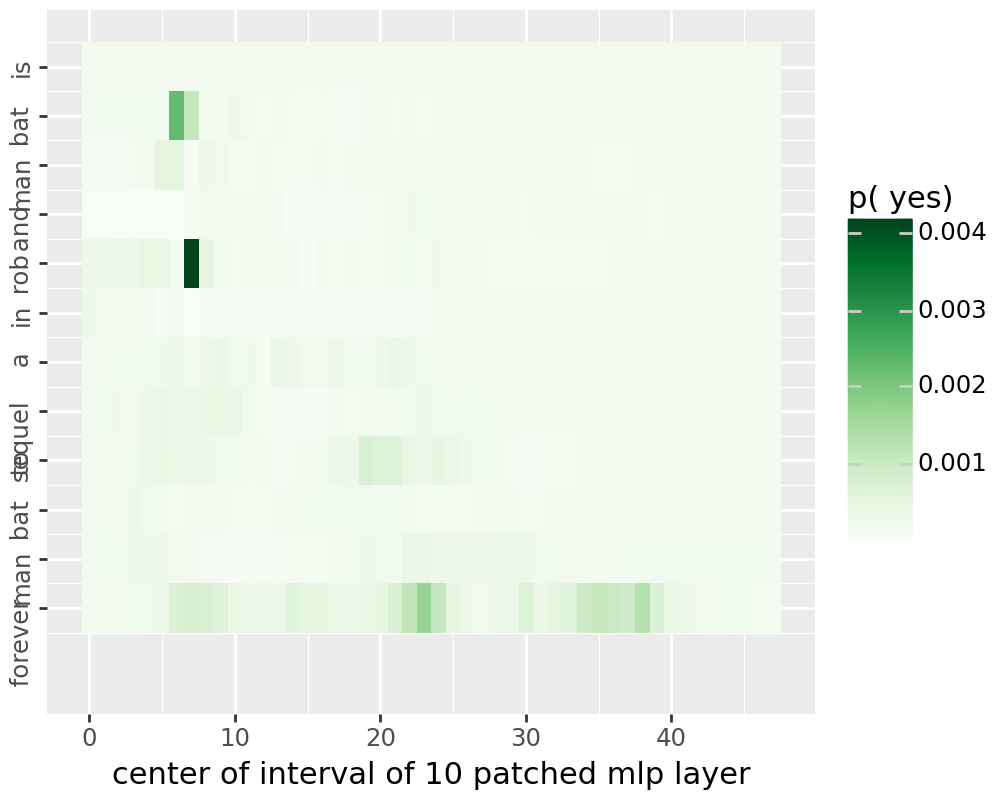

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_4_pyvene_rome_attention_output.pdf


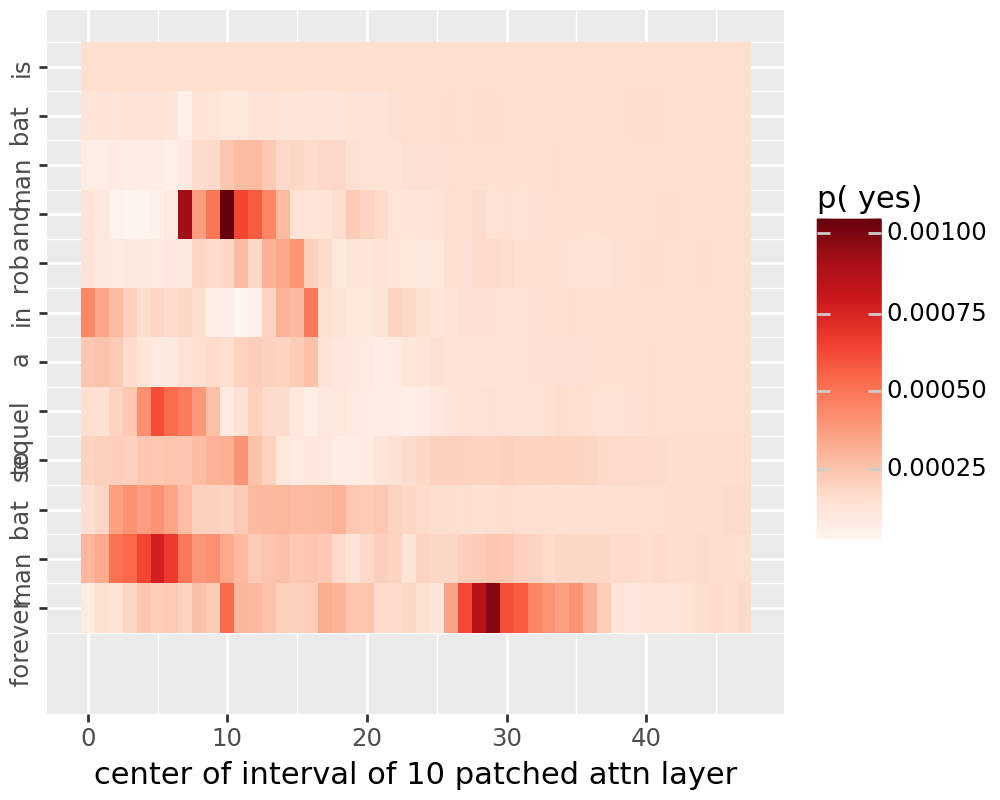

In [ ]:
from plotnine import *
import pandas as pd
for example in examples2:
  id = example["id"]
  sentence = example['question']
  answer = " yes"
  for stream in ["block_output", "mlp_activation", "attention_output"]:
    df = pd.read_csv(f"./tutorial_data/yes_{id}_pyvene_rome_{stream}.csv")
    df["layer"] = df["layer"].astype(int)
    df["pos"] = df["pos"].astype(int)
    df[f"p({answer})"] = df["prob"].astype(float)

    tokenize_sentence = tokenizer.encode(sentence)
    decoded_sentence = [tokenizer.decode(tok) for tok in tokenize_sentence]
    custom_labels = decoded_sentence
    breaks = [i for i in range(len(custom_labels))]

    plot = (
        ggplot(df, aes(x="layer", y="pos"))
        + geom_tile(aes(fill=f"p({answer})"))
        + scale_fill_cmap(colors[stream])
        + xlab(titles[stream])
        + scale_y_reverse(
            limits=(-0.5, len(tokenize_sentence) + 0.5), #rozszerzyc zakres
            breaks=breaks, labels=custom_labels
        )
        + theme(figure_size=(5, 4))
        + ylab("")
        + theme(axis_text_y=element_text(angle=90, hjust=1))
    )
    # Save the plot to a file
    ggsave(
        plot, filename=f"./tutorial_data/yes_{id}_pyvene_rome_{stream}.pdf", dpi=200
    )
    # Display the plot in the notebook
    display(plot)

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_1_pyvene_rome_block_output.pdf


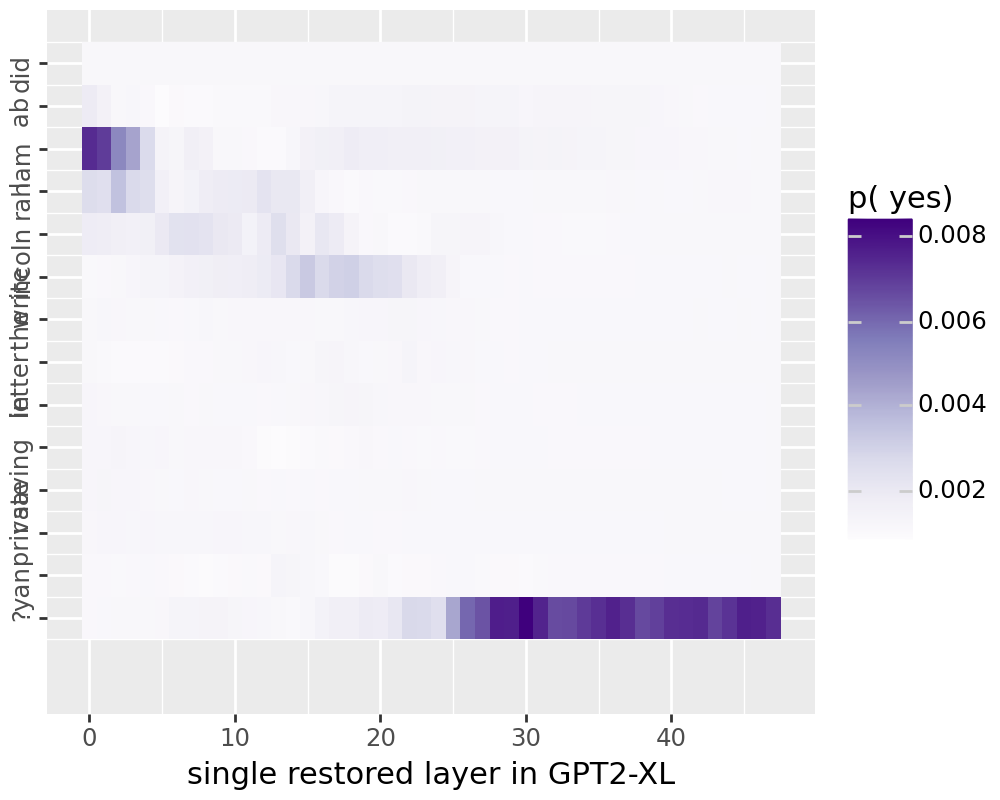

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_1_pyvene_rome_mlp_activation.pdf


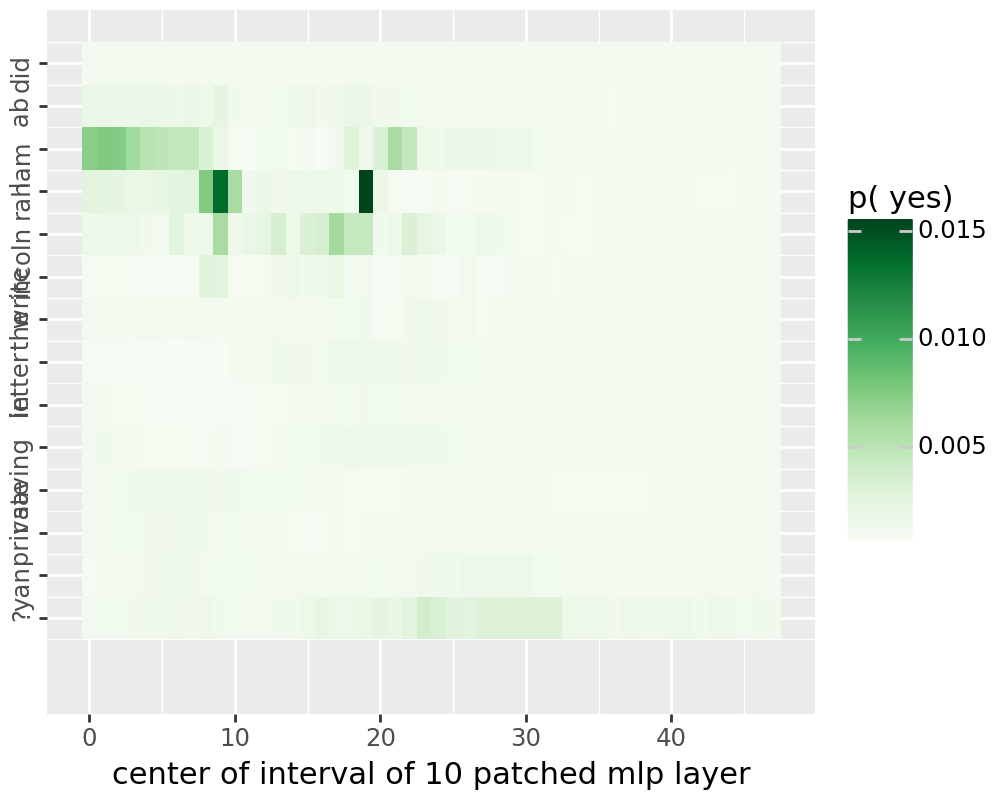

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_1_pyvene_rome_attention_output.pdf


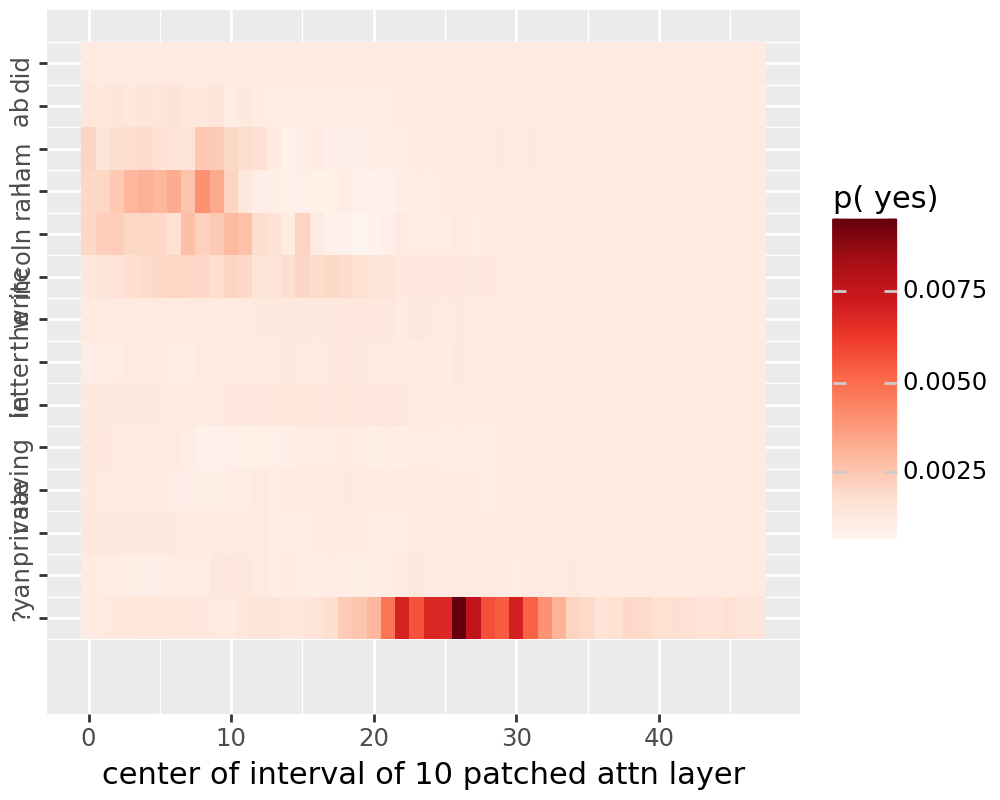

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_2_pyvene_rome_block_output.pdf


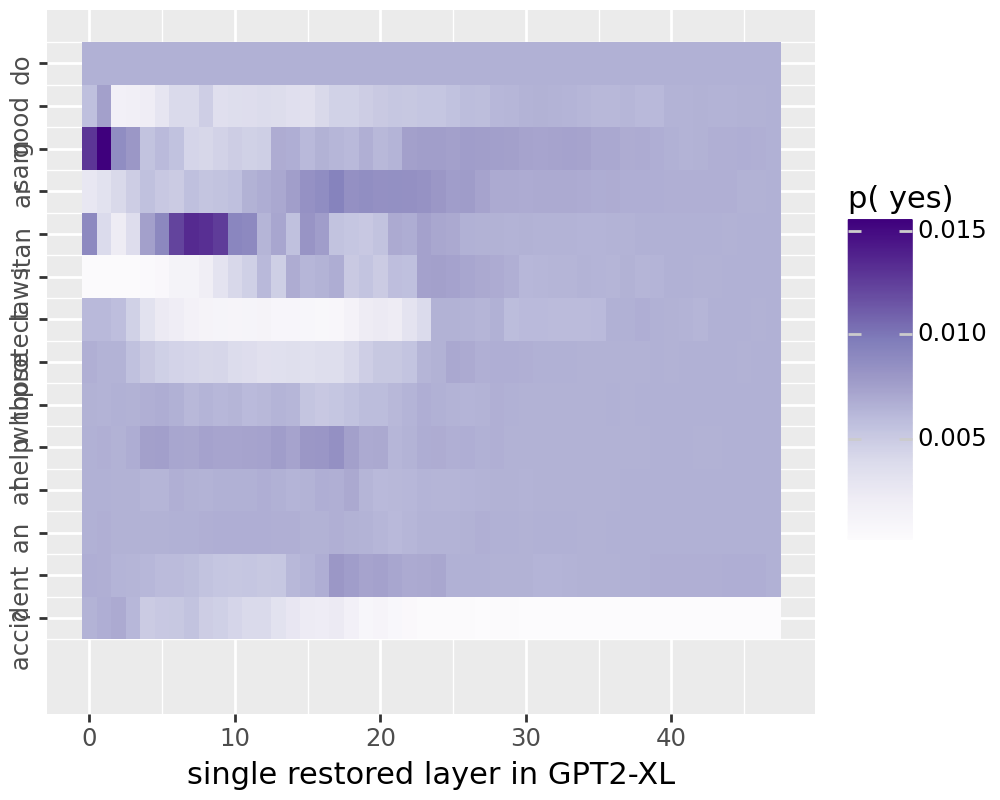

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_2_pyvene_rome_mlp_activation.pdf


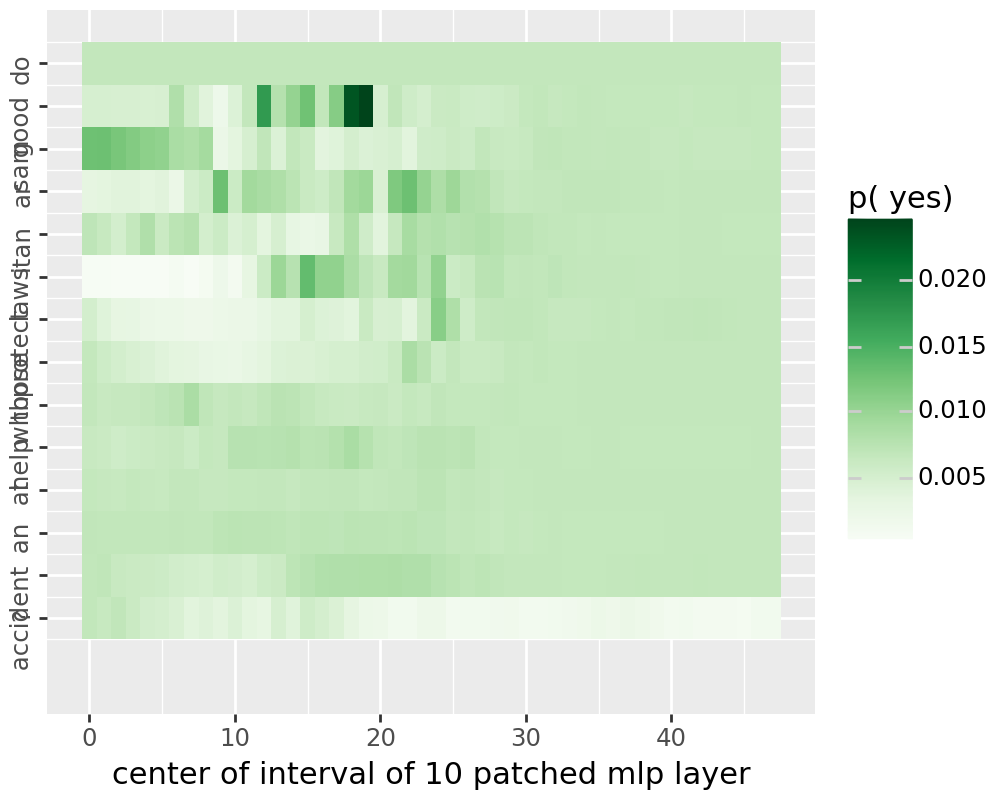

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_2_pyvene_rome_attention_output.pdf


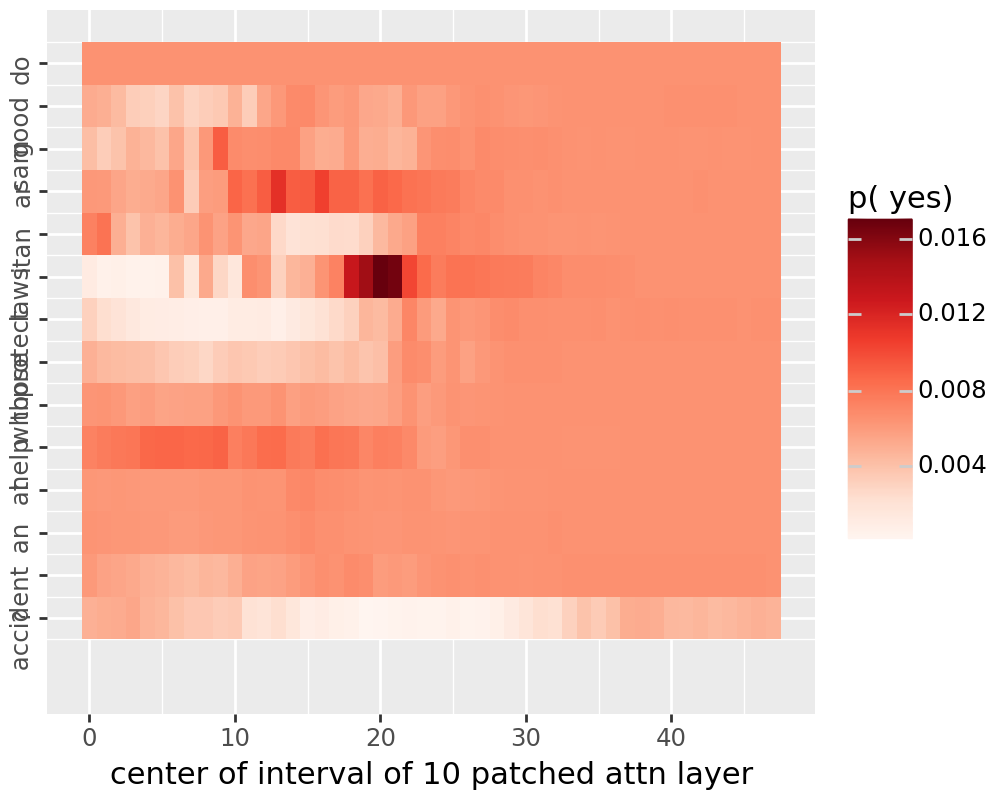

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_3_pyvene_rome_block_output.pdf


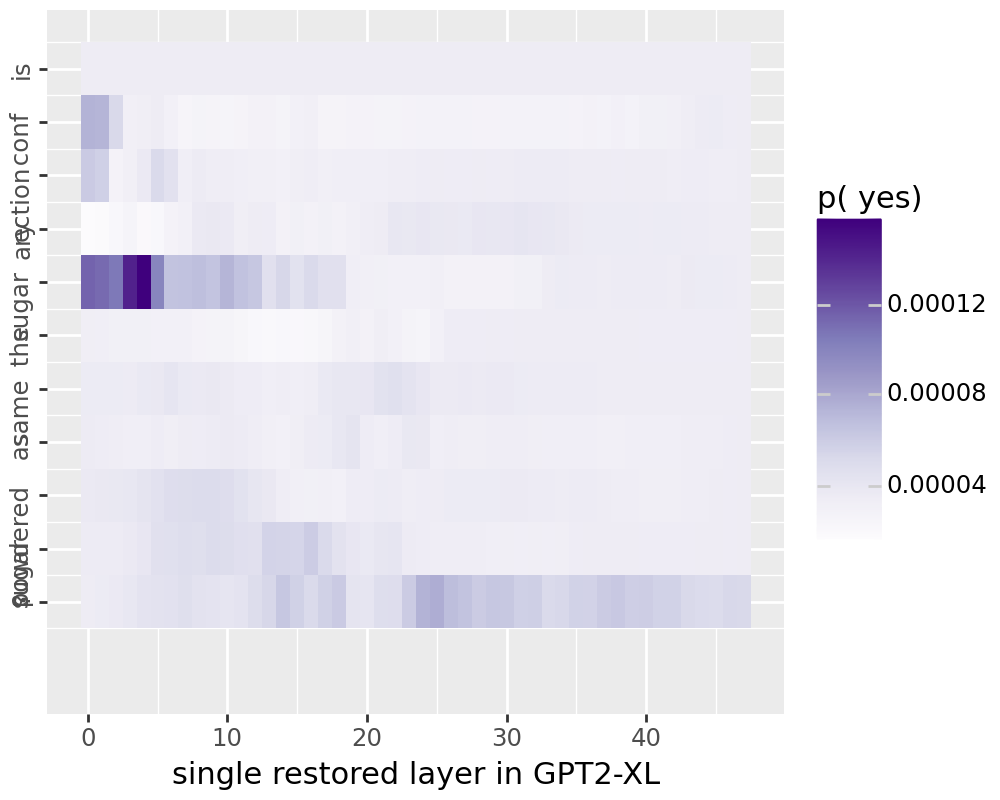

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_3_pyvene_rome_mlp_activation.pdf


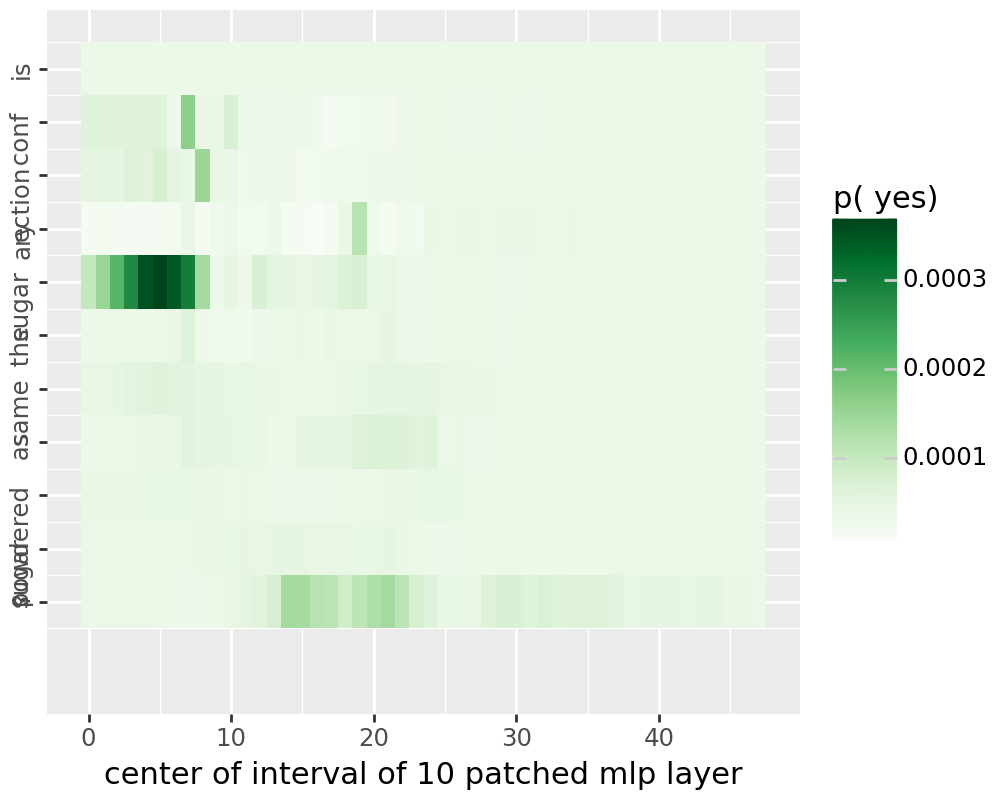

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_3_pyvene_rome_attention_output.pdf


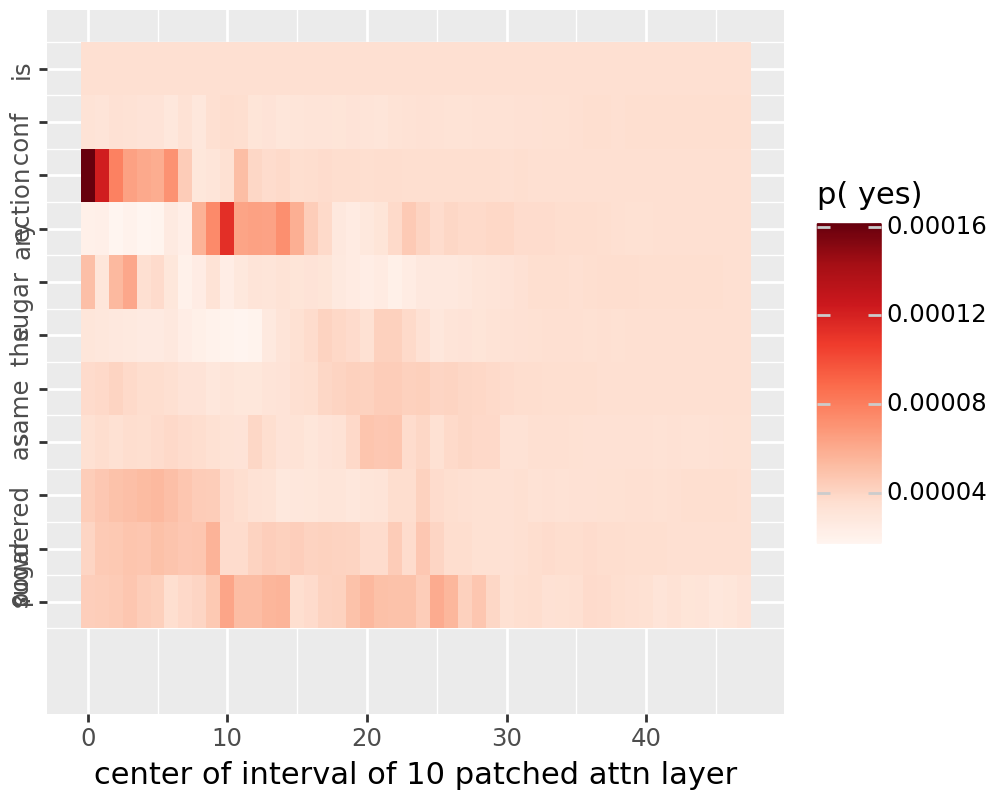

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_4_pyvene_rome_block_output.pdf


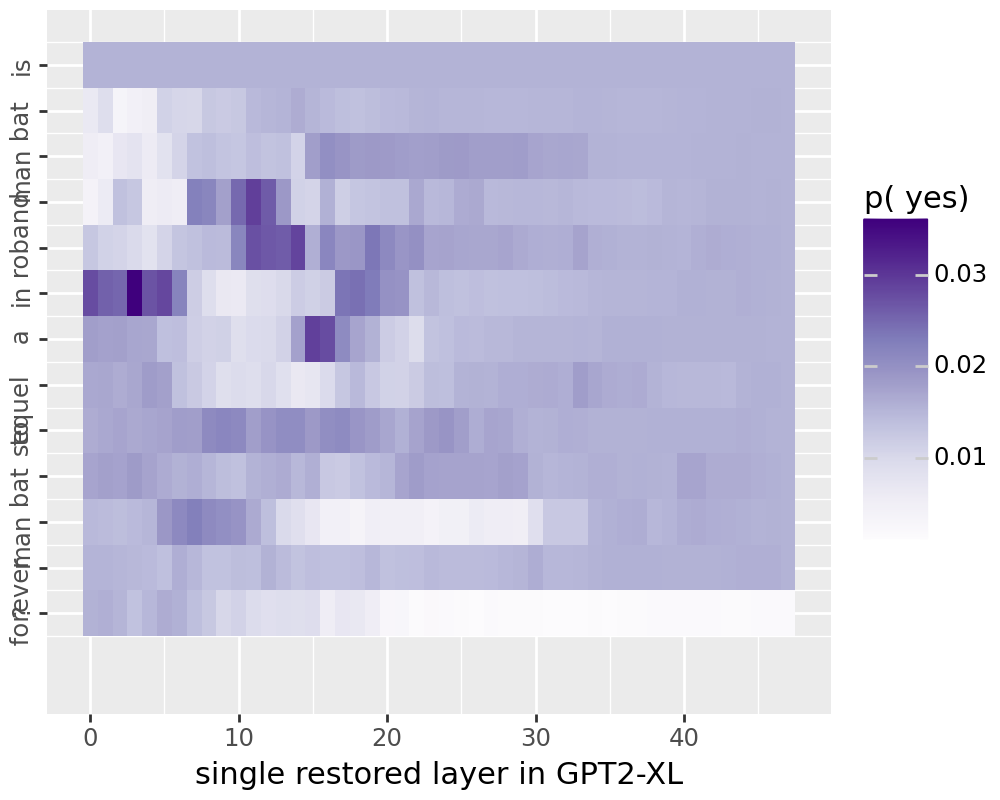

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_4_pyvene_rome_mlp_activation.pdf


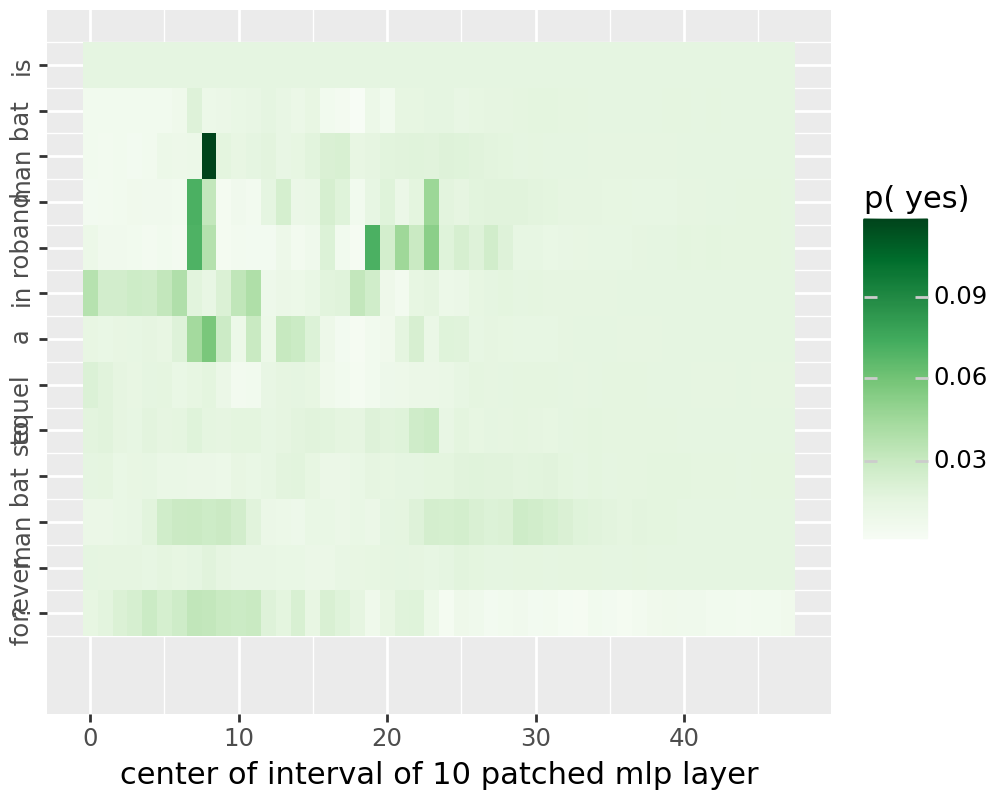

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_4_pyvene_rome_attention_output.pdf


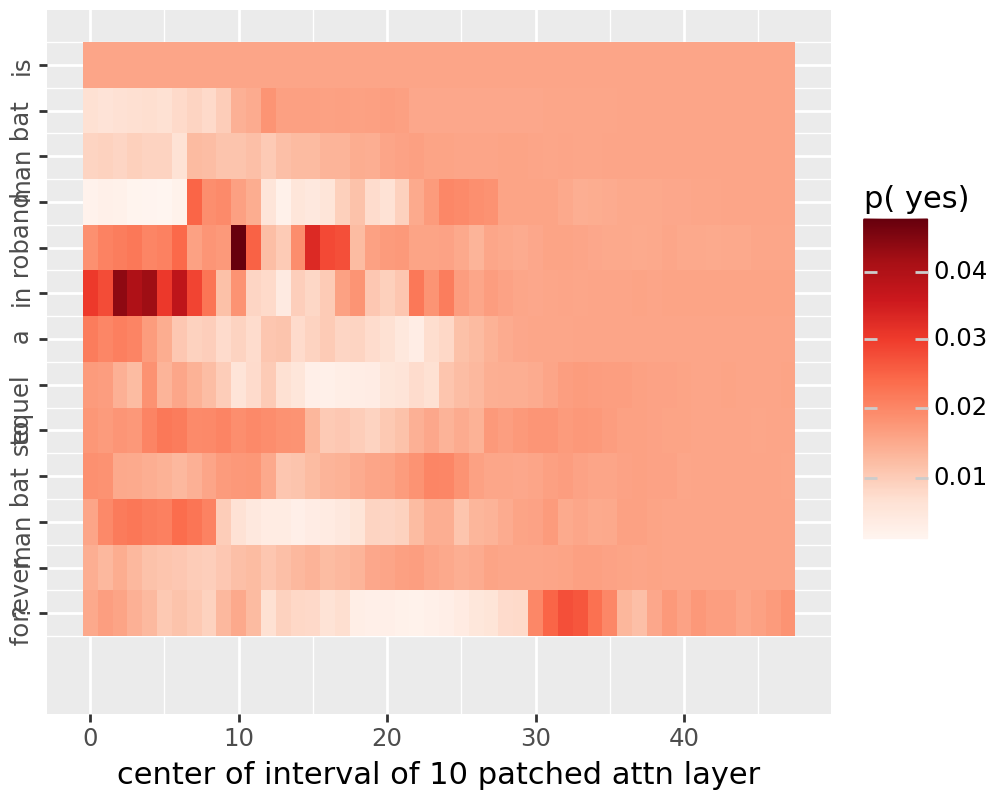

In [ ]:
from plotnine import *
import pandas as pd
for example in examples3:
  id = example["id"]
  sentence = example['question']
  answer = " yes"
  for stream in ["block_output", "mlp_activation", "attention_output"]:
    df = pd.read_csv(f"./tutorial_data/yes_{id}_pyvene_rome_{stream}.csv")
    df["layer"] = df["layer"].astype(int)
    df["pos"] = df["pos"].astype(int)
    df[f"p({answer})"] = df["prob"].astype(float)

    tokenize_sentence = tokenizer.encode(sentence)
    decoded_sentence = [tokenizer.decode(tok) for tok in tokenize_sentence]
    custom_labels = decoded_sentence
    breaks = [i for i in range(len(custom_labels))]

    plot = (
        ggplot(df, aes(x="layer", y="pos"))
        + geom_tile(aes(fill=f"p({answer})"))
        + scale_fill_cmap(colors[stream])
        + xlab(titles[stream])
        + scale_y_reverse(
            limits=(-0.5, len(tokenize_sentence) + 0.5), #rozszerzyc zakres
            breaks=breaks, labels=custom_labels
        )
        + theme(figure_size=(5, 4))
        + ylab("")
        + theme(axis_text_y=element_text(angle=90, hjust=1))
    )
    # Save the plot to a file
    ggsave(
        plot, filename=f"./tutorial_data/yes_{id}_pyvene_rome_{stream}.pdf", dpi=200
    )
    # Display the plot in the notebook
    display(plot)

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_1_pyvene_rome_block_output.pdf


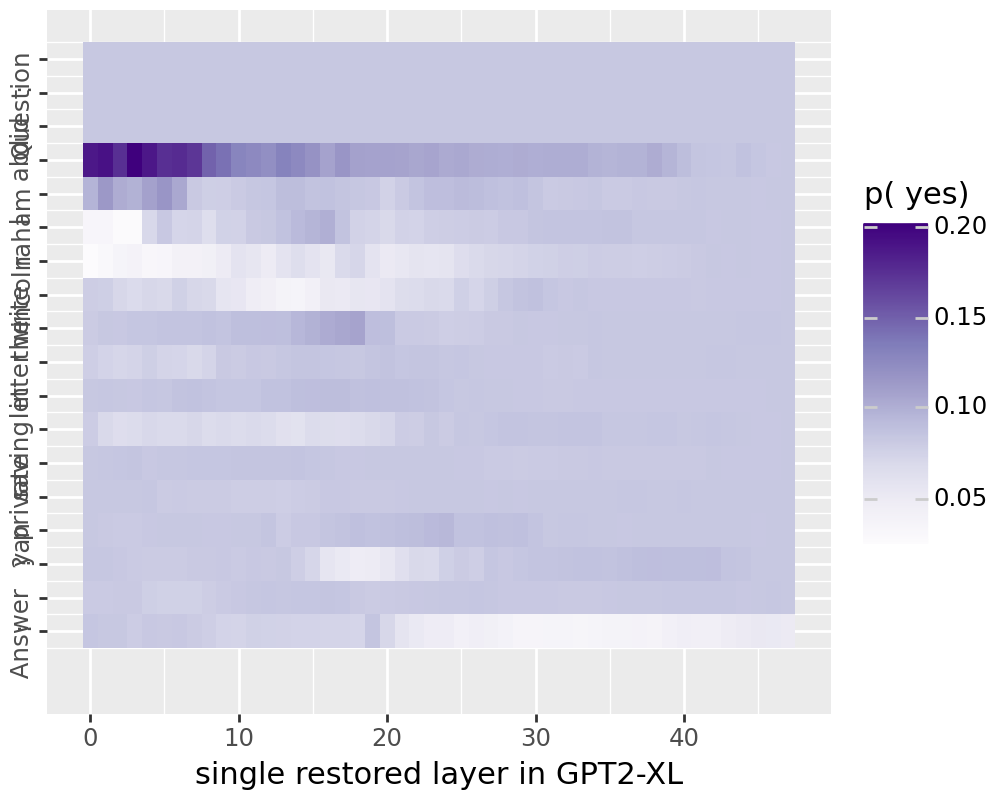

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_1_pyvene_rome_mlp_activation.pdf


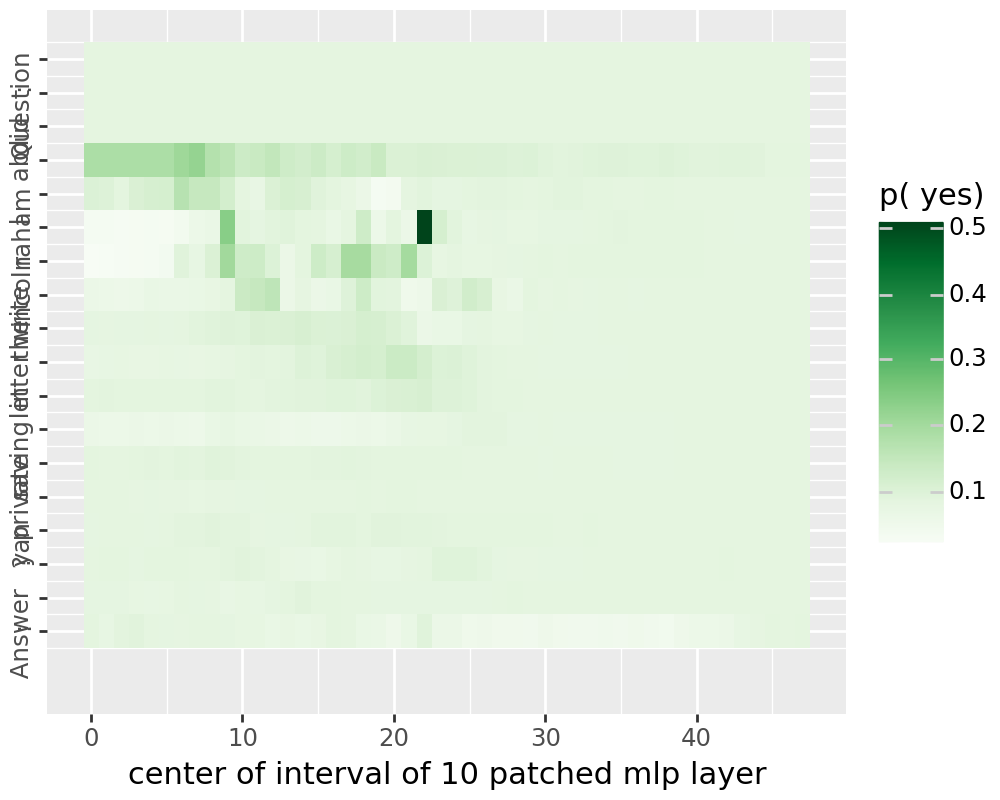

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_1_pyvene_rome_attention_output.pdf


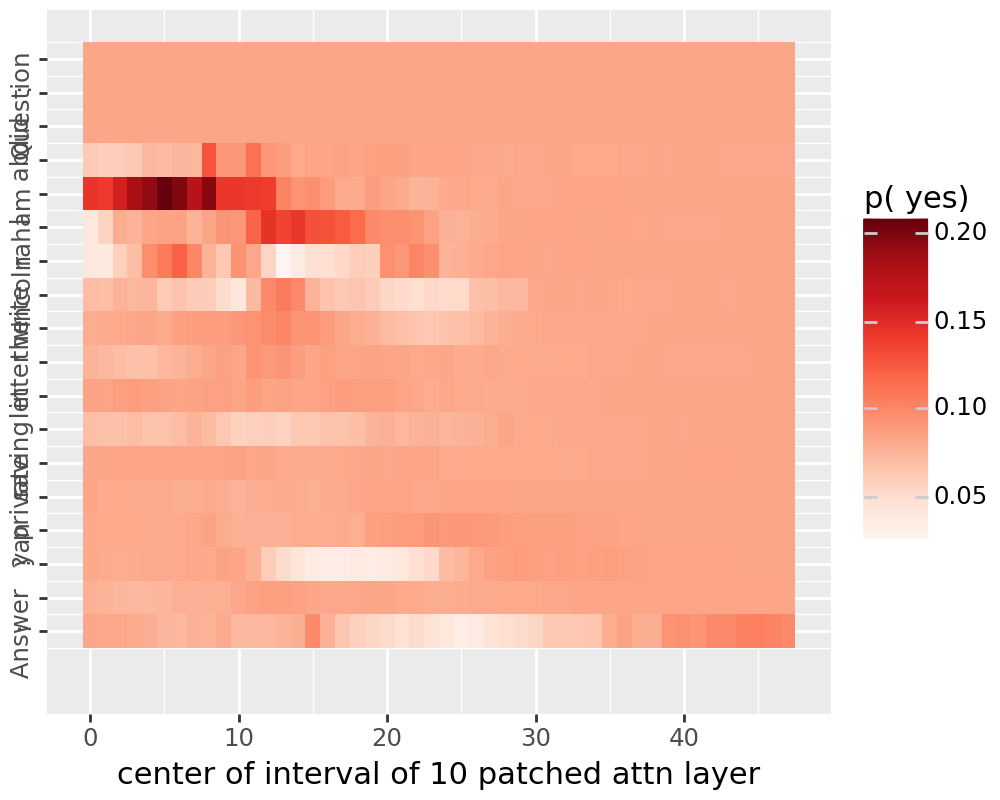

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_2_pyvene_rome_block_output.pdf


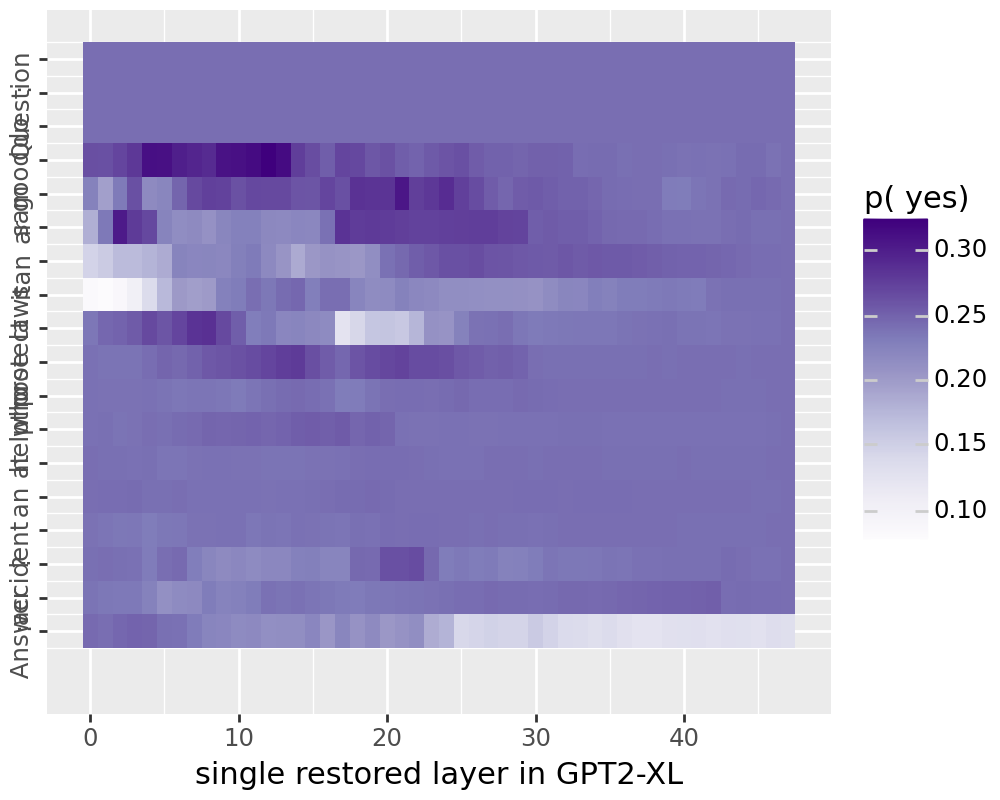

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_2_pyvene_rome_mlp_activation.pdf


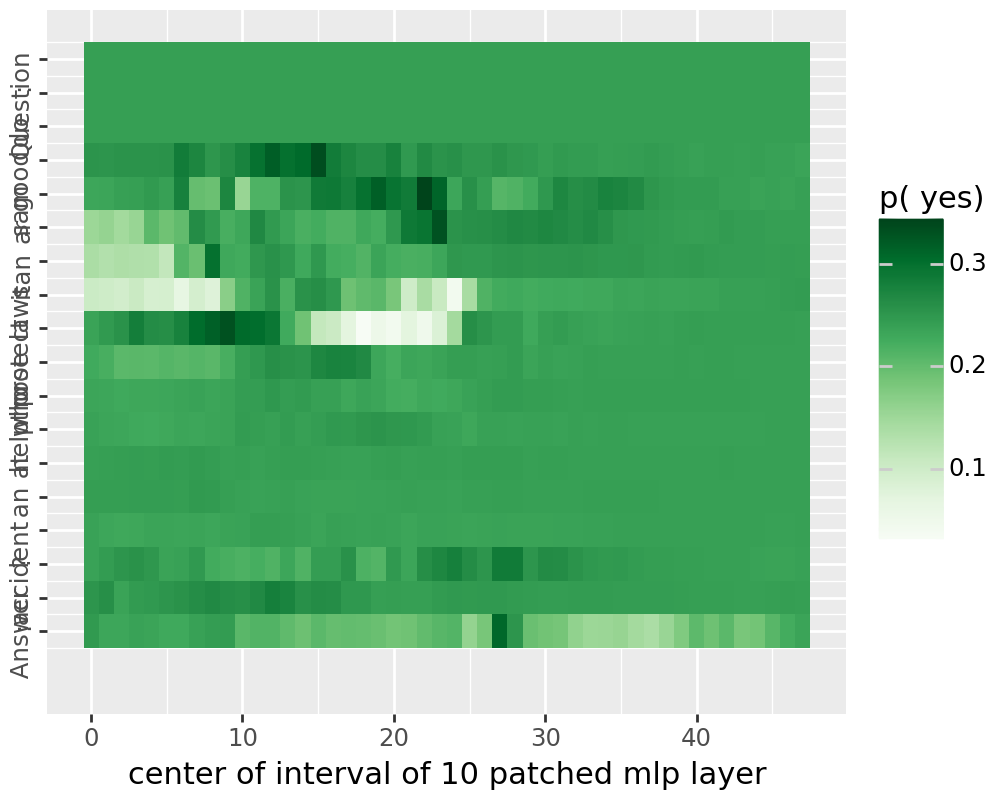

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_2_pyvene_rome_attention_output.pdf


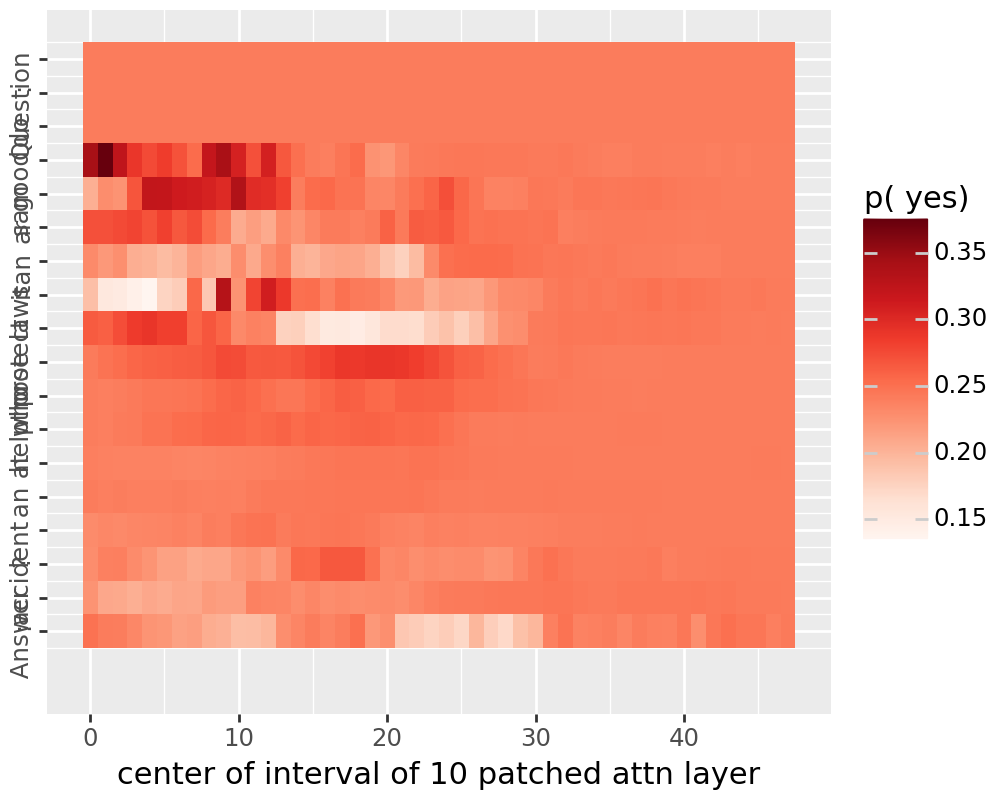

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_3_pyvene_rome_block_output.pdf


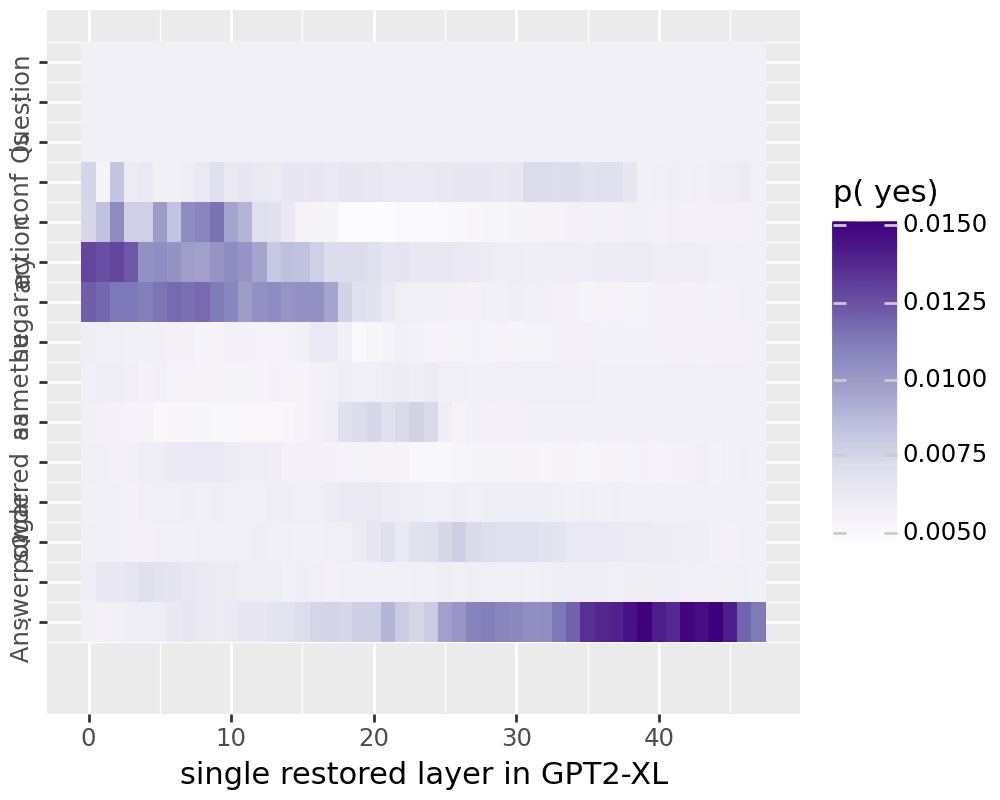

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_3_pyvene_rome_mlp_activation.pdf


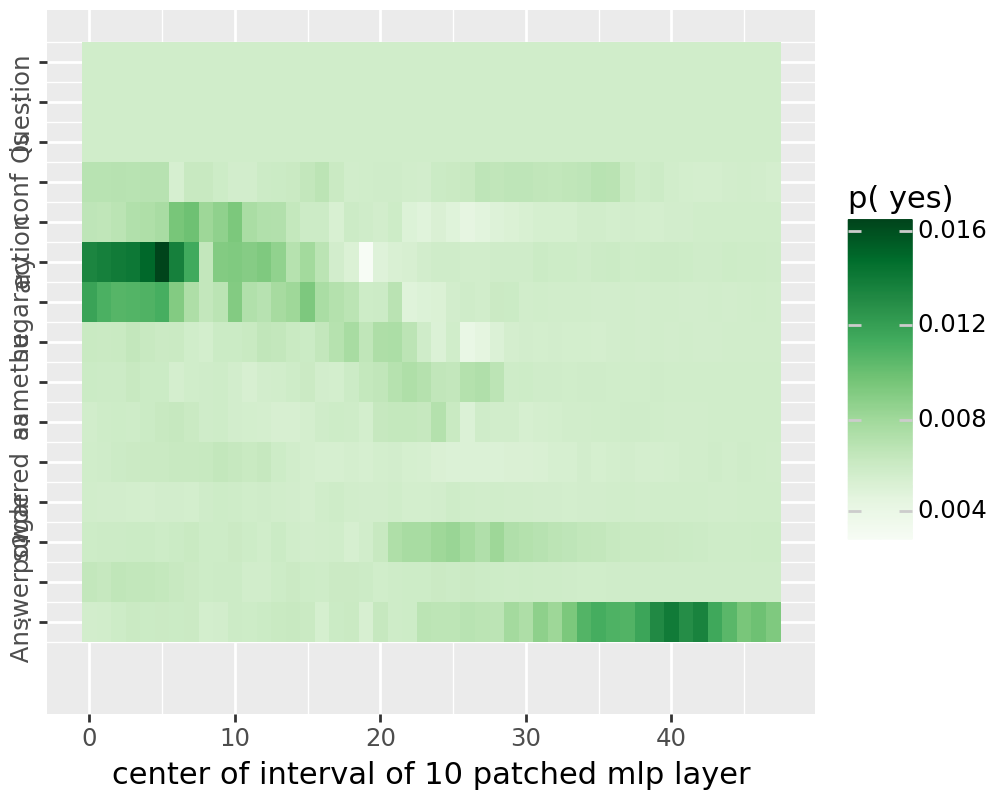

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_3_pyvene_rome_attention_output.pdf


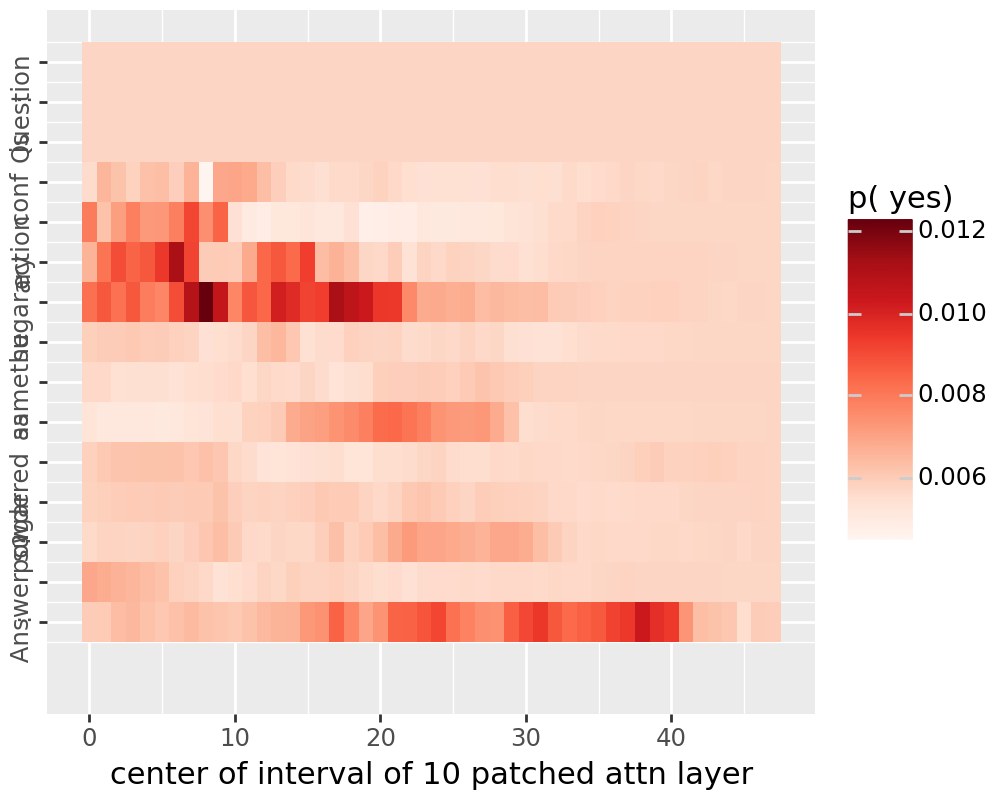

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_4_pyvene_rome_block_output.pdf


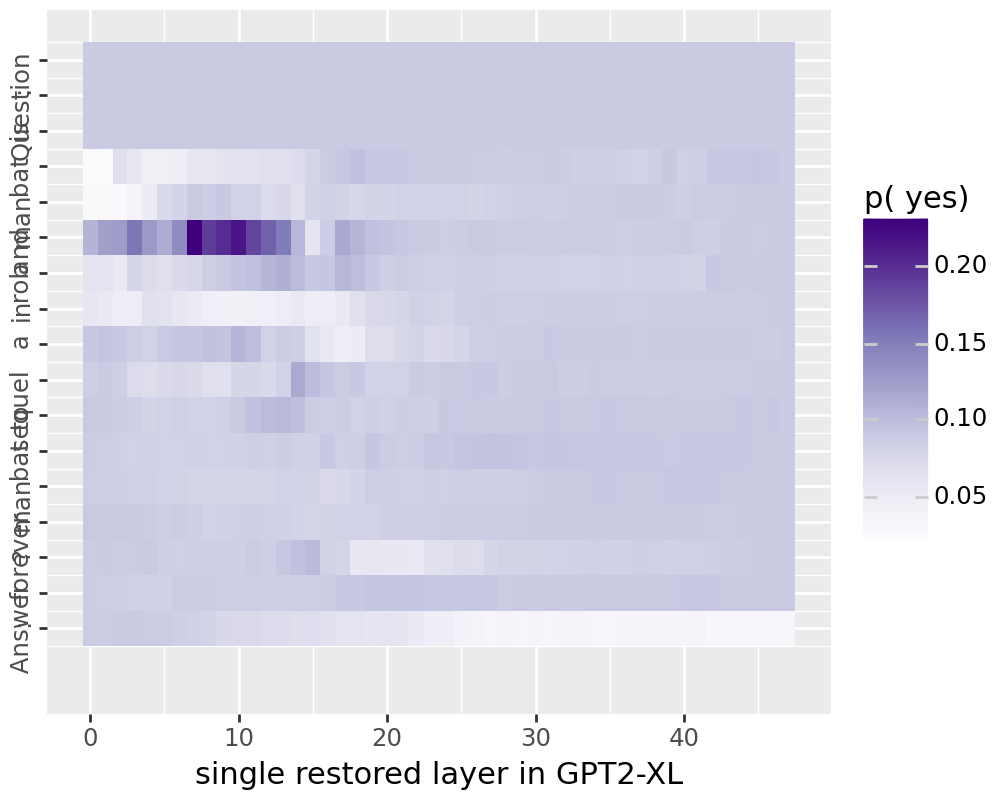

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_4_pyvene_rome_mlp_activation.pdf


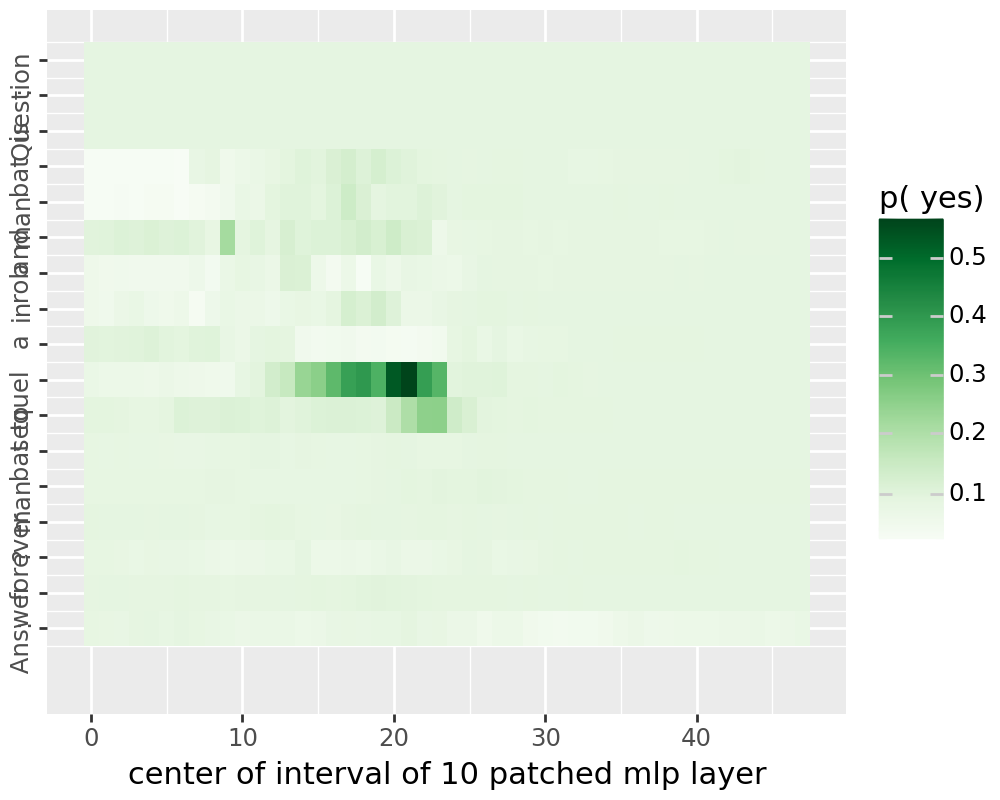

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_4_pyvene_rome_attention_output.pdf


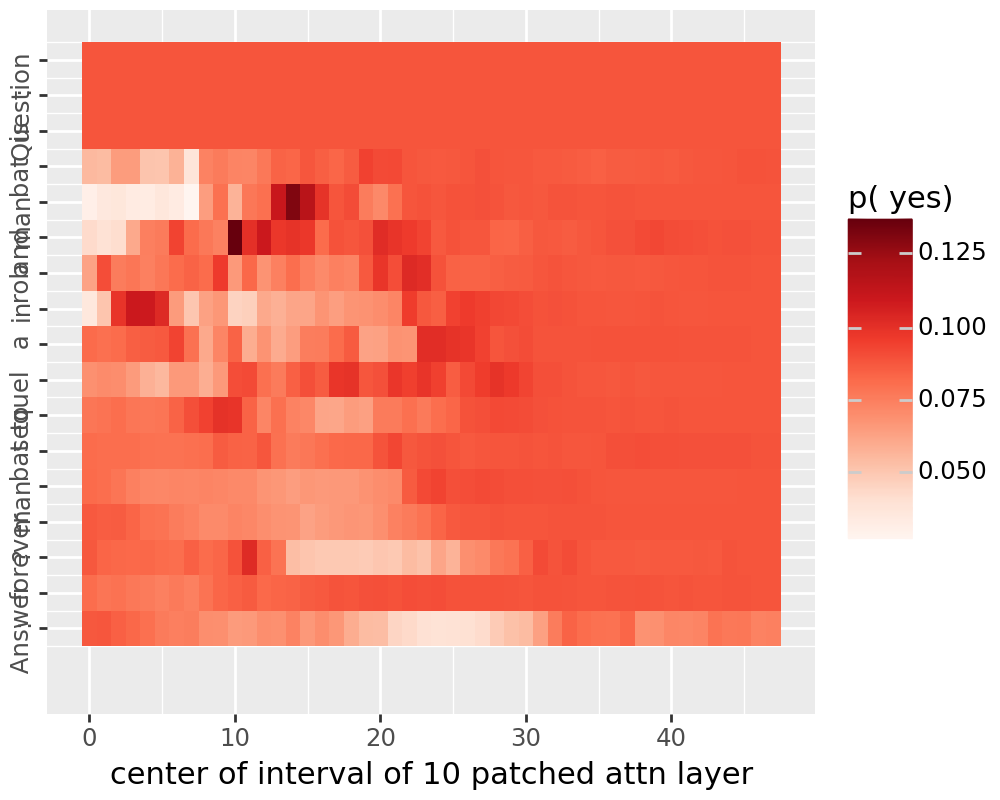

In [ ]:
from plotnine import *
import pandas as pd
for example in examples2:
  id = example["id"]
  sentence = example['question']
  answer = " yes"
  for stream in ["block_output", "mlp_activation", "attention_output"]:
    df = pd.read_csv(f"./tutorial_data/yes_{id}_pyvene_rome_{stream}.csv")
    df["layer"] = df["layer"].astype(int)
    df["pos"] = df["pos"].astype(int)
    df[f"p({answer})"] = df["prob"].astype(float)

    tokenize_sentence = tokenizer.encode(sentence)
    decoded_sentence = [tokenizer.decode(tok) for tok in tokenize_sentence]
    custom_labels = decoded_sentence
    breaks = [i for i in range(len(custom_labels))]

    plot = (
        ggplot(df, aes(x="layer", y="pos"))
        + geom_tile(aes(fill=f"p({answer})"))
        + scale_fill_cmap(colors[stream])
        + xlab(titles[stream])
        + scale_y_reverse(
            limits=(-0.5, len(tokenize_sentence) + 0.5), #rozszerzyc zakres
            breaks=breaks, labels=custom_labels
        )
        + theme(figure_size=(5, 4))
        + ylab("")
        + theme(axis_text_y=element_text(angle=90, hjust=1))
    )
    # Save the plot to a file
    ggsave(
        plot, filename=f"./tutorial_data/yes_{id}_pyvene_rome_{stream}.pdf", dpi=200
    )
    # Display the plot in the notebook
    display(plot)

In [ ]:
for example in examples3:
  sentence = example["question"]
  subject_tokens_positions = example["sub_tokens"]
  id = example["id"]
  sentence_tokens = tokenizer.encode(sentence)

  answer_token = tokenizer.encode(" no")[0]

  print(sentence)
  #corrupt
  base = tokenizer(sentence, return_tensors="pt").to(device)
  config = corrupted_config(type(gpt), len(subject_tokens_positions))
  intervenable = IntervenableModel(config, gpt)
  _, counterfactual_outputs = intervenable(
      base, unit_locations={"base": ([[subject_tokens_positions]])}
  )
  distrib = embed_to_distrib(gpt, counterfactual_outputs.last_hidden_state, logits=False)

  for stream in ["block_output", "mlp_activation", "attention_output"]:
    data = []
    for layer_i in tqdm(range(gpt.config.n_layer)):
        for pos_i in range(len(sentence_tokens)):
            config = restore_corrupted_with_interval_config(
                layer_i, stream,
                window=1 if stream == "block_output" else 10, noise_dim=len(subject_tokens_positions)
            )
            n_restores = len(config.representations) - 1
            intervenable = IntervenableModel(config, gpt)
            _, counterfactual_outputs = intervenable(
                base,
                [None] + [base]*n_restores,
                {
                    "sources->base": (
                        [None] + [[[pos_i]]]*n_restores,
                        [[subject_tokens_positions]] + [[[pos_i]]]*n_restores,
                    )
                },
            )
            distrib = embed_to_distrib(
                gpt, counterfactual_outputs.last_hidden_state, logits=False
            )

            prob = distrib[0][-1][answer_token].detach().cpu().item()
            data.append({"layer": layer_i, "pos": pos_i, "prob": prob})
    df = pd.DataFrame(data)
    df.to_csv(f"./tutorial_data/yes_{id}_pyvene_rome_{stream}.csv")

did abraham lincoln paint the mona lisa


100%|██████████| 48/48 [03:34<00:00,  4.47s/it]


do good samaritan laws protect those who shoplift


100%|██████████| 48/48 [03:35<00:00,  4.50s/it]


is confectionary sugar the same as pepper spray


100%|██████████| 48/48 [03:14<00:00,  4.06s/it]


is batman and robin a sequel to shrek


100%|██████████| 48/48 [03:35<00:00,  4.48s/it]


/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_1_pyvene_rome_block_output.pdf


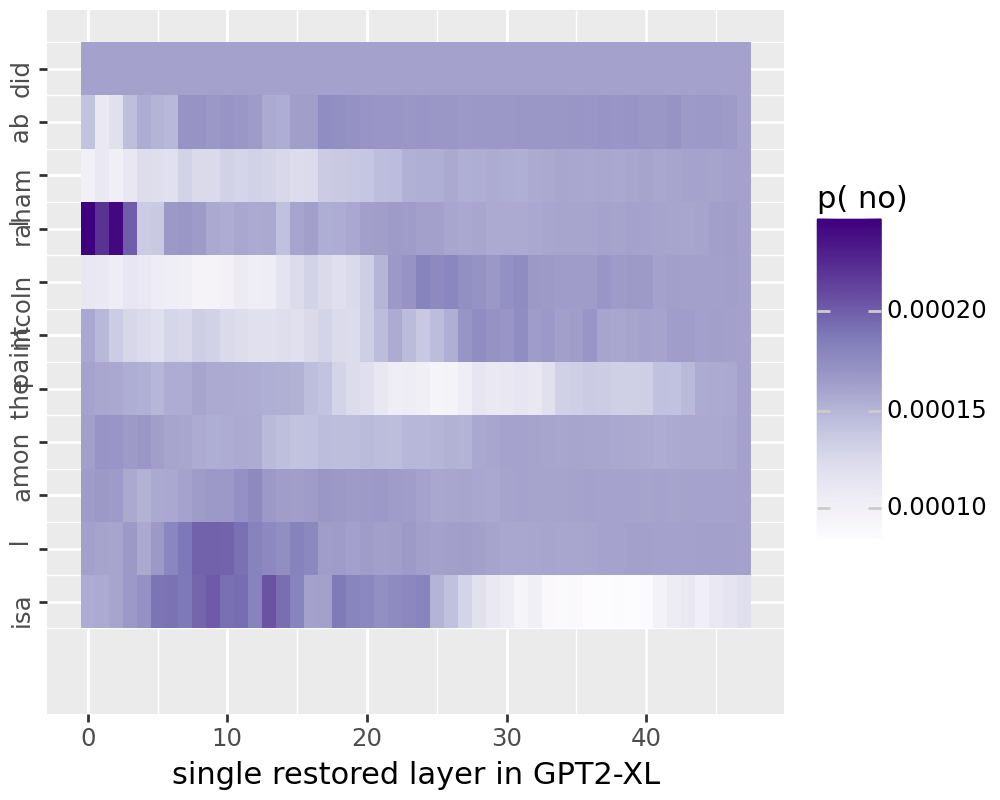

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_1_pyvene_rome_mlp_activation.pdf


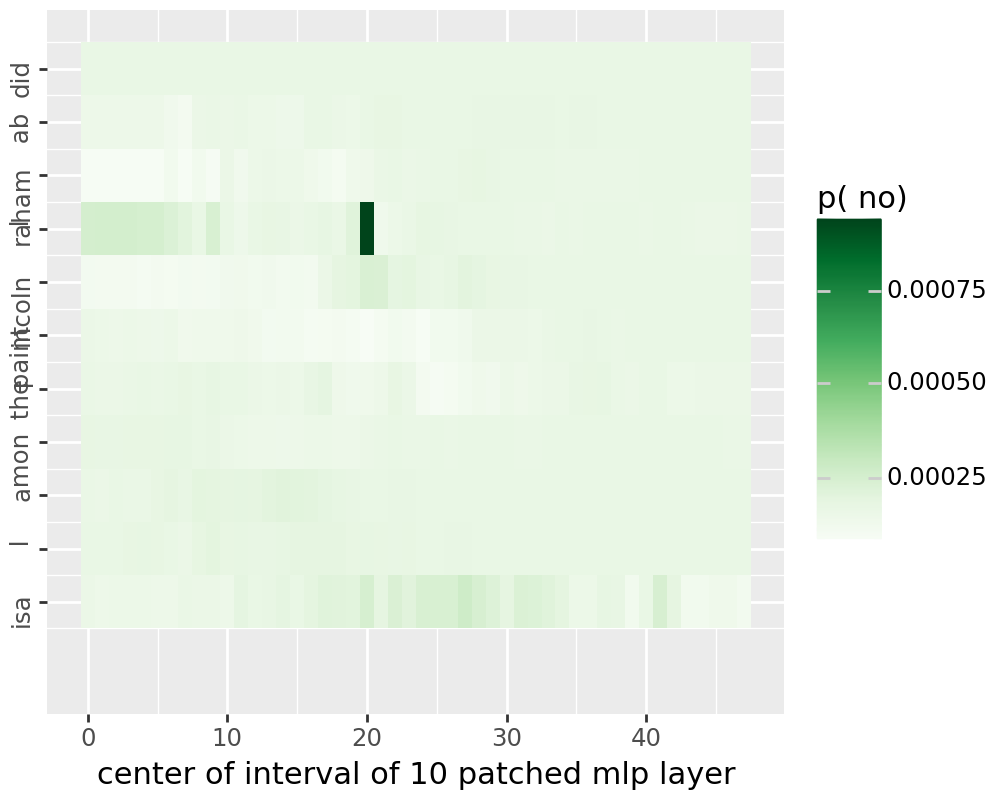

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_1_pyvene_rome_attention_output.pdf


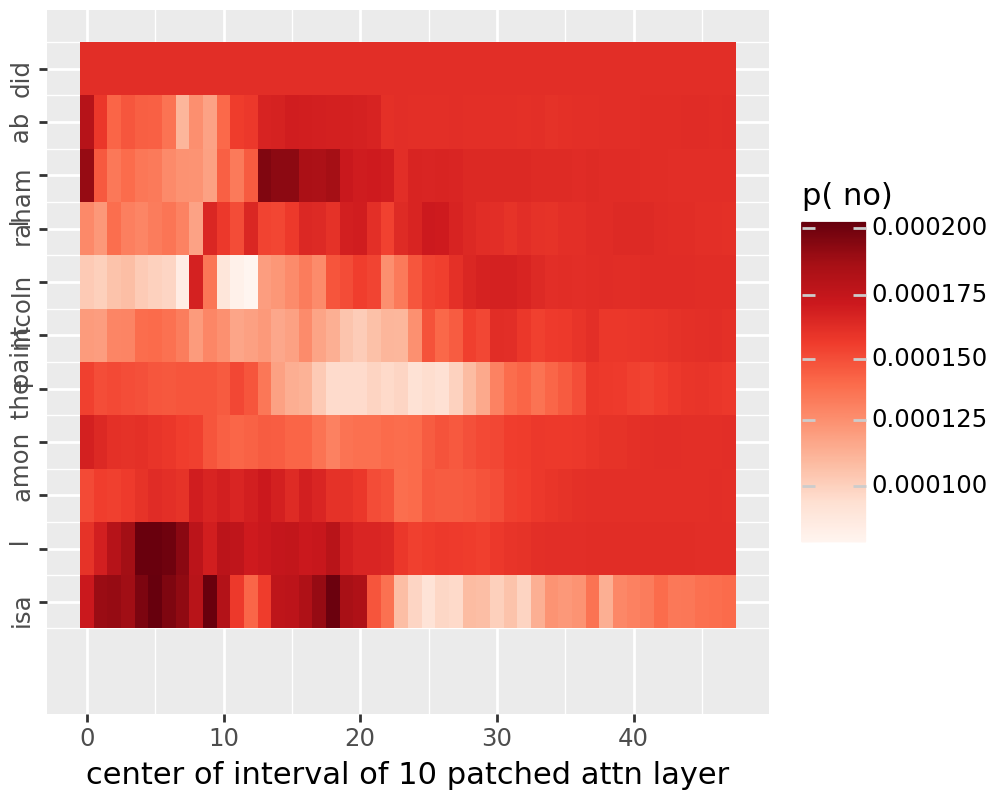

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_2_pyvene_rome_block_output.pdf


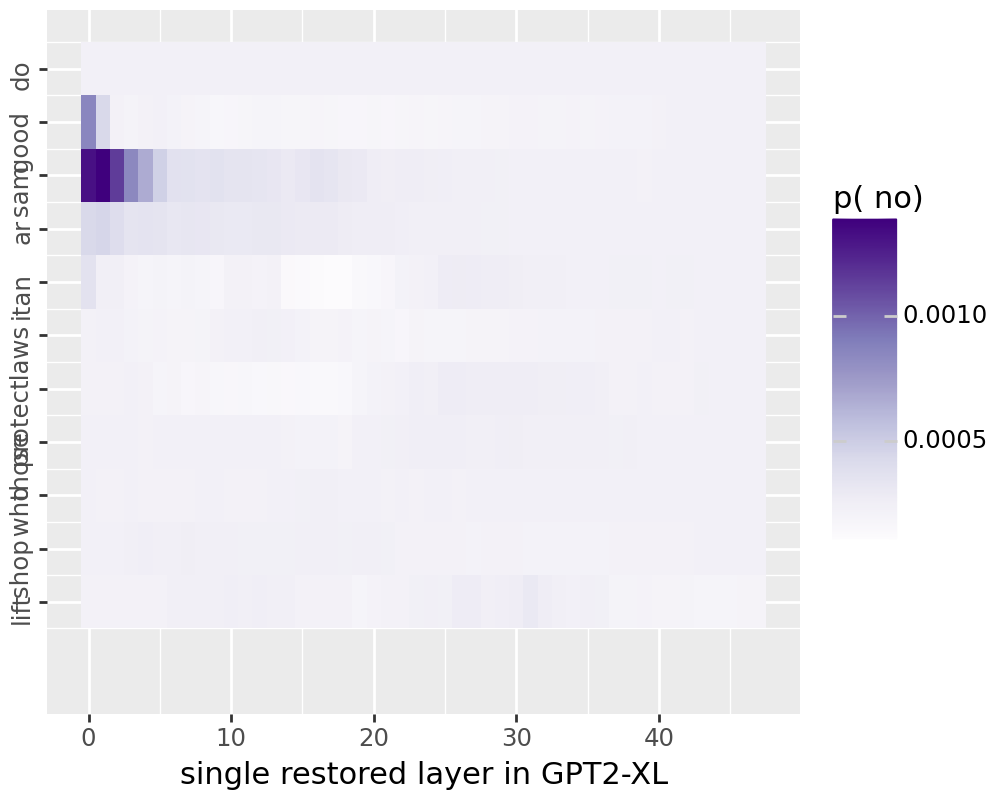

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_2_pyvene_rome_mlp_activation.pdf


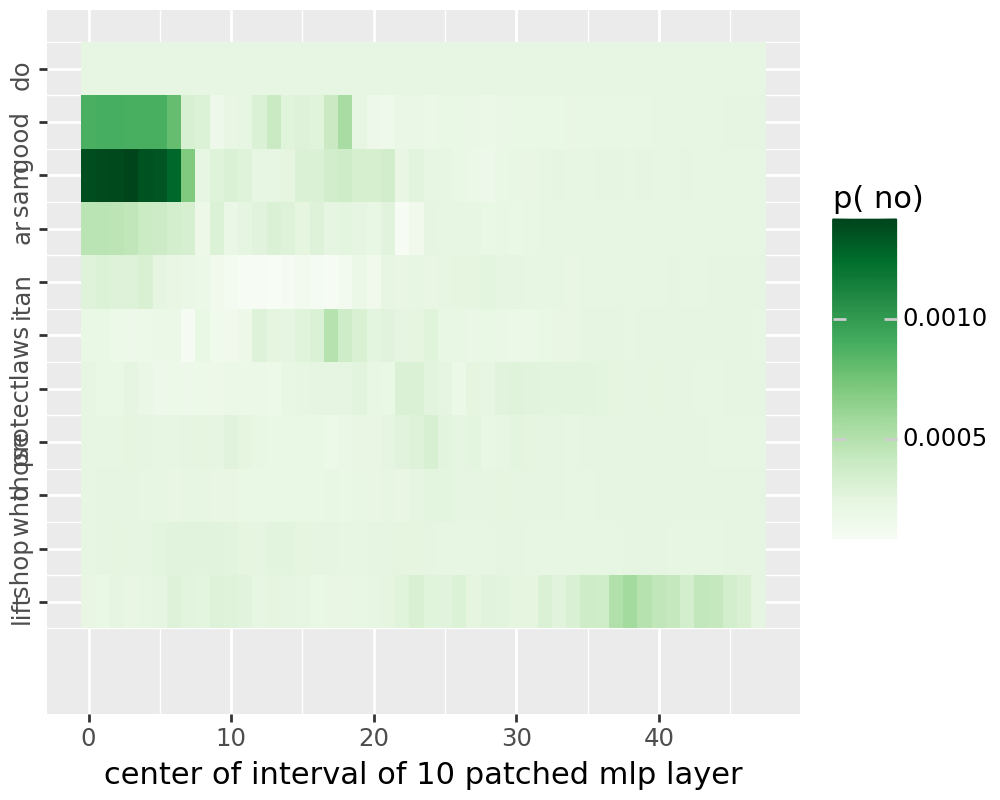

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_2_pyvene_rome_attention_output.pdf


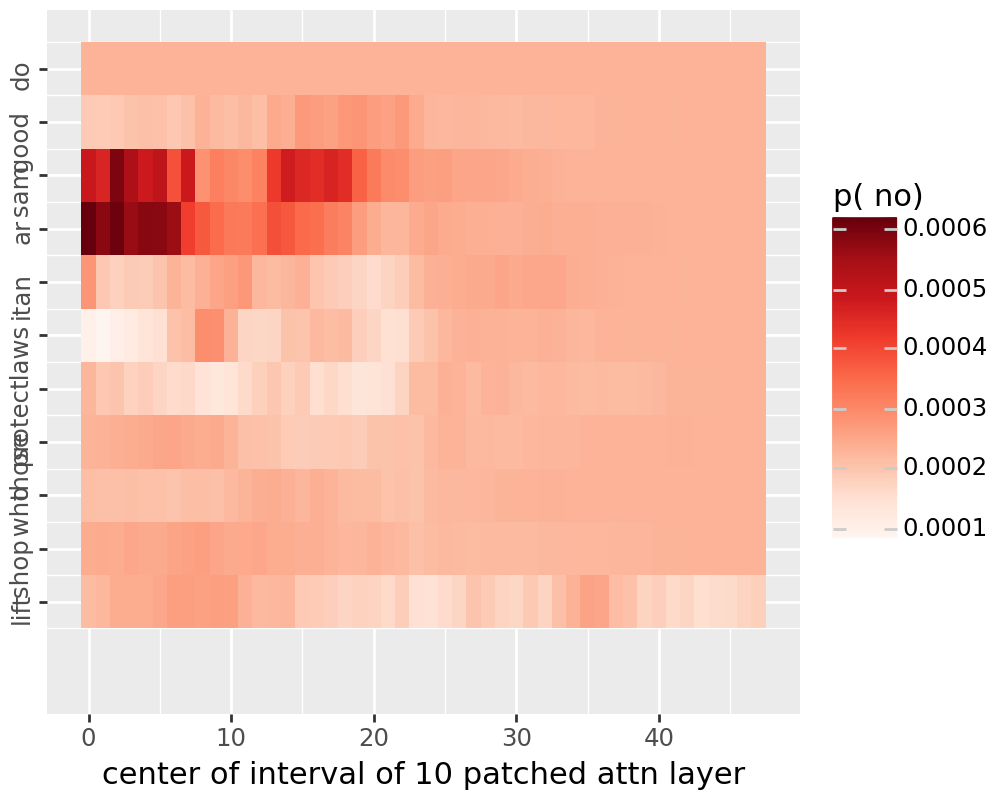

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_3_pyvene_rome_block_output.pdf


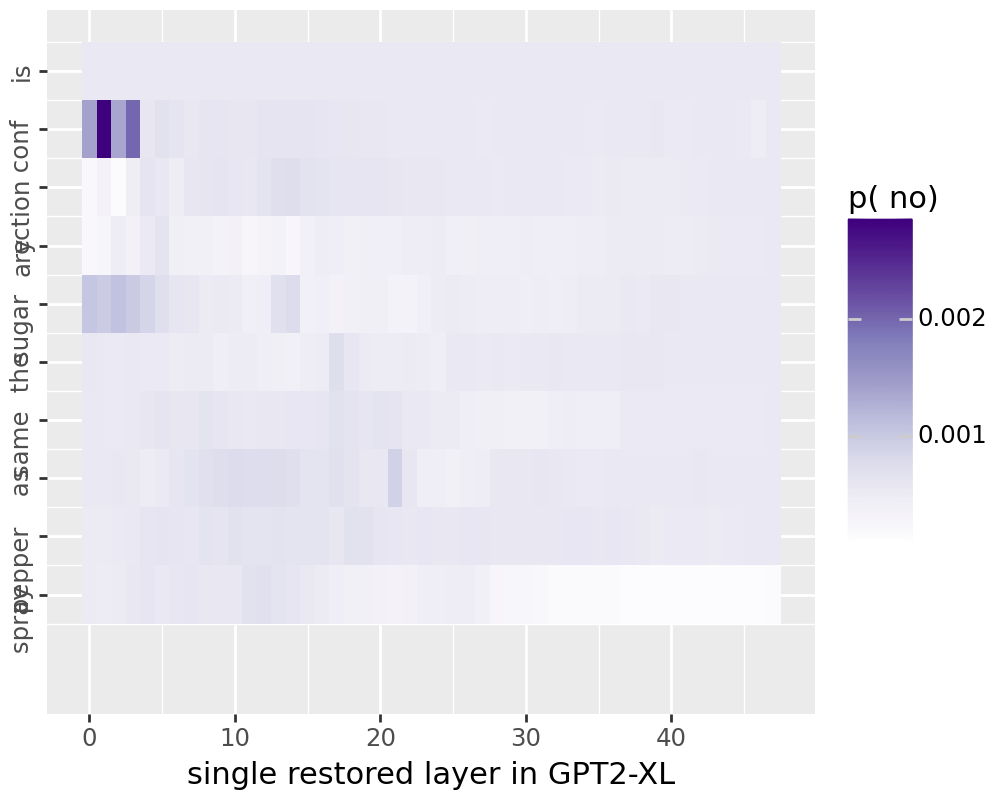

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_3_pyvene_rome_mlp_activation.pdf


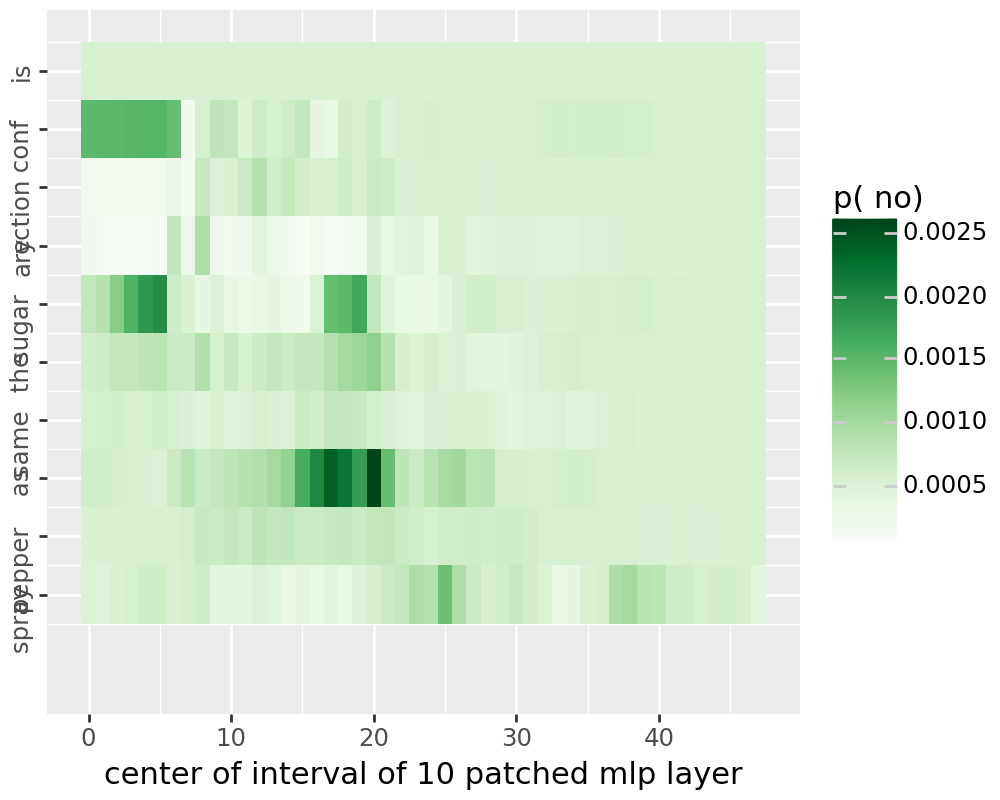

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_3_pyvene_rome_attention_output.pdf


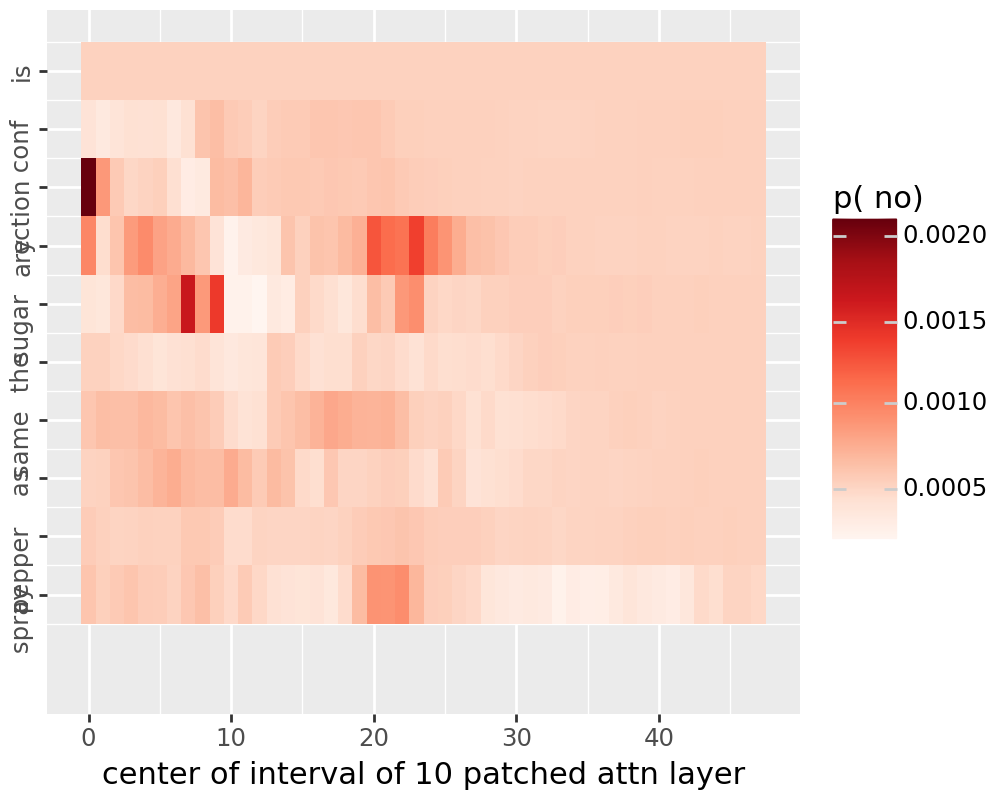

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_4_pyvene_rome_block_output.pdf


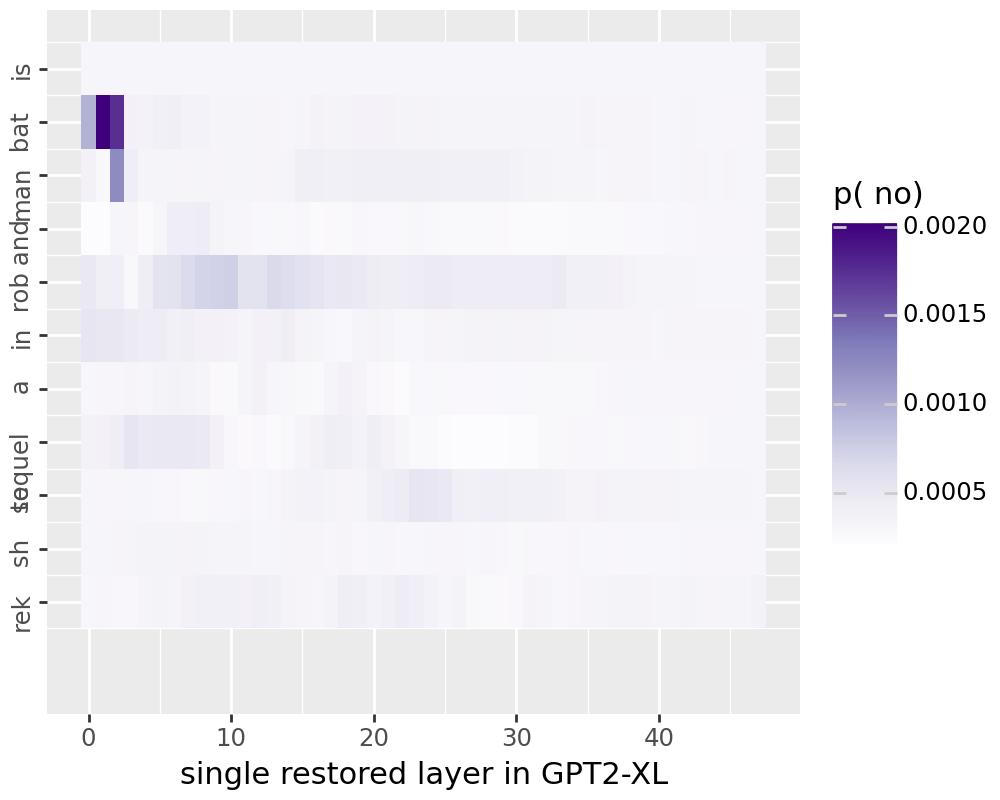

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_4_pyvene_rome_mlp_activation.pdf


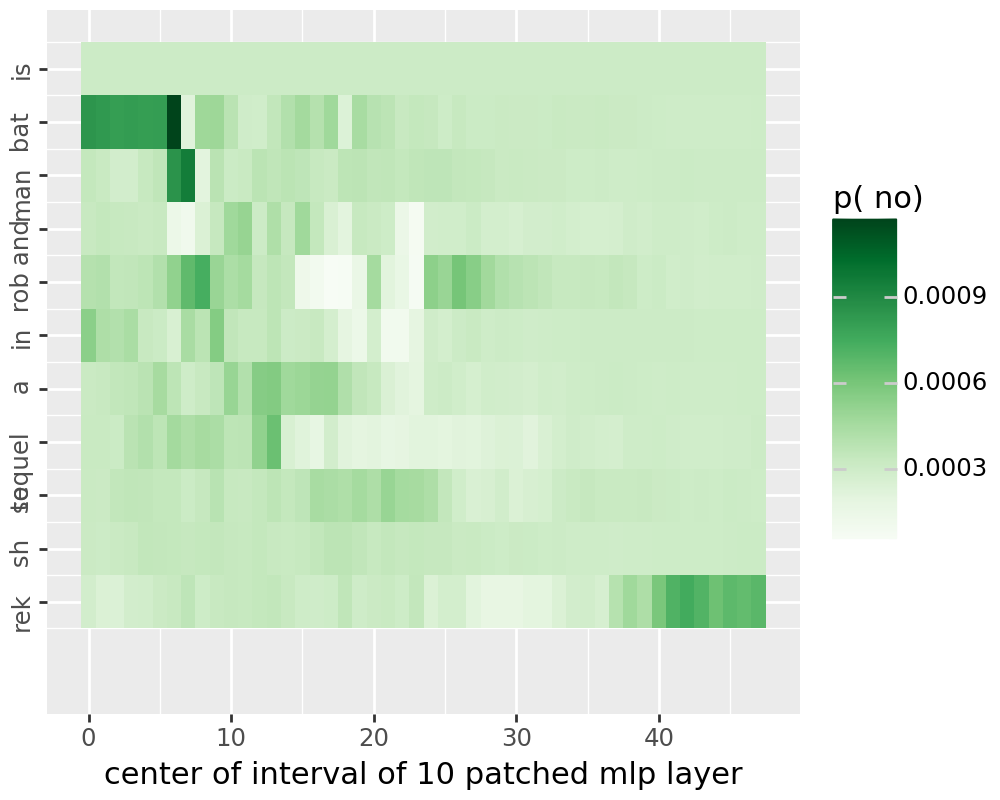

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/yes_4_pyvene_rome_attention_output.pdf


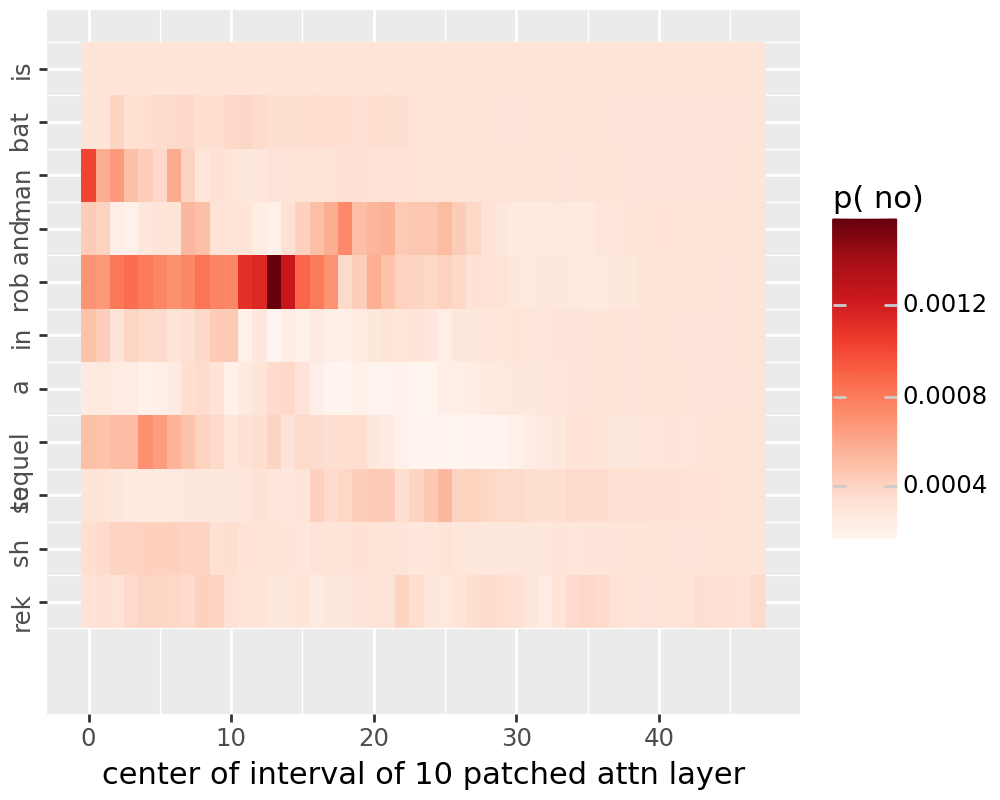

In [ ]:
from plotnine import *
import pandas as pd
for example in examples3:
  id = example["id"]
  sentence = example['question']
  answer = " no"
  for stream in ["block_output", "mlp_activation", "attention_output"]:
    df = pd.read_csv(f"./tutorial_data/yes_{id}_pyvene_rome_{stream}.csv")
    df["layer"] = df["layer"].astype(int)
    df["pos"] = df["pos"].astype(int)
    df[f"p({answer})"] = df["prob"].astype(float)

    tokenize_sentence = tokenizer.encode(sentence)
    decoded_sentence = [tokenizer.decode(tok) for tok in tokenize_sentence]
    custom_labels = decoded_sentence
    breaks = [i for i in range(len(custom_labels))]

    plot = (
        ggplot(df, aes(x="layer", y="pos"))
        + geom_tile(aes(fill=f"p({answer})"))
        + scale_fill_cmap(colors[stream])
        + xlab(titles[stream])
        + scale_y_reverse(
            limits=(-0.5, len(tokenize_sentence) + 0.5), #rozszerzyc zakres
            breaks=breaks, labels=custom_labels
        )
        + theme(figure_size=(5, 4))
        + ylab("")
        + theme(axis_text_y=element_text(angle=90, hjust=1))
    )
    # Save the plot to a file
    ggsave(
        plot, filename=f"./tutorial_data/yes_{id}_pyvene_rome_{stream}.pdf", dpi=200
    )
    # Display the plot in the notebook
    display(plot)